In [179]:
import matplotlib.pyplot as plt
import math
from random import randrange
import numpy as np

In [180]:
class Node:
    def __init__(self):
        self.x = 0
        self.y = 0
        self.node_id = -1
        self.g_cost = math.inf
        self.h_cost = math.inf
        self.f_cost = math.inf
        self.is_obstacle = False
        self.is_visited = False
        self.parent = None
        
        # Strictly for visualization purposes
        self.is_start = False
        self.is_goal = False
        
    def __eq__(self, other):
        return self.node_id == other.node_id

In [201]:
class Map:
    def __init__(self, height, width):
        self.height = height
        self.width = width
        self.map = []
    
    def create_map(self):
        k = 0
        for x in range(self.width):
            row = []
            for y in range(self.height):
                node = Node()
                node.x = x
                node.y = y
                node.node_id = k
                k = k + 1
                row.append(node)
            self.map.append(row)
        
    def create_obstacles(self, obstacles):
        for obstacle in obstacles:
            if not self.map[obstacle['x']][obstacle['y']].is_start and \
               not self.map[obstacle['x']][obstacle['y']].is_goal:
                self.map[obstacle['x']][obstacle['y']].is_obstacle = True
            
    def get_node(self, x, y):
        return self.map[x][y]
        
    def display_map(self):
        for i in range(self.width):
            for j in range(self.height):
                if self.map[i][j].is_obstacle:
                    plt.plot(self.map[i][j].x, self.map[i][j].y, 'rs')
                elif self.map[i][j].is_start:
                    plt.plot(self.map[i][j].x, self.map[i][j].y, 'b+')
                elif self.map[i][j].is_goal:
                    plt.plot(self.map[i][j].x, self.map[i][j].y, 'm*')
                else:
                    plt.plot(self.map[i][j].x, self.map[i][j].y, 'g.')

        plt.show()
        
    def plot_path(self, x_path, y_path):
        for i in range(self.width):
            for j in range(self.height):
                if self.map[i][j].is_obstacle:
                    plt.plot(self.map[i][j].x, self.map[i][j].y, 'rs')
                elif self.map[i][j].is_start:
                    plt.plot(self.map[i][j].x, self.map[i][j].y, 'b+')
                elif self.map[i][j].is_goal:
                    plt.plot(self.map[i][j].x, self.map[i][j].y, 'm*')
                elif self.map[i][j].is_visited:
                    plt.plot(self.map[i][j].x, self.map[i][j].y, 'kx')
                else:
                    plt.plot(self.map[i][j].x, self.map[i][j].y, 'g.')
        
        plt.plot(x_path, y_path, 'k-')
        plt.show()

In [202]:
class State:
    def __init__(self):
        self.x = 0
        self.y = 0
        self.theta = 0
        self.v = 0
        self.w = 0

In [203]:
class ControlInput:
    def __init__(self):
        self.v = 0
        self.w = 0

In [204]:
class Robot:
    def __init__(self, init_state):
        self.max_linear_velocity = 1.0
        self.max_angular_velocity = math.radians(30)
        self.max_linear_acceleration = 2.0
        self.max_angular_acceleration = math.radians(0.1)
        self.radius = 0.1
        self.state = init_state
        self.dt = 0.1
    
    def compute_motion(self, control_input):
        self.state.theta += control_input.w * self.dt
        self.state.x += control_input.v * self.dt * math.cos(self.state.theta)
        self.state.y += control_input.v * self.dt * math.sin(self.state.theta)
        return self.state
    
    def simulate_motion(self, control_input, current_state):
        new_state = State()
        new_state.theta = current_state.theta + control_input.w * self.dt
        new_state.x = current_state.x + control_input.v * self.dt * math.cos(new_state.theta)
        new_state.y = current_state.y + control_input.v * self.dt * math.cos(new_state.theta)
        return new_state

In [215]:
class DWALocalPlanner:
    def __init__(self, map, robot):
        self.sim_resolution = 0.005
        self.sim_iterations = 100
        self.map = map
        self.goal = None
        self.robot = robot
        self.configured_window = [-self.robot.max_linear_velocity, self.robot.max_linear_velocity,
                                  -self.robot.max_angular_velocity, self.robot.max_angular_velocity]
        self.d_gain = 0.15
        self.o_gain = 100
        self.s_gain = 1
        
    def create_dynamic_window(self):
        dynamic_window = [self.robot.state.v - self.robot.max_linear_acceleration * self.robot.dt,
                          self.robot.state.v + self.robot.max_linear_acceleration * self.robot.dt,
                          self.robot.state.w - self.robot.max_angular_acceleration * self.robot.dt,
                          self.robot.state.w + self.robot.max_angular_acceleration * self.robot.dt]
        
        return [max(self.configured_window[0], dynamic_window[0]),
                min(self.configured_window[1], dynamic_window[1]),
                max(self.configured_window[2], dynamic_window[2]),
                min(self.configured_window[3], dynamic_window[3])]
    
    def calculate_distance_to_goal(self, final_pose, goal):
        return math.sqrt((goal.x - final_pose.x)**2 + (goal.y - final_pose.y)**2)
    
    def identify_collision(self, trajectory):
        return 0
    
    def compute_trajectory(self, v, w):
        trajectory = []
        control_input = ControlInput()
        control_input.v = v
        control_input.w = w
        
        state = self.robot.state
        for _ in range(self.sim_iterations):
            state = self.robot.simulate_motion(control_input, state)
            trajectory.append(state)
        
        return trajectory
    
    def simulate_window(self, dynamic_window, goal):
        tentative_cost = math.inf
        final_cost = math.inf
        control_input = ControlInput()
        
        for v in np.arange(dynamic_window[0], dynamic_window[1], self.sim_resolution):
            for w in np.arange(dynamic_window[2], dynamic_window[3], self.sim_resolution):
                trajectory = self.compute_trajectory(v, w)
                print(trajectory[-1].x, trajectory[-1].y)
                tentative_cost = self.d_gain * self.calculate_distance_to_goal(trajectory[-1], goal)
#                 tentative_cost += self.o_gain * self.identify_collision(trajectory)
                tentative_cost += self.s_gain * (self.robot.max_linear_velocity - v)
                
                if tentative_cost < final_cost:
                    final_cost = tentative_cost
                    control_input.v = v
                    control_input.w = w
        
        return control_input
    
    def navigate(self, goal):
        self.goal = goal
        while True:
            dynamic_window = self.create_dynamic_window()
            control_input = self.simulate_window(dynamic_window, goal)
            
            if self.calculate_distance_to_goal(self.robot.state, goal) <= self.robot.radius:
                break
            else:
                state = self.robot.compute_motion(control_input)
                print(state.x, state.y)

In [216]:
map = Map(15,15)
map.create_map()

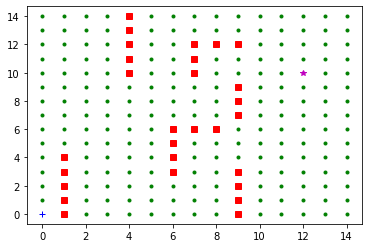

In [217]:
start = map.get_node(0, 0)
start.is_start = True

goal = map.get_node(12, 10)
goal.is_goal = True

map.create_obstacles([{'x': 1, 'y': 0}, {'x': 1, 'y': 1}, {'x': 1, 'y': 2}, {'x': 1, 'y': 3}, {'x': 1, 'y': 4},
                      {'x': 4, 'y': 10}, {'x': 4, 'y': 11}, {'x': 4, 'y': 12}, {'x': 4, 'y': 13}, {'x': 4, 'y': 14},
                      {'x': 6, 'y': 6}, {'x': 7, 'y': 6}, {'x': 8, 'y': 6}, {'x': 9, 'y': 7}, {'x': 9, 'y': 8}, 
                      {'x': 6, 'y': 5}, {'x': 6, 'y': 4}, {'x': 6, 'y': 3},
                      {'x': 9, 'y': 9}, {'x': 9, 'y': 0}, {'x': 9, 'y': 1}, {'x': 9, 'y': 2}, {'x': 9, 'y': 3},
                      {'x': 7, 'y': 10}, {'x': 7, 'y': 11}, {'x': 7, 'y': 12}, {'x': 8, 'y': 12}, {'x': 9, 'y': 12}])

map.display_map()

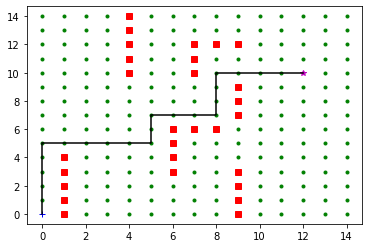

In [218]:
global_path = [[12, 11, 10, 9, 8, 8, 8, 8, 7, 6, 5, 5, 5, 4, 3, 2, 1, 0, 0, 0, 0, 0, 0],
               [10, 10, 10, 10, 10, 9, 8, 7, 7, 7, 7, 6, 5, 5, 5, 5, 5, 5, 4, 3, 2, 1, 0]]

map.plot_path(global_path[0], global_path[1])

init_state = State()
init_state.x = start.x
init_state.y = start.y
init_state.theta = math.radians(90)
init_state.v = 0
init_state.w = 0

robot = Robot(init_state)

In [219]:
dwa_local_planner = DWALocalPlanner(map, robot)
dwa_local_planner.navigate(goal)

-0.0017627820925565027 -0.0017627820925565027
-0.0017187125402425905 -0.0017187125402425905
-0.001674642987928678 -0.001674642987928678
-0.001630573435614765 -0.001630573435614765
-0.001586503883300852 -0.001586503883300852
-0.0015424343309869398 -0.0015424343309869398
-0.0014983647786730263 -0.0014983647786730263
-0.0014542952263591146 -0.0014542952263591146
-0.0014102256740452018 -0.0014102256740452018
-0.001366156121731289 -0.001366156121731289
-0.001322086569417377 -0.001322086569417377
-0.0012780170171034645 -0.0012780170171034645
-0.0012339474647895517 -0.0012339474647895517
-0.0011898779124756389 -0.0011898779124756389
-0.0011458083601617265 -0.0011458083601617265
-0.0011017388078478137 -0.0011017388078478137
-0.0010576692555339013 -0.0010576692555339013
-0.0010135997032199883 -0.0010135997032199883
-0.0009695301509060759 -0.0009695301509060759
-0.0009254605985921635 -0.0009254605985921635
-0.0008813910462782506 -0.0008813910462782506
-0.0008373214939643381 -0.000837321493964338

0.0009070473613068263 0.07890364388016671
0.0009546075702156244 0.07895120408907556
0.0010021677791244227 0.07899876429798433
0.0010497279880332215 0.07904632450689308
0.0010972881969420198 0.07909388471580185
0.0011448484058508175 0.07914144492471072
0.001192408614759616 0.07918900513361943
0.0012399688236684147 0.07923656534252836
0.0012875290325772126 0.07928412555143703
0.001335089241486011 0.0793316857603459
0.0013826494503948092 0.07937924596925469
0.0014302096593036078 0.07942680617816349
0.001477769868212406 0.07947436638707228
0.001525330077121204 0.07952192659598104
0.0015728902860300026 0.0795694868048899
0.0016204504949388012 0.07961704701379872
0.001668010703847599 0.07966460722270748
0.0017155709127563978 0.07971216743161626
0.0017631311216651957 0.07975972764052507
0.0018106913305739943 0.07980728784943386
0.0018582515394827922 0.0798548480583426
-----------------------------------------------------
-0.0019322098328204155 0.09556268491577052
-0.0018837769597984512 0.0956

-8.853179449764528e-05 0.17539615209489567
-3.660826517320608e-05 0.1754480756242202
1.5315264151233095e-05 0.17549999915354464
6.723879347567229e-05 0.17555192268286907
0.00011916232280011144 0.1756038462121936
0.0001710858521245506 0.1756557697415179
0.00022300938144898989 0.17570769327084232
0.00027493291077342904 0.17575961680016686
0.0003268564400978682 0.17581154032949142
0.00037877996942230733 0.1758634638588157
0.00043070349874674654 0.17591538738814017
0.0004826270280711857 0.17596731091746456
0.0005345505573956251 0.17601923444678905
0.0005864740867200641 0.1760711579761135
0.0006383976160445034 0.17612308150543798
0.0006903211453689425 0.17617500503476236
0.0007422446746933818 0.17622692856408678
0.0007941682040178209 0.1762788520934112
0.0008460917333422598 0.1763307756227358
0.0008980152626666994 0.17638269915206006
0.0009499387919911384 0.1764346226813845
0.0010018623213155775 0.17648654621070897
0.0010537858506400165 0.17653846974003334
0.0011057093799644556 0.1765903932

-0.0010900013706491858 0.27187425999853715
-0.001033714521304526 0.27193054684788215
-0.0009774276719598663 0.2719868336972264
-0.0009211408226152061 0.27204312054657137
-0.0008648539732705469 0.2720994073959158
-0.0008085671239258866 0.27215569424526054
-0.0007522802745812271 0.272211981094605
-0.0006959934252365668 0.2722682679439499
-0.0006397065758919075 0.27232455479329415
-0.0005834197265472479 0.27238084164263904
-0.0005271328772025878 0.27243712849198365
-0.0004708460278579281 0.2724934153413284
-0.0004145591785132684 0.27254970219067315
-0.0003582723291686086 0.27260598904001737
-0.00030198547982394897 0.2726622758893624
-0.0002456986304792891 0.2727185627387069
-0.00018941178113462932 0.2727748495880516
-0.00013312493178996955 0.2728311364373964
-7.683808244530975e-05 0.27288742328674104
-2.0551233100649982e-05 0.2729437101360857
3.573561624400982e-05 0.2729999969854303
9.202246558866961e-05 0.2730562838347749
0.0001483093149333293 0.2731125706841196
0.00020459616427798903 0.

0.001911300660070296 0.3528530963928966
0.0019710781651241004 0.3529128738979507
0.0020308556701779047 0.35297265140300443
0.0020906331752317095 0.353032428908058
0.0021504106802855117 0.35309220641311195
0.002210188185339317 0.35315198391816555
0.0022699656903931204 0.35321176142321953
0.0023297431954469234 0.35327153892827323
0.002389520700500729 0.35333131643332727
-----------------------------------------------------
-0.0023613423092867817 0.3680739859066024
-0.0023006921403505506 0.36813463607553837
-0.0022400419714143187 0.36819528624447484
-0.0021793918024780863 0.3682559364134109
-0.0021187416335418556 0.3683165865823474
-0.0020580914646056237 0.3683772367512834
-0.0019974412956693913 0.3684378869202197
-0.001936791126733161 0.36849853708915575
-0.0018761409577969287 0.36855918725809195
-0.0018154907888606978 0.3686198374270285
-0.0017548406199244667 0.3686804875959646
-0.0016941904509882358 0.3687411377649007
-0.0016335402820520037 0.3688017879338371
-0.0015728901131157715 0.3

0.00028635609186148037 0.44869240963047047
0.0003504969161400127 0.44875655045474927
0.0004146377404185445 0.44882069127902774
0.0004787785646970768 0.44888483210330615
0.0005429193889756087 0.448948972927585
0.0006070602132541406 0.4490131137518631
0.0006712010375326729 0.44907725457614184
0.0007353418618112049 0.44914139540042053
0.000799482686089737 0.449205536224699
0.0008636235103682687 0.4492696770489777
0.0009277643346468013 0.44933381787325566
0.0009919051589253334 0.44939795869753446
0.0010560459832038651 0.4494620995218129
0.001120186807482397 0.4495262403460915
0.0011843276317609302 0.4495903811703698
0.0012484684560394622 0.4496545219946486
0.0013126092803179936 0.44971866281892675
0.0013767501045965256 0.44978280364320555
0.0014408909288750576 0.4498469444674843
0.0015050317531535907 0.4499110852917627
0.001569172577432123 0.4499752261160412
0.0016333134017106532 0.45003936694031993
0.0016974542259891865 0.45010350776459834
0.001761595050267719 0.4501676485888768
0.0018257

-0.000478359573101312 0.5453834398021351
-0.0004098554300865124 0.5454519439451493
-0.00034135128707171253 0.5455204480881651
-0.00027284714405691266 0.5455889522311794
-0.00020434300104211285 0.545657456374194
-0.00013583885802731315 0.5457259605172087
-6.733471501251318e-05 0.5457944646602237
1.1694280022865715e-06 0.5458629688032387
6.967357101708645e-05 0.5459314729462535
0.00013817771403188618 0.5459999770892681
0.00020668185704668596 0.5460684812322826
0.0002751860000614859 0.5461369853752974
0.00034369014307628575 0.5462054895183124
0.0004121942860910857 0.5462739936613275
0.0004806984291058852 0.5463424978043421
0.0005492025721206854 0.5464110019473567
0.0006177067151354851 0.546479506090371
0.0006862108581502846 0.5465480102333868
0.0007547150011650847 0.546616514376401
0.0008232191441798843 0.5466850185194161
0.000891723287194684 0.5467535226624305
0.0009602274302094836 0.5468220268054457
0.0010287315732242842 0.5468905309484609
0.0010972357162390837 0.5469590350914759
0.0011

0.0019075742380828657 0.6257278411660901
0.00197956903571266 0.6257998359637196
0.0020515638333424534 0.6258718307613489
0.0021235586309722456 0.625943825558979
0.002195553428602038 0.6260158203566087
0.0022675482262318313 0.6260878151542386
0.002339543023861625 0.6261598099518679
0.002411537821491417 0.6262318047494982
0.0024835326191212106 0.6263037995471278
0.0025555274167510045 0.6263757943447572
0.002627522214380797 0.6264477891423871
0.002699517012010589 0.6265197839400173
0.002771511809640383 0.6265917787376473
0.0028435066072701755 0.6266637735352767
0.002915501404899967 0.6267357683329062
0.002987496202529762 0.6268077631305364
-----------------------------------------------------
-0.0027237681610917082 0.6405852643394482
-0.00265090069986233 0.6406581318006774
-0.002578033238632951 0.6407309992619071
-0.002505165777403571 0.6408038667231363
-0.002432298316174194 0.6408767341843653
-0.002359430854944814 0.6409496016455949
-0.002286563393715435 0.6410224691068247
-0.00221369593

-0.0011351876252860401 0.7201255017246475
-0.001058829509882944 0.7202018598400506
-0.0009824713944798483 0.7202782179554544
-0.0009061132790767519 0.7203545760708572
-0.0008297551636736555 0.7204309341862597
-0.0007533970482705595 0.7205072923016632
-0.0006770389328674631 0.7205836504170663
-0.0006006808174643667 0.7206600085324699
-0.0005243227020612711 0.7207363666478726
-0.00044796458665817486 0.7208127247632761
-0.00037160647125507844 0.7208890828786785
-0.0002952483558519825 0.7209654409940824
-0.00021889024044888632 0.7210417991094851
-0.00014253212504579014 0.7211181572248883
-6.617400964269396e-05 0.7211945153402909
1.0184105760402154e-05 0.7212708734556945
8.654222116349842e-05 0.7213472315710978
0.00016290033656659453 0.7214235896865009
0.00023925845196969066 0.7214999478019036
0.0003156165673727868 0.7215763059173064
0.000391974682775883 0.7216526640327094
0.00046833279817897925 0.7217290221481127
0.0005446909135820756 0.7218053802635164
0.0006210490289851712 0.721881738378

0.002608646348888634 0.8018155435580957
0.002688495118093288 0.8018953923272998
0.0027683438872979403 0.801975241096505
0.002848192656502594 0.8020550898657092
0.002928041425707249 0.8021349386349136
0.0030078901949119018 0.8022147874041183
0.0030877389641165544 0.8022946361733235
0.003167587733321209 0.8023744849425282
0.003247436502525862 0.8024543337117326
0.0033272852717305137 0.8025341824809369
0.0034071340409351698 0.8026140312501421
-----------------------------------------------------
-0.0029215310165486385 0.81577106670825
-0.002840809583953739 0.8158517881408449
-0.0027600881513588408 0.8159325095734403
-0.00267936671876394 0.8160132310060348
-0.0025986452861690426 0.8160939524386296
-0.002517923853574141 0.8161746738712244
-0.002437202420979244 0.81625539530382
-0.002356480988384345 0.8163361167364148
-0.0022757595557894453 0.8164168381690096
-0.0021950381231945464 0.816497559601604
-0.002114316690599648 0.8165782810341995
-0.0020335952580047487 0.8166590024667937
-0.0019528

0.0004521187453891565 0.8970841125575771
0.0005363308312964881 0.8971683246434842
0.0006205429172038197 0.8972525367293919
0.0007047550031111509 0.8973367488152997
0.0007889670890184823 0.8974209609012065
0.0008731791749258144 0.897505172987114
0.0009573912608331466 0.8975893850730209
0.0010416033467404774 0.897673597158929
0.001125815432647809 0.8977578092448358
0.0012100275185551403 0.8978420213307432
0.0012942396044624725 0.8979262334166502
0.0013784516903698034 0.898010445502558
0.0014626637762771354 0.8980946575884655
0.0015468758621844667 0.8981788696743733
0.0016310879480917978 0.8982630817602801
0.0017153000339991294 0.8983472938461872
0.0017995121199064614 0.8984315059320949
0.0018837242058137938 0.8985157180180023
0.001967936291721124 0.8985999301039096
0.002052148377628455 0.8986841421898174
0.002136360463535788 0.8987683542757239
0.0022205725494431204 0.8988525663616317
0.0023047846353504505 0.8989367784475383
0.0023889967212577814 0.8990209905334464
0.0024732088071651127 0

-0.0013202182850679271 0.9927283567475091
-0.0012316428830992287 0.9928169321494784
-0.0011430674811305304 0.992905507551447
-0.0010544920791618324 0.992994082953416
-0.0009659166771931352 0.993082658355385
-0.0008773412752244368 0.9931712337573534
-0.0007887658732557391 0.9932598091593217
-0.0007001904712870414 0.9933483845612906
-0.0006116150693183432 0.9934369599632594
-0.0005230396673496453 0.9935255353652288
-0.0004344642653809475 0.9936141107671972
-0.0003458888634122494 0.9937026861691659
-0.0002573134614435515 0.9937912615711341
-0.0001687380594748538 0.9938798369731034
-8.016265750615577e-05 0.9939684123750719
8.412744462542138e-06 0.9940569877770407
9.698814643124009e-05 0.9941455631790087
0.0001855635483999381 0.9942341385809779
0.0002741389503686362 0.9943227139829471
0.00036271435233733404 0.9944112893849155
0.00045128975430603187 0.994499864786884
0.0005398651562747296 0.9945884401888525
0.0006284405582434277 0.9946770155908209
0.0007170159602121256 0.9947655909927902
0.0

0.0035623021264066844 1.075538010561292
0.0036543681807403995 1.0756300766156262
0.0037464342350741167 1.0757221426699597
0.0038385002894078335 1.0758142087242941
0.00393056634374155 1.0759062747786257
0.004022632398075265 1.075998340832961
0.004114698452408985 1.0760904068872934
-----------------------------------------------------
-0.0031743673684296557 1.088282272760075
-0.003081428651074132 1.0883752114774332
-0.0029884899337186085 1.0884681501947877
-0.002895551216363083 1.0885610889121449
-0.002802612499007559 1.088654027629498
-0.002709673781652035 1.0887469663468543
-0.002616735064296512 1.0888399050642097
-0.0025237963469409872 1.0889328437815655
-0.002430857629585464 1.089025782498921
-0.0023379189122299396 1.0891187212162774
-0.002244980194874416 1.0892116599336317
-0.0021520414775188924 1.089304598650987
-0.0020591027601633673 1.0893975373683422
-0.0019661640428078435 1.0894904760856985
-0.0018732253254523199 1.0895834148030532
-0.0017802866080967959 1.0896763535204113
-0.0

0.0016835437464342567 1.1710605038435764
0.0017799731155912425 1.1711569332127336
0.001876402484748229 1.1712533625818893
0.0019728318539052143 1.171349791951047
0.0020692612230622004 1.1714462213202042
0.002165690592219188 1.1715426506893618
0.002262119961376173 1.1716390800585177
0.0023585493305331613 1.1717355094276751
0.0024549786996901453 1.171831938796833
0.0025514080688471327 1.1719283681659889
0.002647837438004119 1.1720247975351465
0.002744266807161108 1.1721212269043024
0.0028406961763180914 1.1722176562734603
0.002937125545475078 1.1723140856426177
0.0030335549146320627 1.172410515011773
0.0031299842837890506 1.1725069443809326
0.0032264136529460375 1.1726033737500887
0.0033228430221030228 1.1726998031192466
0.00341927239126001 1.1727962324884031
0.003515701760416996 1.1728926618575597
0.0036121311295739815 1.1729890912267154
0.003708560498730968 1.1730855205958735
0.003804989867887957 1.1731819499650302
0.003901419237044942 1.1732783793341874
0.003997848606201928 1.17337480

-0.0006810700520670814 1.2660886242476697
-0.0005802773688211775 1.2661894169309165
-0.00047948468557527333 1.2662902096141606
-0.0003786920023293691 1.266391002297407
-0.00027789931908346594 1.266491794980653
-0.00017710663583756116 1.2665925876638977
-7.631395259165755e-05 1.2666933803471432
2.4478730654246685e-05 1.2667941730303907
0.00012527141390015082 1.2668949657136361
0.00022606409714605468 1.2669957583968836
0.0003268567803919586 1.2670965510801293
0.00042764946363786285 1.2671973437633757
0.0005284421468837667 1.2672981364466205
0.0006292348301296713 1.2673989291298662
0.0007300275133755716 1.2674997218131119
0.0008308201966214795 1.2676005144963576
0.0009316128798673832 1.2677013071796033
0.001032405563113287 1.267802099862848
0.0011331982463591913 1.2679028925460945
0.0012339909296050955 1.2680036852293401
0.001334783612850999 1.2681044779125876
0.0014355762960969027 1.2682052705958333
0.0015363689793428071 1.2683060632790806
0.0016371616625887112 1.268406855962326
0.001737

-0.002729561067704113 1.361424349233275
-0.002624405071136871 1.3615295052298422
-0.0025192490745696294 1.3616346612264094
-0.002414093078002389 1.3617398172229778
-0.0023089370814351473 1.3618449732195441
-0.002203781084867905 1.3619501292161105
-0.002098625088300663 1.3620552852126773
-0.0019934690917334224 1.3621604412092456
-0.00188831309516618 1.3622655972058115
-0.0017831570985989392 1.3623707532023819
-0.001678001102031697 1.362475909198947
-0.0015728451054644553 1.3625810651955144
-0.001467689108897214 1.3626862211920827
-0.0013625331123299723 1.362791377188649
-0.001257377115762731 1.362896533185217
-0.0011522211191954896 1.363001689181783
-0.001047065122628248 1.3631068451783515
-0.0009419091260610059 1.3632120011749187
-0.000836753129493765 1.3633171571714846
-0.0007315971329265229 1.363422313168053
-0.0006264411363592813 1.3635274691646204
-0.0005212851397920398 1.3636326251611879
-0.0004161291432247982 1.363737781157754
-0.00031097314665755636 1.3638429371543215
-0.0002058

0.002900080798112772 1.4449552302967392
0.003008727444762094 1.4450638769433894
0.00311737409141142 1.445172523590038
0.0032260207380607436 1.4452811702366881
0.003334667384710071 1.4453898168833363
0.0034433140313593923 1.4454984635299868
0.003551960678008716 1.445607110176636
0.003660607324658039 1.4457157568232837
0.003769253971307366 1.445824403469936
0.003877900617956689 1.4459330501165837
0.0039865472646060125 1.4460416967632344
0.004095193911255338 1.4461503434098828
0.00420384055790466 1.4462589900565317
0.004312487204553986 1.4463676367031801
0.004421133851203311 1.4464762833498304
0.0045297804978526365 1.4465849299964797
0.004638427144501959 1.446693576643129
0.004747073791151283 1.4468022232897784
0.0048557204378006065 1.4469108699364295
0.004964367084449934 1.4470195165830757
0.005073013731099255 1.4471281632297264
0.005181660377748582 1.4472368098763753
-----------------------------------------------------
-0.003410805772065054 1.4581188015871804
-0.0033012864629772846 1.4

-0.0010717174990640716 1.5383523133695267
-0.0009587075405587905 1.5384653233280325
-0.0008456975820535079 1.538578333286538
-0.0007326876235482268 1.538691343245042
-0.0006196776650429449 1.538804353203548
-0.0005066677065376635 1.5389173631620539
-0.00039365774803238235 1.5390303731205595
-0.0002806477895271007 1.5391433830790633
-0.0001676378310218188 1.539256393037569
-5.462787251653725e-05 1.5393694029960747
5.838208598874467e-05 1.5394824129545788
0.0001713920444940255 1.5395954229130837
0.00028440200299930795 1.5397084328715902
0.00039741196150458956 1.5398214428300951
0.0005104219200098712 1.5399344527886019
0.000623431878515152 1.5400474627471066
0.0007364418370204335 1.540160472705612
0.0008494517955257162 1.5402734826641171
0.0009624617540309966 1.5403864926226218
0.0010754717125362751 1.540499502581127
0.0011884816710415612 1.5406125125396322
0.0013014916295468425 1.5407255224981369
0.0014145015880521225 1.540838532456642
0.001527511546557406 1.5409515424151474
0.0016405215

0.005263943513668795 1.6225769449138527
0.00538044412104079 1.6226934455212267
0.00549694472841279 1.6228099461285954
0.005613445335784783 1.622926446735969
0.005729945943156781 1.6230429473433405
-----------------------------------------------------
-0.0034799200414694824 1.6333044719193508
-0.0033625467719688626 1.6334218451888534
-0.003245173502468244 1.6335392184583535
-0.0031278002329676257 1.6336565917278556
-0.003010426963467006 1.633773964997353
-0.002893053693966386 1.6338913382668556
-0.002775680424465769 1.634008711536356
-0.0026583071549651487 1.6341260848058563
-0.0025409338854645307 1.6342434580753564
-0.0024235606159639113 1.6343608313448588
-0.0023061873464632924 1.6344782046143587
-0.002188814076962674 1.634595577883859
-0.0020714408074620555 1.634712951153359
-0.001954067537961436 1.6348303244228606
-0.0018366942684608174 1.63494769769236
-0.0017193209989601983 1.6350650709618628
-0.0016019477294595798 1.6351824442313623
-0.0014845744599589613 1.6352998175008626
-0.00

0.004112638164495044 1.7187791839008835
0.004233502082149955 1.7189000478185377
0.004354365999804869 1.719020911736192
0.004475229917459783 1.7191417756538487
0.004596093835114695 1.7192626395715027
0.004716957752769604 1.7193835034891582
0.00483782167042452 1.719504367406813
0.00495868558807943 1.7196252313244673
0.005079549505734343 1.7197460952421215
0.005200413423389257 1.7198669591597782
0.005321277341044172 1.7199878230774324
0.0054421412586990806 1.720108686995087
0.005563005176353996 1.7202295509127419
0.005683869094008907 1.7203504148303987
0.005804733011663824 1.7204712787480507
0.005925596929318732 1.7205921426657067
0.006046460846973648 1.7207130065833611
-----------------------------------------------------
-0.003506404948665037 1.7306298270852123
-0.003384668369062931 1.7307515636648163
-0.0032629317894608224 1.7308733002444179
-0.0031411952098587144 1.7309950368240212
-0.0030194586302566065 1.7311167734036204
-0.002897722050654498 1.7312385099832241
-0.002775985471052391

0.0014876223311633885 1.8134991907914746
0.0016128495581807917 1.8136244180184924
0.0017380767851981893 1.8137496452455084
0.0018633040122155854 1.8138748724725264
0.0019885312392329854 1.8140000996995431
0.0021137584662503832 1.8141253269265605
0.00223898569326778 1.8142505541535792
0.002364212920285179 1.8143757813805963
0.0024894401473025754 1.8145010086076148
0.002614667374319974 1.814626235834632
0.002739894601337373 1.814751463061648
0.002865121828354771 1.8148766902886657
0.0029903490553721684 1.8150019175156835
0.003115576282389568 1.8151271447427
0.003240803509406963 1.8152523719697176
0.0033660307364243615 1.8153775991967356
0.0034912579634417606 1.8155028264237534
0.0036164851904591597 1.8156280536507703
0.003741712417476557 1.8157532808777872
0.0038669396444939545 1.8158785081048048
0.003992166871511355 1.8160037353318224
0.004117394098528751 1.8161289625588406
0.004242621325546151 1.8162541897858568
0.004367848552563548 1.8163794170128749
0.004493075779580943 1.81650464423

-0.0015887783129919105 1.9077592905176375
-0.0014591877775656872 1.9078888810530634
-0.001329597242139464 1.9080184715884891
-0.0012000067067132402 1.9081480621239157
-0.0010704161712870172 1.9082776526593412
-0.0009408256358607932 1.908407243194768
-0.0008112351004345707 1.9085368337301942
-0.0006816445650083463 1.9086664242656204
-0.0005520540295821235 1.9087960148010465
-0.00042246349415590005 1.9089256053364727
-0.00029287295872967644 1.909055195871899
-0.0001632824233034517 1.9091847864073257
-3.369188787722874e-05 1.909314376942752
9.589864754899387e-05 1.9094439674781774
0.00022548918297521812 1.9095735580136042
0.00035507971840144164 1.9097031485490308
0.0004846702538276637 1.9098327390844558
0.0006142607892538873 1.9099623296198815
0.0007438513246801117 1.9100919201553093
0.0008734418601063355 1.9102215106907348
0.001003032395532559 1.9103511012261623
0.001132622930958783 1.9104806917615884
0.0012622134663850051 1.9106102822970141
0.0013918040018112297 1.9107398728324407
0.001

0.005913317987317591 1.993124450521475
0.006046399168761911 1.9932575317029206
0.006179480350206232 1.9933906128843644
0.006312561531650549 1.9935236940658079
0.006445642713094869 1.9936567752472532
0.006578723894539187 1.9937898564286984
0.00671180507598351 1.9939229376101402
0.006844886257427827 1.9940560187915857
0.006977967438872146 1.9941890999730296
-----------------------------------------------------
-0.0035352974322376005 2.0031407486738435
-0.0034013435893894403 2.003274702516692
-0.0032673897465412788 2.00340865635954
-0.0031334359036931173 2.0035426102023877
-0.002999482060844956 2.003676564045236
-0.0028655282179967964 2.003810517888084
-0.0027315743751486353 2.003944471730932
-0.0025976205323004742 2.0040784255737796
-0.002463666689452314 2.0042123794166278
-0.002329712846604154 2.004346333259481
-0.002195759003755993 2.0044802871023255
-0.002061805160907834 2.0046142409451733
-0.0019278513180596727 2.0047481947880224
-0.001793897475211512 2.004882148630872
-0.00165994363

0.0030660352490720242 2.087598326049125
0.0032034797371248477 2.0877357705371784
0.0033409242251776685 2.08787321502523
0.0034783687132304906 2.0880106595132846
0.0036158132012833115 2.08814810400134
0.0037532576893361353 2.088285548489391
0.0038907021773889505 2.0884229929774416
0.004028146665441774 2.088560437465497
0.004165591153494596 2.088697881953551
0.00430303564154742 2.0888353264416026
0.004440480129600237 2.0889727709296557
0.004577924617653057 2.089110215417708
0.004715369105705881 2.089247659905758
0.004852813593758703 2.089385104393813
0.004990258081811525 2.0895225488818654
0.005127702569864347 2.0896599933699216
0.005265147057917163 2.0897974378579725
0.005402591545969986 2.0899348823460238
0.00554003603402281 2.0900723268340764
0.00567748052207563 2.0902097713221277
0.005814925010128447 2.090347215810182
0.00595236949818127 2.090484660298235
0.006089813986234088 2.090622104786288
0.00622725847428691 2.0907595492743374
0.006364702962339731 2.0908969937623945
0.0065021474

0.0013028190301897155 2.1831477436671727
0.0014446268238043397 2.1832895514607857
0.0015864346174189609 2.1834313592544
0.0017282424110335863 2.183573167048016
0.0018700502046482097 2.1837149748416294
0.0020118579982628328 2.183856782635245
0.0021536657918774516 2.1839985904288586
0.0022954735854920794 2.184140398222472
0.0024372813791067004 2.184282206016088
0.0025790891727213287 2.1844240138097013
0.002720896966335952 2.184565821603317
0.0028627047599505736 2.1847076293969314
0.0030045125535651945 2.1848494371905445
0.0031463203471798207 2.1849912449841606
0.0032881281407944403 2.185133052777774
0.0034299359344090656 2.18527486057139
0.003571743728023689 2.185416668365003
0.003713551521638313 2.1855584761586195
0.0038553593152529366 2.1857002839522366
0.003997167108867563 2.1858420917458496
0.004138974902482181 2.185983899539462
0.004280782696096806 2.1861257073330784
0.004422590489711429 2.1862675151266937
0.004564398283326057 2.1864093229203077
0.004706206076940676 2.18655113071392

-0.00013554796483827315 2.2790134853390214
1.062313325822638e-05 2.279159656437118
0.00015679423135472312 2.2793058275352145
0.00030296532945122106 2.279451998633313
0.00044913642754771776 2.279598169731407
0.0005953075256442175 2.279744340829502
0.0007414786237407133 2.2798905119276007
0.000887649721837212 2.280036683025699
0.0010338208199337099 2.2801828541237947
0.0011799919180302074 2.280329025221892
0.001326163016126702 2.280475196319987
0.0014723341142232015 2.2806213674180844
0.001618505212319698 2.28076753851618
0.0017646763104161947 2.280913709614276
0.0019108474085126946 2.2810598807123745
0.0020570185066091907 2.281206051810469
0.0022031896047056895 2.281352222908567
0.0023493607028021815 2.2814983940066624
0.0024955318008986834 2.2816445651047577
0.002641702898995179 2.281790736202856
0.0027878739970916807 2.2819369073009503
0.0029340450951881787 2.2820830783990487
0.0030802161932846745 2.282229249497145
0.003226387291381169 2.2823754205952405
0.0033725583894776696 2.282521

0.007750203655278477 2.3647363852722445
0.007899865396160593 2.3648860470131274
0.00804952713704272 2.365035708754009
0.008199188877924835 2.3651853704948906
0.008348850618806955 2.3653350322357722
-----------------------------------------------------
-0.0034678119826752583 2.372976804077002
-0.0033172775812100445 2.3731273384784686
-0.0031667431797448285 2.3732778728799335
-0.003016208778279613 2.373428407281398
-0.0028656743768143973 2.3735789416828625
-0.002715139975349183 2.373729476084329
-0.002564605573883967 2.3738800104857924
-0.002414071172418754 2.3740305448872587
-0.002263536770953537 2.3741810792887232
-0.0021130023694883224 2.374331613690193
-0.001962467968023108 2.3744821480916554
-0.0018119335665578917 2.3746326824931208
-0.001661399165092676 2.3747832168945857
-0.001510864763627462 2.3749337512960524
-0.0013603303621622475 2.3750842856975165
-0.0012097959606970317 2.3752348200989815
-0.0010592615592318168 2.375385354500446
-0.0009087271577666023 2.3755358889019096
-0.00

0.003955253212875147 2.4582301963233246
0.004109278256211537 2.4583842213666616
0.004263303299547925 2.4585382464099976
0.004417328342884312 2.458692271453335
0.004571353386220696 2.4588462964966733
0.004725378429557086 2.4590003215400076
0.00487940347289347 2.4591543465833423
0.005033428516229859 2.4593083716266806
0.005187453559566245 2.459462396670017
0.005341478602902633 2.459616421713354
0.005495503646239017 2.4597704467566905
0.005649528689575405 2.4599244718000257
0.005803553732911791 2.4600784968433596
0.0059575787762481845 2.4602325218866987
0.006111603819584568 2.4603865469300343
0.006265628862920957 2.460540571973373
0.006419653906257339 2.460694597016708
0.006573678949593728 2.4608486220600434
0.006727703992930117 2.4610026471033803
0.006881729036266504 2.461156672146715
0.007035754079602886 2.4613106971900534
0.007189779122939274 2.4614647222333885
0.007343804166275659 2.461618747276726
0.0074978292096120475 2.4617727723200598
0.007651854252948435 2.4619267973633994
0.0078

0.0005667462980590927 2.552121923657272
0.0007251346426767794 2.552280312001892
0.0008835229872944638 2.5524387003465088
0.0010419113319121538 2.5525970886911242
0.0012002996765298403 2.552755477035743
0.0013586880211475295 2.552913865380361
0.0015170763657652146 2.553072253724978
0.0016754647103829035 2.5532306420695976
0.001833853055000588 2.5533890304142144
0.0019922413996182747 2.5535474187588325
0.002150629744235961 2.5537058071034493
0.002309018088853649 2.5538641954480683
0.0024674064334713384 2.554022583792686
0.0026257947780890236 2.554180972137302
0.0027841831227067124 2.5543393604819213
0.002942571467324393 2.554497748826538
0.003100959811942086 2.554656137171155
0.0032593481565597686 2.5548145255157744
0.0034177365011774604 2.5549729138603903
0.003576124845795147 2.555131302205008
0.0037345131904128336 2.555289690549627
0.0038929015350305184 2.5554480788942437
0.004051289879648209 2.555606467238862
0.004209678224265891 2.5557648555834787
0.004368066568883581 2.5559232439280

0.0079806819811309 2.6373539066253158
0.008142560965906764 2.6375157856100886
0.008304439950682625 2.6376776645948676
0.008466318935458489 2.6378395435796445
0.008628197920234346 2.638001422564419
0.008790076905010203 2.638163301549194
0.00895195588978606 2.6383251805339714
0.009113834874561931 2.6384870595187455
0.009275713859337788 2.6386489385035214
0.009437592844113654 2.6388108174882965
-----------------------------------------------------
-0.0033394672615580214 2.6454874163608655
-0.00317671561686523 2.6456501680055604
-0.0030139639721724395 2.6458129196502527
-0.0028512123274796446 2.6459756712949454
-0.002688460682786855 2.6461384229396363
-0.0025257090380940645 2.6463011745843303
-0.0023629573934012744 2.6464639262290226
-0.0022002057487084847 2.6466266778737144
-0.0020374541040156925 2.646789429518408
-0.0018747024593229024 2.646952181163104
-0.0017119508146301126 2.6471149328077934
-0.0015491991699373205 2.647277684452488
-0.00138644752524453 2.6474404360971797
-0.0012236958

0.00568653823565737 2.7323246462212536
0.005852780519519457 2.7324908885051182
0.006019022803381534 2.732657130788979
0.00618526508724362 2.7328233730728417
0.0063515073711056975 2.7329896153567046
0.006517749654967783 2.733155857640567
0.006683991938829865 2.733322099924426
0.006850234222691958 2.7334883422082905
0.007016476506554033 2.7336545844921507
0.0071827187904161234 2.7338208267760153
0.007348961074278199 2.733987069059875
0.007515203358140286 2.7341533113437384
0.007681445642002372 2.734319553627601
0.007847687925864454 2.7344857959114615
0.008013930209726532 2.734652038195325
0.008180172493588614 2.734818280479186
0.0083464147774507 2.7349845227630496
0.008512657061312785 2.7351507650469093
0.008678899345174865 2.7353170073307735
0.008845141629036952 2.7354832496146373
0.009011383912899034 2.735649491898498
0.009177626196761112 2.7358157341823595
0.009343868480623194 2.7359819764662228
0.009510110764485285 2.7361482187500834
0.009676353048347363 2.736314461033945
0.009842595

0.0025788550497440133 2.8264733170578715
0.0027494606314263106 2.826643922639554
0.0029200662131086096 2.8268145282212376
0.003090671794790909 2.8269851338029195
0.0032612773764732054 2.8271557393846
0.003431882958155505 2.827326344966284
0.003602488539837797 2.8274969505479657
0.003773094121520101 2.827667556129647
0.0039436997032023975 2.8278381617113313
0.004114305284884697 2.828008767293012
0.004284910866566994 2.828179372874694
0.004455516448249292 2.8283499784563775
0.004626122029931592 2.82852058403806
0.004796727611613894 2.8286911896197418
0.004967333193296189 2.8288617952014246
0.0051379387749784875 2.829032400783108
0.005308544356660787 2.8292030063647893
0.005479149938343085 2.8293736119464716
0.005649755520025378 2.8295442175281553
0.005820361101707676 2.829714823109834
0.005990966683389978 2.8298854286915165
0.006161572265072278 2.830056034273201
0.006332177846754571 2.8302266398548817
0.006502783428436872 2.830397245436564
0.006673389010119163 2.8305678510182477
0.006843

-0.0003449138061279407 2.9207973721649956
-0.00016994492792466302 2.9209723410431967
5.0239502786119465e-06 2.9211473099214023
0.00017999282848189043 2.9213222787996043
0.0003549617066851676 2.9214972476778103
0.0005299305848884434 2.92167221655601
0.0007048994630917225 2.921847185434214
0.0008798683412950017 2.922022154312418
0.0010548372194982799 2.9221971231906214
0.0012298060977015558 2.922372092068824
0.0014047749759048317 2.9225470609470285
0.0015797438541081087 2.9227220298252323
0.0017547127323113876 2.922896998703432
0.001929681610514664 2.923071967581637
0.002104650488717944 2.9232469364598397
0.0022796193669212188 2.923421905338042
0.0024545882451244973 2.923596874216246
0.002629557123327773 2.9237718430944506
0.002804526001531051 2.9239468119726535
0.002979494879734327 2.9241217808508573
0.0031544637579376056 2.924296749729061
0.0033294326361408837 2.924471718607264
0.0035044015143441596 2.924646687485466
0.003679370392547438 2.924821656363671
0.0038543392707507096 2.924996

0.010308028946291792 3.009242431947271
0.01048648846075407 3.009420891461734
0.010664947975216369 3.0095993509761945
0.010843407489678637 3.0097778104906565
0.011021867004140928 3.0099562700051177
-----------------------------------------------------
-0.0030585884832627043 3.0153229906507333
-0.002879256309870912 3.015502322824129
-0.0026999241364791195 3.0156816549975196
-0.002520591963087327 3.015860987170911
-0.0023412597896955334 3.0160403193443006
-0.0021619276163037417 3.0162196515176936
-0.0019825954429119504 3.0163989836910856
-0.0018032632695201567 3.016578315864476
-0.001623931096128363 3.0167576480378693
-0.0014445989227365721 3.016936980211263
-0.001265266749344781 3.0171163123846525
-0.001085934575952987 3.0172956445580468
-0.0009066024025611962 3.0174749767314366
-0.0007272702291694033 3.01765430890483
-0.0005479380557776108 3.0178336410782207
-0.0003686058823858184 3.0180129732516137
-0.00018927370899402433 3.018192305425005
-9.941535602233082e-06 3.0183716375983956
0.00

0.007802745243599152 3.103969616234182
0.007985568052160049 3.1041524390427395
0.008168390860720963 3.1043352618513027
0.008351213669281854 3.104518084659864
0.008534036477842764 3.104700907468425
0.008716859286403655 3.104883730276985
0.008899682094964563 3.1050665530855452
0.00908250490352546 3.1052493758941075
0.009265327712086364 3.105432198702667
0.009448150520647259 3.10561502151123
0.00963097332920816 3.1057978443197887
0.009813796137769058 3.1059806671283514
0.009996618946329965 3.1061634899369106
0.010179441754890857 3.106346312745474
0.010362264563451766 3.106529135554035
0.010545087372012664 3.1067119583625957
0.010727910180573562 3.1068947811711567
0.010910732989134458 3.1070776039797185
0.011093555797695375 3.107260426788277
0.011276378606256262 3.1074432495968374
0.011459201414817174 3.107626072405398
-----------------------------------------------------
-0.0029642526057547117 3.112648088150479
-0.0027805571385400994 3.112831783617697
-0.002596861671325483 3.1130154790849

0.009471624901850257 3.2028624317490277
0.009658811003117508 3.203049617850294
0.009845997104384748 3.203236803951562
0.010033183205651991 3.203423990052827
0.010220369306919237 3.2036111761540975
0.010407555408186482 3.2037983622553625
0.01059474150945372 3.2039855483566315
0.010781927610720972 3.2041727344579
0.010969113711988214 3.204359920559166
0.011156299813255457 3.2045471066604336
0.011343485914522698 3.2047342927617026
0.011530672015789958 3.2049214788629667
0.011717858117057186 3.205108664964233
0.011905044218324445 3.205295851065501
-----------------------------------------------------
-0.002861408225574811 3.2099731618718024
-0.0026733494659362945 3.2101612206314436
-0.0024852907062977783 3.210349279391083
-0.002297231946659259 3.2105373381507207
-0.0021091731870207433 3.210725396910356
-0.0019211144273822277 3.2109134556699965
-0.0017330556677437098 3.2111015144296355
-0.0015449969081051964 3.2112895731892728
-0.0013569381484666812 3.2114776319489127
-0.001168879388828164 

0.005080518494440228 3.295686728324803
0.005272067886988313 3.295878277717352
0.005463617279536394 3.2960698271098994
0.005655166672084475 3.2962613765024473
0.005846716064632561 3.296452925894997
0.006038265457180651 3.2966444752875446
0.006229814849728739 3.2968360246800925
0.006421364242276824 3.2970275740726422
0.006612913634824904 3.2972191234651893
0.006804463027372992 3.2974106728577364
0.006996012419921076 3.297602222250284
0.007187561812469158 3.297793771642834
0.00737911120501724 3.2979853210353802
0.007570660597565327 3.298176870427928
0.0077622099901134166 3.298368419820477
0.007953759382661494 3.298559969213024
0.008145308775209584 3.2987515186055734
0.008336858167757661 3.2989430679981218
0.00852840756030575 3.29913461739067
0.008719956952853833 3.2993261667832154
0.00891150634540193 3.299517716175766
0.009103055737950007 3.2997092655683136
0.009294605130498096 3.299900814960862
0.009486154523046172 3.300092364353409
0.009677703915594263 3.3002839137459565
0.0098692533081

-0.0010875454580975851 3.386725533741705
-0.0008916327757273951 3.3869214464240747
-0.0006957200933571992 3.3871173591064436
-0.0004998074109870104 3.387313271788816
-0.00030389472861681253 3.3875091844711847
-0.00010798204624662023 3.3877050971535554
8.793063612356855e-05 3.3879010098359257
0.0002838433184937631 3.3880969225182973
0.00047975600086395834 3.3882928352006663
0.0006756686832341523 3.388488747883036
0.0008715813656043435 3.388684660565406
0.0010674940479745367 3.388880573247775
0.0012634067303447316 3.3890764859301483
0.0014593194127149214 3.3892723986125164
0.0016552320950851134 3.3894683112948867
0.0018511447774553107 3.389664223977257
0.0020470574598255025 3.3898601366596286
0.0022429701421956914 3.3900560493419976
0.002438882824565886 3.3902519620243687
0.0026347955069360787 3.3904478747067377
0.0028307081893062733 3.3906437873891075
0.0030266208716764674 3.390839700071479
0.003222533554046655 3.3910356127538486
0.0034184462364168495 3.3912315254362175
0.00361435891878

0.00960940905206225 3.475181839048052
0.009808812365217509 3.475381242361206
0.010008215678372777 3.4755806456743605
0.010207618991528033 3.475780048987516
0.010407022304683298 3.47597945230067
0.010606425617838557 3.4761788556138273
0.010805828930993817 3.4763782589269825
0.011005232244149083 3.476577662240138
0.011204635557304348 3.476777065553292
0.011404038870459612 3.4769764688664484
0.011603442183614877 3.4771758721796027
0.011802845496770131 3.4773752754927583
0.0120022488099254 3.477574678805914
0.012201652123080662 3.477774082119069
0.012401055436235927 3.477973485432225
0.012600458749391183 3.478172888745382
0.012799862062546461 3.478372292058534
0.012999265375701709 3.478571695371689
0.013198668688856984 3.478771098684845
-----------------------------------------------------
-0.002528178733771361 3.4824832354814466
-0.0023279027630710224 3.4826835114521493
-0.002127626792370681 3.4828837874228498
-0.0019273508216703377 3.4830840633935503
-0.0017270748509699981 3.483284339364

0.006341245743960539 3.5691051827391975
0.006545012344228456 3.5693089493394647
0.006748778944496374 3.569512715939734
0.006952545544764297 3.5697164825400005
0.007156312145032217 3.569920249140269
0.007360078745300135 3.570124015740539
0.007563845345568048 3.5703277823408057
0.007767611945835971 3.570531548941073
0.007971378546103887 3.570735315541339
0.008175145146371802 3.5709390821416096
0.008378911746639722 3.571142848741877
0.008582678346907641 3.5713466153421436
0.008786444947175561 3.571550381942413
0.008990211547443479 3.57175414854268
0.009193978147711399 3.5719579151429475
0.009397744747979305 3.5721616817432165
0.009601511348247231 3.572365448343484
0.009805277948515144 3.57256921494375
0.010009044548783071 3.5727729815440217
0.010212811149050984 3.572976748144288
0.010416577749318909 3.5731805147445552
0.010620344349586822 3.5733842813448238
0.01082411094985474 3.5735880479450906
0.011027877550122656 3.573791814545361
0.01123164415039057 3.5739955811456285
0.01143541075065

0.0010513435870824145 3.6609982518952227
0.0012594734729112168 3.6612063817810516
0.0014676033587400165 3.6614145116668797
0.0016757332445688183 3.6616226415527073
0.0018838631303976243 3.66183077143854
0.002091993016226421 3.662038901324366
0.0023001229020552234 3.662247031210195
0.002508252787884024 3.6624551610960254
0.002716382673712829 3.662663290981853
0.0029245125595416246 3.6628714208676807
0.00313264244537043 3.6630795507535114
0.003340772331199234 3.6632876806393386
0.003548902217028036 3.6634958105251676
0.0037570321028568363 3.663703940410999
0.003965161988685638 3.663912070296826
0.00417329187451444 3.6641202001826536
0.004381421760343239 3.6643283300684812
0.004589551646172044 3.6645364599543124
0.0047976815320008425 3.6647445898401423
0.005005811417829646 3.664952719725968
0.005213941303658449 3.665160849611799
0.00542207118948725 3.665368979497627
0.005630201075316052 3.6655771093834564
0.005838330961144858 3.6657852392692853
0.006046460846973648 3.6659933691551134
0.00

0.012019552697385428 3.7497066918643345
0.01223117321052334 3.749918312377472
0.01244279372366124 3.750129932890608
0.012654414236799147 3.7503415534037465
0.012866034749937054 3.750553173916885
0.01307765526307495 3.750764794430023
0.013289275776212856 3.7509764149431617
0.013500896289350762 3.751188035456299
0.013712516802488665 3.751399655969438
0.013924137315626563 3.7516112764825773
0.014135757828764478 3.7518228969957113
0.014347378341902372 3.75203451750885
0.014558998855040289 3.752246138021988
-----------------------------------------------------
-0.0021282426073455027 3.7549931005872583
-0.0019157494375408144 3.755205593757064
-0.0017032562677361336 3.7554180869268685
-0.0014907630979314455 3.7556305800966743
-0.0012782699281267578 3.755843073266475
-0.001065776758322072 3.756055566436281
-0.0008532835885173837 3.7562680596060867
-0.0006407904187127042 3.756480552775891
-0.0004282972489080142 3.7566930459456964
-0.00021580407910333038 3.7569055391155013
-3.31090929864378e-06 

0.005557709946883076 3.840412454326323
0.005773693742704938 3.8406284381221463
0.005989677538526803 3.840844421917968
0.006205661334348667 3.8410604057137907
0.0064216451301705325 3.841276389509612
0.0066376289259923865 3.8414923733054334
0.006853612721814259 3.841708357101255
0.007069596517636125 3.841924340897076
0.00728558031345798 3.842140324692899
0.007501564109279848 3.8423563084887205
0.007717547905101707 3.8425722922845438
0.007933531700923575 3.8427882760803627
0.00814951549674544 3.8430042598761864
0.008365499292567307 3.8432202436720106
0.008581483088389168 3.8434362274678304
0.00879746688421103 3.8436522112636515
0.009013450680032897 3.8438681950594726
0.009229434475854753 3.844084178855296
0.00944541827167662 3.8443001626511175
0.009661402067498487 3.844516146446939
0.009877385863320355 3.8447321302427615
0.010093369659142216 3.8449481140385826
0.010309353454964077 3.8451640978344033
0.010525337250785931 3.845380081630226
0.010741321046607803 3.8455960654260495
0.010957304

0.00036755513304177593 3.932381366966538
0.0005879022099027858 3.9326017140434004
0.0008082492867638003 3.9328220611202593
0.0010285963636248133 3.933042408197121
0.0012489434404858218 3.933262755273981
0.001469290517346835 3.933483102350843
0.0016896375942078478 3.933703449427704
0.0019099846710688617 3.9339237965045664
0.002130331747929874 3.934144143581426
0.002350678824790888 3.9343644906582855
0.0025710259016519014 3.9345848377351507
0.0027913729785129134 3.9348051848120082
0.0030117200553739245 3.9350255318888707
0.003232067132234937 3.9352458789657327
0.0034524142090959532 3.9354662260425926
0.003672761285956963 3.9356865731194524
0.003893108362817976 3.935906920196315
0.004113455439678987 3.936127267273175
0.004333802516540003 3.936347614350036
0.0045541495934010145 3.936567961426898
0.004774496670262028 3.936788308503758
0.00499484374712304 3.9370086555806183
0.005215190823984048 3.937229002657478
0.005435537900845065 3.937449349734341
0.005655884977706075 3.9376696968112035
0

0.013299982229826948 4.02303490034327
0.01352381993031269 4.023258738043755
0.01374765763079842 4.023482575744249
0.013971495331284165 4.023706413444729
0.014195333031769907 4.023930251145214
0.01441917073225564 4.024154088845699
0.014643008432741382 4.024377926546189
0.014866846133227122 4.024601764246668
0.015090683833712863 4.024825601947159
0.015314521534198591 4.025049439647641
0.015538359234684346 4.025273277348129
0.015762196935170076 4.025497115048616
0.015986034635655823 4.025720952749097
-----------------------------------------------------
-0.001661599870175427 4.0275027409190365
-0.001436889513953304 4.027727451275255
-0.0012121791577311815 4.0279521616314735
-0.0009874688015090569 4.0281768719876965
-0.0007627584452869328 4.02840158234392
-0.000538048089064812 4.02862629270014
-0.00031333773284268553 4.028851003056366
-8.862737662056613e-05 4.029075713412581
0.0001360829796015579 4.029300423768808
0.000360793335823679 4.02952513412503
0.000585503692045806 4.029749844481251

0.007383817017725243 4.114262432755509
0.007612017996205729 4.114490633733992
0.007840218974686232 4.114718834712476
0.008068419953166723 4.114947035690955
0.00829662093164722 4.1151752366694385
0.008524821910127711 4.115403437647912
0.00875302288860821 4.115631638626398
0.008981223867088692 4.115859839604873
0.009209424845569192 4.116088040583352
0.009437625824049684 4.116316241561832
0.009665826802530187 4.116544442540319
0.009894027781010666 4.116772643518798
0.010122228759491163 4.117000844497277
0.010350429737971654 4.117229045475756
0.010578630716452148 4.11745724645424
0.010806831694932649 4.117685447432719
0.011035032673413145 4.1179136484112
0.011263233651893639 4.1181418493896835
0.011491434630374126 4.118370050368163
0.011719635608854619 4.118598251346643
0.01194783658733511 4.118826452325124
0.012176037565815607 4.119054653303603
0.012404238544296101 4.119282854282079
0.012632439522776592 4.119511055260563
0.01286064050125709 4.1197392562390505
0.013088841479737583 4.119967

0.002627202238868307 4.2066409757709735
0.0028597664936057072 4.2068735400257165
0.0030923307483431105 4.2071061042804585
0.0033248950030805046 4.207338668535188
0.0035574592578179074 4.207571232789927
0.0037900235125553033 4.207803797044664
0.004022587767292702 4.208036361299404
0.004255152022030105 4.208268925554138
0.004487716276767498 4.20850148980888
0.004720280531504897 4.208734054063616
0.004952844786242299 4.208966618318352
0.005185409040979696 4.209199182573093
0.005417973295717094 4.209431746827829
0.005650537550454493 4.209664311082566
0.005883101805191894 4.209896875337303
0.006115666059929284 4.210129439592045
0.00634823031466669 4.210362003846782
0.006580794569404084 4.210594568101517
0.00681335882414148 4.2108271323562505
0.007045923078878879 4.211059696610991
0.00727848733361628 4.211292260865725
0.007511051588353679 4.211524825120463
0.007743615843091071 4.211757389375201
0.007976180097828467 4.211989953629939
0.008208744352565871 4.212222517884678
0.00844130860730327 

0.015355282075278332 4.297071032668137
0.01559133694974767 4.297307087542604
0.015827391824217007 4.297543142417077
0.016063446698686347 4.297779197291549
0.016299501573155694 4.298015252166012
0.01653555644762503 4.298251307040485
0.01677161132209437 4.298487361914951
0.01700766619656372 4.2987234167894215
0.01724372107103305 4.298959471663894
0.017479775945502405 4.29919552653836
-----------------------------------------------------
-0.0011282505501220425 4.300012140206576
-0.000891323020898812 4.300249067735795
-0.0006543954916755912 4.3004859952650145
-0.0004174679624523652 4.3007229227942405
-0.0001805404332291386 4.300959850323465
5.638709599408497e-05 4.301196777852685
0.000293314625217306 4.301433705381911
0.0005302421544405358 4.301670632911129
0.0007671696836637622 4.301907560440354
0.001004097212886983 4.302144487969581
0.0012410247421102067 4.302381415498802
0.0014779522713334325 4.30261834302802
0.0017148798005566651 4.3028552705572505
0.001951807329779885 4.30309219808647

0.008412694948106519 4.387248229777191
0.008653113095620895 4.387488647924706
0.008893531243135282 4.387729066072222
0.009133949390649663 4.387969484219735
0.009374367538164056 4.388209902367251
0.009614785685678424 4.388450320514762
0.009855203833192815 4.388690738662279
0.010095621980707183 4.38893115680979
0.010336040128221572 4.3891715749573015
0.010576458275735954 4.389411993104819
0.01081687642325034 4.389652411252334
0.011057294570764703 4.389892829399849
0.01129771271827909 4.390133247547364
0.01153813086579347 4.3903736656948755
0.011778549013307849 4.390614083842394
0.01201896716082224 4.3908545019899075
0.012259385308336621 4.391094920137419
0.012499803455851008 4.391335338284939
0.012740221603365381 4.391575756432449
0.012980639750879758 4.391816174579967
0.013221057898394138 4.392056592727482
0.01346147604590852 4.392297010874997
0.013701894193422902 4.392537429022503
0.013942312340937284 4.392777847170022
0.014182730488451664 4.393018265317543
0.014423148635966039 4.39325

0.0036559075522166096 4.479602684716441
0.003900688970945146 4.479847466135175
0.004145470389673675 4.480092247553894
0.00439025180840221 4.480337028972624
0.004635033227130743 4.480581810391351
0.0048798146458592755 4.480826591810085
0.0051245960645878025 4.481071373228809
0.005369377483316341 4.481316154647542
0.00561415890204487 4.481560936066268
0.005858940320773404 4.481805717484996
0.0061037217395019305 4.482050498903728
0.006348503158230471 4.482295280322454
0.006593284576959001 4.482540061741183
0.006838065995687532 4.482784843159913
0.00708284741441606 4.483029624578641
0.007327628833144597 4.483274405997375
0.007572410251873125 4.483519187416099
0.007817191670601652 4.483763968834824
0.008061973089330194 4.4840087502535555
0.00830675450805872 4.484253531672281
0.008551535926787252 4.48449831309101
0.008796317345515786 4.484743094509739
0.00904109876424431 4.484987875928468
0.009285880182972847 4.485232657347197
0.00953066160170138 4.485477438765925
0.009775443020429923 4.4857

0.014571326076929073 4.568200946443499
0.014819598111288357 4.568449218477862
0.015067870145647637 4.56869749051223
0.01531614218000692 4.568945762546583
0.015564414214366211 4.569194034580948
0.015812686248725484 4.569442306615299
0.016060958283084775 4.5696905786496576
0.016309230317444058 4.569938850684015
0.016557502351803328 4.570187122718383
0.01680577438616263 4.570435394752738
0.017054046420521902 4.570683666787094
0.017302318454881192 4.570931938821458
0.017550590489240476 4.571180210855818
0.01779886252359976 4.5714284828901715
0.01804713455795904 4.571676754924537
0.01829540659231833 4.5719250269588905
0.018543678626677617 4.572173298993253
0.018791950661036897 4.57242157102761
0.019040222695396174 4.572669843061968
-----------------------------------------------------
-0.0005281946790289741 4.5725212821797045
-0.00027904999095040796 4.572770426867781
-2.990530287184519e-05 4.573019571555859
0.00021923938520672284 4.573268716243936
0.0004683840732852886 4.573517860932017
0.0

0.01001354946427339 4.66073903488042
0.010266184766467496 4.6609916701826135
0.010518820068661604 4.661244305484808
0.01077145537085569 4.661496940787001
0.011024090673049804 4.661749576089197
0.011276725975243889 4.662002211391387
0.011529361277437998 4.662254846693578
0.011781996579632092 4.662507481995776
0.012034631881826201 4.662760117297969
0.012287267184020286 4.663012752600166
0.012539902486214385 4.663265387902361
0.012792537788408484 4.663518023204553
0.013045173090602585 4.663770658506749
0.013297808392796694 4.664023293808941
0.013550443694990795 4.664275929111135
0.013803078997184897 4.664528564413334
0.014055714299378992 4.66478119971552
0.014308349601573086 4.665033835017722
0.014560984903767185 4.665286470319913
0.014813620205961282 4.66553910562211
0.015066255508155385 4.665791740924296
0.015318890810349484 4.666044376226495
0.015571526112543583 4.666297011528696
0.015824161414737678 4.666549646830885
0.016076796716931782 4.6668022821330855
0.016329432019125876 4.66705

0.004261756308123978 4.7520745628021865
0.0045187548762289685 4.7523315613702986
0.004775753444333957 4.752588559938408
0.005032752012438942 4.752845558506506
0.005289750580543928 4.753102557074615
0.005546749148648922 4.7533595556427155
0.0058037477167539086 4.753616554210828
0.006060746284858895 4.753873552778926
0.006317744852963886 4.7541305513470355
0.006574743421068866 4.7543875499151405
0.006831741989173861 4.754644548483242
0.007088740557278838 4.754901547051351
0.007345739125383836 4.755158545619453
0.007602737693488824 4.755415544187558
0.007859736261593805 4.755672542755666
0.008116734829698794 4.755929541323769
0.00837373339780378 4.756186539891879
0.008630731965908774 4.75644353845998
0.008887730534013752 4.756700537028082
0.009144729102118746 4.75695753559619
0.009401727670223734 4.757214534164292
0.009658726238328717 4.7574715327323975
0.009915724806433712 4.757728531300502
0.010172723374538686 4.757985529868608
0.010429721942643676 4.758242528436714
0.010686720510748671

0.016760037100778537 4.8422365483007495
0.017020526280204683 4.842497037480181
0.01728101545963082 4.842757526659598
0.01754150463905697 4.843018015839023
0.017801993818483103 4.843278505018452
0.018062482997909246 4.84353899419788
0.018322972177335386 4.843799483377306
0.018583461356761515 4.844059972556728
0.018843950536187672 4.844320461736157
0.019104439715613812 4.844580950915584
0.019364928895039952 4.844841440095008
0.019625418074466095 4.845101929274438
0.019885907253892242 4.845362418453859
0.02014639643331838 4.845622907633287
0.02040688561274451 4.845883396812712
0.020667374792170647 4.846143885992138
-----------------------------------------------------
0.00013856770727742101 4.845030150568262
0.0003999295393361437 4.845291512400321
0.0006612913713948691 4.8455528742323795
0.0009226532034535776 4.845814236064437
0.001184015035512302 4.846075597896498
0.0014453768675710217 4.846336959728552
0.0017067386996297454 4.846598321560615
0.001968100531688459 4.846859683392671
0.0022

0.008816601595117848 4.931365052860893
0.009081454036908064 4.931629905302689
0.009346306478698297 4.931894757744475
0.00961115892048851 4.932159610186265
0.009876011362278746 4.932424462628057
0.01014086380406896 4.932689315069845
0.010405716245859184 4.9329541675116335
0.010670568687649415 4.933219019953425
0.010935421129439626 4.9334838723952155
0.011200273571229852 4.933748724837006
0.011465126013020084 4.934013577278797
0.011729978454810315 4.934278429720586
0.011994830896600526 4.934543282162374
0.012259683338390762 4.934808134604166
0.012524535780180975 4.935072987045956
0.012789388221971206 4.935337839487742
0.013054240663761428 4.935602691929538
0.013319093105551657 4.935867544371326
0.013583945547341868 4.936132396813119
0.01384879798913209 4.936397249254909
0.014113650430922315 4.936662101696696
0.014378502872712539 4.936926954138491
0.014643355314502773 4.937191806580276
0.01490820775629299 4.937456659022067
0.015173060198083226 4.9377215114638595
0.01543791263987344 4.9379

0.01879685204968334 5.018996702253564
0.0190651950999142 5.019265045303797
0.019333538150145074 5.019533388354028
0.01960188120037593 5.019801731404255
0.019870224250606822 5.020070074454487
0.020138567300837684 5.0203384175047185
0.020406910351068556 5.020606760554948
0.020675253401299422 5.020875103605184
0.020943596451530298 5.021143446655409
0.02121193950176117 5.021411789705642
0.02148028255199202 5.021680132755869
0.021748625602222887 5.021948475806102
-----------------------------------------------------
0.0006024257756543427 5.020214271065541
0.0008716414777916796 5.020483486767677
0.001140857179929027 5.020752702469816
0.001410072882066362 5.021021918171951
0.0016792885842037025 5.02129113387409
0.001948504286341042 5.021560349576222
0.0022177199884783876 5.021829565278364
0.002486935690615726 5.0220987809804996
0.0027561513927530663 5.022367996682638
0.003025367094890403 5.022637212384776
0.0032945827970277423 5.02290642808691
0.0035637984991650847 5.023175643789047
0.0038330

0.01272385215872362 5.090569631455555
0.012995685816087277 5.090841465112919
0.013267519473450907 5.091113298770283
0.013539353130814556 5.091385132427643
0.0138111867881782 5.0916569660850115
0.014083020445541846 5.091928799742373
0.014354854102905476 5.092200633399738
0.014626687760269126 5.092472467057101
0.014898521417632767 5.092744300714464
0.015170355074996408 5.093016134371831
0.01544218873236006 5.09328796802919
0.015714022389723702 5.093559801686554
0.015985856047087344 5.09383163534392
0.016257689704450986 5.094103469001277
0.016529523361814628 5.094375302658651
0.01680135701917827 5.094647136316011
0.017073190676541908 5.09491896997338
0.017345024333905546 5.095190803630735
0.017616857991269195 5.095462637288101
0.01788869164863284 5.095734470945471
0.01816052530599648 5.09600630460283
0.018432358963360117 5.096278138260198
0.018704192620723762 5.096549971917555
0.018976026278087418 5.096821805574918
0.019247859935451056 5.097093639232284
0.019519693592814694 5.097365472889

0.005733234657428235 5.180628732774178
0.0060094315718427285 5.180904929688599
0.006285628486257224 5.1811811266030166
0.006561825400671723 5.1814573235174235
0.0068380223150862176 5.181733520431843
0.007114219229500721 5.1820097173462525
0.00739041614391521 5.182285914260678
0.007666613058329712 5.182562111175084
0.007942809972744219 5.182838308089503
0.008219006887158709 5.183114505003917
0.008495203801573217 5.183390701918327
0.008771400715987702 5.183666898832747
0.009047597630402207 5.183943095747159
0.009323794544816705 5.184219292661573
0.0095999914592312 5.184495489575989
0.009876188373645697 5.184771686490402
0.01015238528806019 5.18504788340482
0.010428582202474695 5.185324080319232
0.01070477911688919 5.185600277233646
0.010980976031303696 5.1858764741480625
0.011257172945718185 5.186152671062475
0.011533369860132684 5.186428867976888
0.011809566774547187 5.186705064891303
0.012085763688961674 5.186981261805718
0.012361960603376174 5.187257458720133
0.012638157517790682 5.18

0.0172059744715051 5.269735093145998
0.017485661990047446 5.270014780664551
0.017765349508589816 5.2702944681830886
0.018045037027132164 5.2705741557016355
0.018324724545674523 5.27085384322017
0.01860441206421688 5.271133530738716
0.018884099582759238 5.271413218257263
0.0191637871013016 5.271692905775801
0.019443474619843953 5.271972593294349
0.019723162138386312 5.272252280812882
0.020002849656928688 5.272531968331424
0.020282537175471037 5.272811655849969
0.02056222469401339 5.273091343368513
0.02084191221255574 5.273371030887055
0.021121599731098093 5.273650718405596
0.021401287249640473 5.27393040592414
0.02168097476818282 5.274210093442683
0.021960662286725177 5.274489780961224
0.022240349805267543 5.274769468479771
0.022520037323809902 5.275049155998307
0.022799724842352265 5.275328843516849
0.02307941236089461 5.275608531035392
0.023359099879436965 5.275888218553934
-----------------------------------------------------
0.001321111462234058 5.273257780435485
0.00160167163159604

0.011211543281278442 5.360774993909436
0.011495594053061681 5.361059044681218
0.011779644824844933 5.361343095453003
0.012063695596628163 5.361627146224785
0.012347746368411404 5.361911196996566
0.012631797140194655 5.36219524776835
0.012915847911977881 5.3624792985401335
0.013199898683761126 5.362763349311917
0.013483949455544377 5.363047400083701
0.013768000227327624 5.363331450855482
0.01405205099911085 5.363615501627264
0.014336101770894104 5.363899552399049
0.01462015254267734 5.364183603170831
0.014904203314460582 5.364467653942614
0.015188254086243823 5.364751704714399
0.015472304858027067 5.36503575548618
0.015756355629810304 5.365319806257964
0.01604040640159355 5.3656038570297495
0.016324457173376786 5.365887907801531
0.01660850794516003 5.366171958573318
0.016892558716943278 5.3664560093450975
0.01717660948872652 5.366740060116881
0.01746066026050975 5.367024110888666
0.017744711032293005 5.367308161660444
0.018028761804076233 5.367592212432236
0.01831281257585948 5.36787626

0.005024910886441134 5.451614144174649
0.005313324909302081 5.451902558197513
0.005601738932163039 5.452190972220374
0.005890152955023989 5.452479386243235
0.006178566977884948 5.452767800266089
0.0064669810007458965 5.453056214288954
0.006755395023606859 5.453344628311814
0.007043809046467803 5.453633042334677
0.007332223069328764 5.45392145635754
0.007620637092189713 5.454209870380394
0.007909051115050678 5.45449828440326
0.008197465137911628 5.4547866984261155
0.008485879160772578 5.455075112448988
0.008774293183633534 5.455363526471842
0.009062707206494495 5.455651940494706
0.009351121229355447 5.455940354517566
0.009639535252216409 5.456228768540423
0.009927949275077348 5.456517182563289
0.010216363297938314 5.456805596586147
0.010504777320799265 5.457094010609011
0.010793191343660217 5.457382424631874
0.011081605366521174 5.457670838654731
0.01137001938938212 5.457959252677594
0.01165843341224308 5.458247666700453
0.01194684743510403 5.458536080723314
0.012235261457964991 5.45882

0.021654924089655588 5.545858627517972
0.021946828711798885 5.546150532140115
0.022238733333942193 5.546442436762262
0.022530637956085505 5.546734341384404
0.02282254257822881 5.547026246006548
0.023114447200372135 5.54731815062869
0.023406351822515437 5.547610055250835
0.023698256444658762 5.547901959872976
0.02399016106680208 5.548193864495125
0.024282065688945392 5.548485769117263
0.024573970311088704 5.548777673739406
0.024865874933232005 5.54906957836155
0.02515777955537532 5.549361482983692
-----------------------------------------------------
0.0021594046952843615 5.54576587061105
0.00245218196702662 5.546058647882793
0.0027449592387688935 5.546351425154534
0.003037736510511169 5.546644202426277
0.003330513782253435 5.546936979698019
0.003623291053995701 5.547229756969756
0.003916068325737975 5.547522534241503
0.004208845597480241 5.547815311513244
0.004501622869222512 5.548108088784987
0.004794400140964775 5.5484008660567286
0.005087177412707048 5.5486936433284715
0.00537995468

0.01989097352285142 5.641105069020769
0.02018724139209501 5.641401336890016
0.020483509261338583 5.641697604759254
0.020779777130582162 5.6419938726284995
0.02107604499982576 5.642290140497746
0.021372312869069352 5.642586408366988
0.021668580738312928 5.642882676236236
0.021964848607556504 5.643178944105472
0.02226111647680012 5.643475211974715
0.022557384346043683 5.643771479843959
0.02285365221528727 5.644067747713206
0.02314992008453085 5.644364015582448
0.023446187953774428 5.644660283451692
0.02374245582301802 5.644956551320934
0.024038723692261597 5.645252819190181
0.02433499156150519 5.645549087059422
0.024631259430748786 5.645845354928669
0.024927527299992366 5.646141622797908
0.025223795169235952 5.646437890667151
0.025520063038479524 5.646734158536395
0.025816330907723103 5.647030426405638
-----------------------------------------------------
0.0024749612192511115 5.643090108991249
0.002772101737645063 5.643387249509644
0.0030692422560390236 5.643684390028037
0.0033663827744

0.015660670436410836 5.733876606641584
0.015961301550498463 5.734177237755672
0.01626193266458612 5.734477868869759
0.016562563778673784 5.7347784999838485
0.016863194892761408 5.735079131097934
0.017163826006849063 5.735379762212024
0.017464457120936704 5.735680393326107
0.017765088235024356 5.735981024440196
0.018065719349112004 5.736281655554287
0.01836635046319965 5.736582286668373
0.018666981577287307 5.736882917782465
0.018967612691374963 5.737183548896547
0.0192682438054626 5.737484180010635
0.01956887491955023 5.737784811124724
0.01986950603363789 5.738085442238808
0.02017013714772554 5.7383860733529035
0.020470768261813183 5.738686704466988
0.020771399375900834 5.738987335581078
0.02107203048998847 5.739287966695162
0.02137266160407612 5.7395885978092505
0.021673292718163772 5.7398892289233405
0.02197392383225143 5.740189860037427
0.022274554946339068 5.740490491151518
0.022575186060426706 5.740791122265598
0.022875817174514382 5.741091753379686
0.023176448288602013 5.74139238

0.0033693986397271025 5.818578623451107
0.003674392996369377 5.818883617807751
0.00397938735301166 5.819188612164391
0.0042843817096539305 5.819493606521031
0.004589376066296202 5.8197986008776725
0.004894370422938479 5.820103595234316
0.005199364779580751 5.820408589590956
0.005504359136223029 5.820713583947601
0.0058093534928652935 5.821018578304242
0.006114347849507574 5.821323572660886
0.006419342206149848 5.821628567017528
0.006724336562792118 5.8219335613741725
0.007029330919434391 5.8222385557308165
0.007334325276076662 5.822543550087456
0.007639319632718937 5.822848544444094
0.007944313989361206 5.823153538800738
0.008249308346003481 5.823458533157379
0.008554302702645752 5.823763527514024
0.008859297059288033 5.824068521870666
0.009164291415930299 5.824373516227306
0.00946928577257258 5.824678510583951
0.009774280129214847 5.82498350494059
0.010079274485857121 5.8252884992972405
0.010384268842499399 5.825593493653877
0.010689263199141675 5.82589848801052
0.010994257555783949 5

0.02215280966396047 5.914950507351172
0.02246129461297572 5.915258992300185
0.02276977956199097 5.915567477249205
0.023078264511006235 5.915875962198218
0.023386749460021478 5.916184447147236
0.02369523440903671 5.916492932096245
0.024003719358051998 5.91680141704526
0.024312204307067226 5.917109901994276
0.024620689256082472 5.917418386943293
0.024929174205097725 5.917726871892307
0.025237659154112968 5.918035356841324
0.025546144103128228 5.918343841790339
0.025854629052143474 5.918652326739356
0.026163114001158727 5.918960811688371
0.02647159895017399 5.9192692966373865
0.026780083899189233 5.919577781586401
0.02708856884820449 5.919886266535413
0.027397053797219736 5.920194751484428
0.027705538746234975 5.920503236433443
-----------------------------------------------------
0.003403784492288742 5.915597745070171
0.003713142089162971 5.915907102667048
0.004022499686037208 5.9162164602639224
0.004331857282911449 5.916525817860796
0.004641214879785685 5.916835175457667
0.0049505724766

0.01369255674247019 6.003468147392645
0.014005404929835336 6.003780995580014
0.014318253117200487 6.004093843767374
0.01463110130456564 6.004406691954742
0.014943949491930798 6.004719540142107
0.01525679767929597 6.0050323883294725
0.01556964586666111 6.0053452365168365
0.015882494054026277 6.0056580847042005
0.016195342241391415 6.005970932891566
0.016508190428756585 6.006283781078932
0.016821038616121744 6.006596629266296
0.017133886803486893 6.00690947745366
0.01744673499085206 6.007222325641026
0.017759583178217204 6.007535173828391
0.018072431365582373 6.007848022015758
0.018385279552947498 6.008160870203119
0.018698127740312657 6.008473718390488
0.019010975927677812 6.008786566577849
0.01932382411504298 6.009099414765216
0.019636672302408138 6.0094122629525835
0.019949520489773293 6.0097251111399475
0.02026236867713846 6.010037959327315
0.020575216864503622 6.01035080751468
0.02088806505186876 6.010663655702044
0.021200913239233912 6.0109765038894105
0.02151376142659907 6.0112893

0.006891012981595746 6.093635942425636
0.007208224404928336 6.093953153848972
0.007525435828260912 6.0942703652723
0.007842647251593496 6.094587576695637
0.008159858674926088 6.094904788118968
0.008477070098258661 6.095221999542302
0.00879428152159125 6.095539210965629
0.00911149294492383 6.095856422388965
0.00942870436825642 6.096173633812295
0.009745915791589014 6.096490845235631
0.010063127214921598 6.09680805665896
0.01038033863825417 6.097125268082294
0.010697550061586772 6.097442479505628
0.01101476148491935 6.097759690928957
0.011331972908251954 6.098076902352296
0.011649184331584518 6.098394113775621
0.011966395754917116 6.098711325198956
0.012283607178249693 6.099028536622289
0.012600818601582287 6.0993457480456215
0.012918030024914866 6.099662959468957
0.01323524144824746 6.099980170892287
0.013552452871580044 6.100297382315621
0.013869664294912635 6.100614593738956
0.014186875718245213 6.100931805162285
0.0145040871415778 6.10124901658562
0.014821298564910374 6.1015662280089

0.024850921258732474 6.189165162239865
0.025171623269101287 6.189485864250238
0.025492325279470093 6.189806566260601
0.02581302728983895 6.190127268270971
0.02613372930020774 6.19044797028134
0.026454431310576558 6.19076867229171
0.026775133320945374 6.191089374302075
0.02709583533131419 6.191410076312449
0.02741653734168302 6.191730778322817
0.027737239352051836 6.192051480333187
0.028057941362420635 6.192372182343554
0.028378643372789475 6.192692884353924
0.028699345383158287 6.193013586364293
0.02902004739352711 6.193334288374659
0.02934074940389593 6.1936549903850295
0.029661451414264732 6.193975692395395
-----------------------------------------------------
0.0043993140457808345 6.188105027376123
0.00472088870266515 6.188426602033014
0.0050424633595494515 6.188748176689895
0.00536403801643377 6.18906975134678
0.005685612673318079 6.189391326003663
0.0060071873302023964 6.189712900660546
0.006328761987086704 6.190034475317432
0.0066503366439710195 6.190356049974316
0.00697191130085

0.01834874338929743 6.279616923799036
0.018673808631261488 6.279941989041001
0.018998873873225554 6.280267054282964
0.019323939115189592 6.280592119524929
0.019649004357153662 6.2809171847668965
0.0199740695991177 6.281242250008858
0.02029913484108176 6.281567315250823
0.02062420008304582 6.281892380492784
0.020949265325009885 6.282217445734751
0.021274330566973948 6.282542510976714
0.021599395808938007 6.282867576218676
0.021924461050902077 6.283192641460644
0.022249526292866133 6.283517706702607
0.022574591534830185 6.283842771944571
0.02289965677679423 6.284167837186537
0.0232247220187583 6.2844929024284975
0.023549787260722356 6.284817967670465
0.02387485250268641 6.285143032912425
0.024199917744650475 6.2854680981543884
0.024524982986614523 6.285793163396359
0.024850048228578593 6.286118228638317
0.025175113470542645 6.286443293880284
0.025500178712506708 6.286768359122246
0.02582524395447076 6.287093424364213
0.02615030919643481 6.287418489606172
0.026475374438398914 6.2877435548

0.013310234079916177 6.371523797681628
0.013639662550999961 6.371853226152712
0.013969091022083739 6.372182654623795
0.014298519493167551 6.372512083094883
0.014627947964251325 6.372841511565965
0.014957376435335115 6.373170940037048
0.015286804906418908 6.373500368508132
0.015616233377502687 6.373829796979217
0.01594566184858648 6.374159225450299
0.016275090319670248 6.3744886539213805
0.01660451879075404 6.374818082392469
0.016933947261837817 6.3751475108635525
0.017263375732921613 6.375476939334635
0.01759280420400539 6.375806367805719
0.01792223267508919 6.376135796276801
0.018251661146172955 6.376465224747887
0.018581089617256755 6.3767946532189725
0.01891051808834054 6.377124081690054
0.019239946559424324 6.377453510161138
0.01956937503050812 6.377782938632221
0.019898803501591886 6.378112367103304
0.020228231972675682 6.378441795574393
0.020557660443759448 6.378771224045474
0.02088708891484324 6.379100652516557
0.02121651738592702 6.379430080987641
0.021545945857010813 6.3797595

0.029686554479585386 6.465450263648374
0.030019473532160227 6.4657831827009495
0.03035239258473512 6.466116101753526
0.030685311637309986 6.466449020806098
0.03101823068988485 6.466781939858672
0.031351149742459714 6.467114858911252
0.03168406879503458 6.46744777796382
-----------------------------------------------------
0.005461549820289276 6.460611939639059
0.00579534151798405 6.460945731336761
0.006129133215678821 6.461279523034449
0.0064629249133735765 6.461613314732149
0.0067967166110683595 6.461947106429842
0.00713050830876313 6.462280898127535
0.007464300006457903 6.462614689825231
0.007798091704152686 6.462948481522927
0.008131883401847435 6.46328227322062
0.008465675099542228 6.463616064918313
0.008799466797236996 6.463949856616015
0.009133258494931752 6.464283648313706
0.00946705019262653 6.464617440011399
0.009800841890321283 6.4649512317090965
0.010134633588016079 6.465285023406792
0.010468425285710842 6.465618815104483
0.010802216983405612 6.465952606802179
0.011136008681

0.020617718104948453 6.553311407379348
0.020955000382103378 6.553648689656501
0.021292282659258324 6.5539859719336615
0.02162956493641325 6.5543232542108125
0.02196684721356819 6.554660536487967
0.02230412949072312 6.5549978187651226
0.022641411767878067 6.555335101042277
0.022978694045033006 6.555672383319431
0.023315976322187935 6.556009665596586
0.02365325859934288 6.556346947873744
0.023990540876497823 6.556684230150898
0.024327823153652756 6.5570215124280535
0.02466510543080768 6.557358794705208
0.02500238770796263 6.557696076982363
0.025339669985117545 6.558033359259518
0.025676952262272484 6.558370641536671
0.026014234539427427 6.558707923813825
0.026351516816582356 6.559045206090986
0.026688799093737302 6.559382488368135
0.02702608137089224 6.559719770645291
0.027363363648047184 6.560057052922447
0.02770064592520211 6.560394335199602
0.02803792820235703 6.560731617476752
0.028375210479512022 6.561068899753909
0.02871249275666691 6.5614061820310665
0.02904977503382185 6.56174346

0.0072045771122430284 6.636819688188599
0.007546222611409487 6.637161333687766
0.007887868110575947 6.637502979186928
0.008229513609742396 6.637844624686095
0.008571159108908858 6.6381862701852645
0.008912804608075297 6.638527915684429
0.009254450107241765 6.638869561183595
0.009596095606408218 6.639211206682766
0.009937741105574662 6.639552852181929
0.010279386604741118 6.639894497681096
0.010621032103907552 6.640236143180261
0.010962677603074041 6.640577788679431
0.011304323102240476 6.640919434178594
0.011645968601406915 6.641261079677759
0.011987614100573373 6.641602725176927
0.01232925959973983 6.641944370676095
0.012670905098906298 6.642286016175256
0.013012550598072744 6.642627661674428
0.013354196097239195 6.642969307173593
0.013695841596405661 6.643310952672757
0.0140374870955721 6.643652598171925
0.01437913259473856 6.6439942436710915
0.014720778093904995 6.6443358891702555
0.015062423593071457 6.644677534669422
0.015404069092237906 6.645019180168591
0.01574571459140437 6.645

0.024109580670472665 6.731255666713752
0.024454716745376637 6.731600802788657
0.02479985282028063 6.731945938863561
0.025144988895184614 6.732291074938467
0.02549012497008859 6.732636211013371
0.02583526104499256 6.732981347088273
0.026180397119896552 6.733326483163178
0.02652553319480052 6.733671619238081
0.026870669269704498 6.734016755312984
0.027215805344608487 6.734361891387885
0.02756094141951246 6.734707027462797
0.027906077494416457 6.735052163537695
0.02825121356932044 6.735397299612599
0.028596349644224417 6.735742435687506
0.028941485719128388 6.736087571762408
0.029286621794032356 6.736432707837309
0.029631757868936386 6.736777843912216
0.029976893943840323 6.7371229799871175
0.03032203001874431 6.737468116062023
0.030667166093648304 6.737813252136922
0.031012302168552285 6.738158388211833
0.03135743824345625 6.738503524286736
0.03170257431836024 6.738848660361638
0.0320477103932642 6.739193796436545
0.0323928464681682 6.73953893251145
0.03273798254307218 6.73988406858635
0

0.017759776790658866 6.821811877829346
0.018109276082867224 6.822161377121557
0.01845877537507561 6.822510876413764
0.018808274667283964 6.822860375705971
0.019157773959492346 6.8232098749981835
0.019507273251700714 6.823559374290389
0.019856772543909086 6.8239088735825995
0.020206271836117447 6.824258372874806
0.020555771128325833 6.824607872167015
0.020905270420534187 6.824957371459223
0.021254769712742573 6.82530687075143
0.021604269004950948 6.82565637004364
0.021953768297159327 6.826005869335846
0.02230326758936768 6.8263553686280565
0.022652766881576046 6.826704867920262
0.02300226617378443 6.827054367212475
0.02335176546599279 6.827403866504682
0.023701264758201168 6.827753365796889
0.02405076405040953 6.828102865089099
0.024400263342617908 6.828452364381305
0.02474976263482629 6.828801863673514
0.025099261927034648 6.829151362965725
0.02544876121924303 6.829500862257932
0.025798260511451405 6.829850361550142
0.02614775980365977 6.83019986084235
0.02649725909586813 6.83054936013

0.0143253483882589 6.89589609799218
0.014678338252396037 6.8962490878563125
0.015031328116533179 6.89660207772045
0.015384317980670293 6.896955067584585
0.015737307844807435 6.897308057448722
0.016090297708944552 6.897661047312861
0.01644328757308169 6.898014037176995
0.016796277437218822 6.898367027041133
0.017149267301355967 6.898720016905273
0.017502257165493085 6.8990730067694095
0.017855247029630237 6.899425996633547
0.01820823689376738 6.899778986497683
0.018561226757904496 6.900131976361821
0.01891421662204165 6.9004849662259575
0.019267206486178773 6.9008379560900925
0.019620196350315908 6.901190945954233
0.019973186214453043 6.90154393581837
0.020326176078590174 6.901896925682508
0.020679165942727302 6.902249915546643
0.021032155806864447 6.902602905410782
0.021385145671001565 6.902955895274918
0.021738135535138713 6.903308885139054
0.022091125399275848 6.903661875003192
0.022444115263412993 6.904014864867327
0.022797105127550107 6.904367854731466
0.02315009499168724 6.9047208

0.028287114062722614 6.987371033217139
0.028643594497068076 6.987727513651485
0.029000074931413558 6.988083994085826
0.02935655536575901 6.98844047452018
0.029713035800104495 6.988796954954522
0.030069516234449954 6.989153435388868
0.03042599666879543 6.9895099158232155
0.030782477103140884 6.98986639625756
0.03113895753748634 6.9902228766919015
0.031495437971831845 6.990579357126251
0.03185191840617728 6.990935837560592
0.032208398840522755 6.991292317994939
0.03256487927486823 6.991648798429281
0.032921359709213706 6.992005278863632
0.03327784014355913 6.992361759297978
0.03363432057790462 6.992718239732321
0.03399080101225007 6.9930747201666685
0.034347281446595566 6.993431200601015
0.034703761880941035 6.993787681035357
0.035060242315286476 6.994144161469701
0.035416722749631965 6.994500641904054
0.035773203183977434 6.994857122338395
-----------------------------------------------------
0.007698524154257923 6.986159879555974
0.008055877230884667 6.986517232632604
0.008413230307511

0.017432963418046198 7.073400639070595
0.017793807062706807 7.0737614827152555
0.018154650707367426 7.074122326359919
0.018515494352028025 7.074483170004578
0.018876337996688648 7.074844013649241
0.01923718164134927 7.075204857293899
0.01959802528600987 7.07556570093856
0.019958868930670497 7.07592654458322
0.0203197125753311 7.076287388227881
0.020680556219991708 7.076648231872542
0.021041399864652324 7.077009075517203
0.02140224350931293 7.077369919161864
0.021763087153973532 7.077730762806524
0.022123930798634155 7.078091606451186
0.022484774443294754 7.0784524500958454
0.022845618087955384 7.078813293740505
0.023206461732615993 7.079174137385167
0.023567305377276616 7.079534981029827
0.023928149021937205 7.079895824674488
0.024288992666597817 7.080256668319149
0.024649836311258434 7.08061751196381
0.02501067995591904 7.080978355608471
0.025371523600579655 7.081339199253131
0.025732367245240265 7.081700042897792
0.026093210889900877 7.0820608865424495
0.026454054534561497 7.08242173

0.03536971015675414 7.168838226195421
0.03573404436768996 7.169202560406356
0.03609837857862572 7.169566894617289
0.03646271278956147 7.1699312288282275
0.036827047000497264 7.170295563039168
0.03719138121143305 7.1706598972501
-----------------------------------------------------
0.00849931686184082 7.161342186723906
0.0088645237140686 7.161707393576137
0.00922973056629637 7.162072600428361
0.00959493741852416 7.162437807280592
0.009960144270751925 7.162803014132823
0.010325351122979703 7.163168220985048
0.010690557975207479 7.163533427837275
0.011055764827435241 7.163898634689506
0.01142097167966303 7.164263841541731
0.011786178531890805 7.164629048393959
0.012151385384118564 7.16499425524619
0.012516592236346354 7.165359462098415
0.012881799088574132 7.165724668950645
0.013247005940801871 7.166089875802869
0.013612212793029679 7.166455082655101
0.01397741964525744 7.166820289507325
0.014342626497485213 7.167185496359552
0.014707833349712988 7.167550703211782
0.015073040201940767 7.1

0.036147682289817545 7.26648454217593
0.0365163797060982 7.266853239592209
0.036885077122378825 7.267221937008488
0.03725377453865944 7.267590634424772
0.03762247195494006 7.267959331841056
0.037991169371220705 7.268328029257332
-----------------------------------------------------
0.00895611348218318 7.258665614527404
0.009325683539196916 7.259035184584421
0.009695253596210644 7.25940475464143
0.010064823653224387 7.259774324698448
0.010434393710238098 7.2601438947554655
0.010803963767251838 7.260513464812477
0.011173533824265568 7.260883034869489
0.01154310388127928 7.261252604926506
0.011912673938293022 7.261622174983517
0.012282243995306755 7.26199174504053
0.012651814052320465 7.262361315097547
0.01302138410933421 7.262730885154557
0.013390954166347937 7.263100455211574
0.013760524223361633 7.263470025268584
0.014130094280375401 7.263839595325601
0.014499664337389112 7.264209165382612
0.014869234394402828 7.264578735439625
0.015238804451416562 7.264948305496641
0.01560837450843029

0.03283049582070384 7.360027135937747
0.03320355643952154 7.360400196556566
0.03357661705833922 7.360773257175383
0.03394967767715691 7.361146317794198
0.03432273829597462 7.361519378413019
0.034695798914792284 7.361892439031833
0.03506885953360998 7.362265499650654
0.03544192015242769 7.362638560269468
0.035814980771245376 7.363011620888289
0.03618804139006305 7.363384681507107
0.03656110200888076 7.363757742125922
0.036934162627698434 7.364130802744742
0.03730722324651615 7.36450386336356
0.03768028386533384 7.364876923982376
0.038053344484151506 7.365249984601197
0.038426405102969206 7.365623045220016
0.03879946572178689 7.36599610583883
-----------------------------------------------------
0.009421418514418677 7.355988986978752
0.009795351773403927 7.35636292023774
0.010169285032389166 7.356736853496722
0.010543218291374433 7.357110786755708
0.010917151550359659 7.357484720014699
0.011291084809344917 7.35785865327368
0.011665018068330162 7.358232586532666
0.012038951327315387 7.358

0.020367655512775636 7.444415511506612
0.02074507933128937 7.444792935325122
0.021122503149803105 7.445170359143637
0.021499926968316856 7.445547782962151
0.021877350786830573 7.4459252067806645
0.02225477460534434 7.446302630599178
0.022632198423858055 7.446680054417691
0.02300962224237179 7.447057478236207
0.023387046060885527 7.4474349020547175
0.02376446987939925 7.447812325873233
0.024141893697912985 7.448189749691745
0.024519317516426713 7.448567173510264
0.024896741334940443 7.448944597328775
0.0252741651534542 7.449322021147286
0.025651588971967912 7.4496994449658045
0.02602901279048167 7.450076868784317
0.02640643660899538 7.450454292602832
0.02678386042750912 7.450831716421343
0.02716128424602286 7.451209140239858
0.027538708064536583 7.451586564058371
0.02791613188305033 7.451963987876885
0.02829355570156406 7.452341411695399
0.028670979520077796 7.452718835513913
0.029048403338591534 7.453096259332428
0.029425827157105264 7.453473683150938
0.029803250975619006 7.45385110696

0.010280408759061034 7.531170915537974
0.010662195774396564 7.5315527025533155
0.011043982789732086 7.531934489568648
0.011425769805067647 7.532316276583984
0.011807556820403148 7.532698063599324
0.012189343835738706 7.533079850614656
0.012571130851074227 7.533461637629991
0.012952917866409742 7.5338434246453305
0.013334704881745287 7.5342252116606625
0.013716491897080803 7.534606998676001
0.014098278912416341 7.534988785691339
0.014480065927751879 7.535370572706672
0.014861852943087396 7.535752359722008
0.015243639958422919 7.53613414673734
0.015625426973758478 7.53651593375268
0.016007213989094004 7.536897720768011
0.016389001004429526 7.5372795077833485
0.01677078801976505 7.537661294798683
0.01715257503510059 7.538043081814022
0.01753436205043613 7.5384248688293525
0.017916149065771648 7.538806655844697
0.018297936081107205 7.539188442860026
0.018679723096442724 7.539570229875362
0.019061510111778254 7.539952016890699
0.01944329712711379 7.540333803906035
0.019825084142449302 7.540

0.028779076763232176 7.62713753680859
0.02916435433393337 7.627522814379292
0.029549631904634544 7.627908091949993
0.029934909475335728 7.628293369520694
0.03032018704603692 7.628678647091397
0.0307054646167381 7.629063924662096
0.031090742187439284 7.629449202232798
0.03147601975814047 7.629834479803498
0.03186129732884164 7.630219757374199
0.03224657489954283 7.630605034944899
0.032631852470244006 7.630990312515599
0.03301713004094518 7.631375590086302
0.033402407611646374 7.631760867657004
0.033787685182347545 7.632146145227701
0.03417296275304872 7.63253142279841
0.034558240323749934 7.632916700369105
0.034943517894451104 7.633301977939811
0.03532879546515227 7.63368725551051
0.03571407303585346 7.634072533081213
0.036099350606554635 7.634457810651909
0.03648462817725583 7.634843088222616
0.03686990574795701 7.635228365793313
0.03725518331865818 7.635613643364015
0.037640460889359385 7.635998920934712
0.03802573846006055 7.636384198505417
0.03841101603076172 7.636769476076122
0.038

0.02168726680669347 7.716872958613613
0.022076907568959067 7.71726259937588
0.022466548331224658 7.717652240138142
0.022856189093490263 7.718041880900409
0.02324582985575588 7.718431521662674
0.02363547061802147 7.7188211624249385
0.024025111380287095 7.719210803187204
0.02441475214255268 7.719600443949472
0.024804392904818284 7.719990084711737
0.025194033667083875 7.720379725474001
0.02558367442934947 7.720769366236267
0.025973315191615075 7.721159006998533
0.02636295595388067 7.721548647760802
0.02675259671614626 7.721938288523065
0.02714223747841188 7.722327929285328
0.027531878240677456 7.722717570047596
0.02792151900294308 7.723107210809863
0.028311159765208663 7.723496851572128
0.02870080052747427 7.723886492334392
0.02909044128973987 7.724276133096658
0.029480082052005457 7.724665773858925
0.029869722814271076 7.725055414621191
0.03025936357653667 7.725445055383456
0.03064900433880227 7.7258346961457205
0.03103864510106788 7.726224336907987
0.03142828586333347 7.72661397767025
0

0.04144782031539662 7.8140891292142465
0.04184095162877889 7.814482260527632
0.04223408294216115 7.814875391841015
0.04262721425554347 7.815268523154396
-----------------------------------------------------
0.011671409905824399 7.803675766317759
0.012065413856687125 7.804069770268626
0.012459417807549854 7.804463774219488
0.01285342175841262 7.8048577781703505
0.0132474257092753 7.805251782121218
0.013641429660138073 7.805645786072076
0.014035433611000807 7.806039790022941
0.014429437561863523 7.806433793973808
0.01482344151272628 7.806827797924666
0.015217445463589 7.807221801875529
0.015611449414451736 7.807615805826395
0.016005453365314486 7.808009809777258
0.016399457316177195 7.80840381372812
0.016793461267039938 7.808797817678978
0.017187465217902684 7.809191821629847
0.01758146916876542 7.809585825580703
0.017975473119628143 7.809979829531568
0.01836947707049088 7.810373833482431
0.018763481021353626 7.810767837433297
0.019157484972216348 7.811161841384154
0.01955148892307908 7.

0.02877585987435753 7.8982289791221305
0.029173354373939215 7.898626473621712
0.02957084887352087 7.899023968121294
0.029968343373102547 7.899421462620873
0.030365837872684216 7.8998189571204565
0.030763332372265872 7.9002164516200395
0.031160826871847562 7.900613946119622
0.031558321371429235 7.901011440619201
0.03195581587101089 7.901408935118783
0.03235331037059256 7.901806429618366
0.03275080487017422 7.902203924117944
0.03314829936975592 7.902601418617527
0.03354579386933757 7.9029989131171074
0.03394328836891924 7.903396407616689
0.03434078286850091 7.90379390211627
0.03473827736808256 7.904191396615854
0.03513577186766425 7.904588891115434
0.03553326636724594 7.904986385615016
0.03593076086682759 7.905383880114596
0.03632825536640925 7.905781374614184
0.036725749865990934 7.906178869113759
0.037123244365572614 7.906576363613345
0.037520738865154266 7.906973858112927
0.03791823336473592 7.90737135261251
0.038315727864317604 7.907768847112086
0.038713222363899284 7.908166341611674

0.014208280404622855 7.980464641517655
0.014610138087376837 7.980866499200406
0.015011995770130798 7.981268356883161
0.01541385345288474 7.981670214565919
0.015815711135638722 7.98207207224867
0.01621756881839267 7.982473929931424
0.016619426501146627 7.982875787614179
0.017021284183900594 7.983277645296934
0.017423141866654536 7.9836795029796885
0.01782499954940851 7.9840813606624375
0.018226857232162476 7.984483218345196
0.018628714914916435 7.984885076027946
0.019030572597670384 7.985286933710701
0.019432430280424337 7.985688791393456
0.01983428796317831 7.986090649076215
0.020236145645932256 7.98649250675896
0.02063800332868622 7.98689436444172
0.0210398610114402 7.987296222124471
0.02144171869419414 7.987698079807227
0.021843576376948105 7.98809993748998
0.022245434059702064 7.988501795172738
0.02264729174245601 7.988903652855489
0.023049149425209973 7.989305510538244
0.02345100710796394 7.989707368220996
0.023852864790717885 7.990109225903752
0.02425472247347184 7.990511083586501

0.036532979906938774 8.080225764708542
0.03693832813402876 8.080631112935638
0.037343676361118704 8.08103646116272
0.03774902458820865 8.081441809389812
0.03815437281529862 8.081847157616908
0.03855972104238857 8.082252505843991
0.03896506926947853 8.082657854071082
0.03937041749656848 8.083063202298174
0.03977576572365843 8.083468550525263
0.04018111395074841 8.083873898752351
0.04058646217783836 8.084279246979438
0.040991810404928275 8.084684595206529
0.04139715863201827 8.085089943433617
0.04180250685910821 8.085495291660708
0.04220785508619815 8.085900639887793
0.042613203313288134 8.086305988114892
0.04301855154037807 8.086711336341981
0.043423899767468015 8.087116684569061
0.043829247994557986 8.08752203279616
0.044234596221647916 8.087927381023253
0.044639944448737846 8.088332729250343
0.045045292675827846 8.08873807747744
-----------------------------------------------------
0.013129116839423534 8.076180150596858
0.013535337702289447 8.076586371459713
0.013941558565155372 8.076

0.01835622639503222 8.139479950206445
0.018765065164482564 8.139888788975894
0.019173903933932906 8.14029762774534
0.01958274270338322 8.140706466514791
0.019991581472833548 8.141115305284245
0.020400420242283872 8.141524144053694
0.020809259011734225 8.14193298282314
0.02121809778118455 8.142341821592593
0.021626936550634877 8.142750660362047
0.022035775320085223 8.143159499131489
0.022444614089535547 8.143568337900945
0.02285345285898588 8.143977176670392
0.023262291628436214 8.144386015439839
0.023671130397886528 8.144794854209305
0.024079969167336863 8.145203692978747
0.024488807936787208 8.145612531748192
0.02489764670623753 8.146021370517646
0.025306485475687854 8.146430209287098
0.025715324245138185 8.146839048056549
0.02612416301458853 8.147247886826
0.02653300178403886 8.147656725595445
0.02694184055348921 8.1480655643649
0.027350679322939542 8.148474403134346
0.02775951809238986 8.148883241903798
0.028168356861840202 8.14929208067325
0.028577195631290502 8.1497009194427
0.028

0.018950465068829032 8.236855149238053
0.019363667013425727 8.23726835118265
0.019776868958022404 8.237681553127242
0.020190070902619057 8.23809475507184
0.020603272847215727 8.23850795701644
0.02101647479181239 8.238921158961038
0.02142967673640908 8.239334360905627
0.021842878681005755 8.239747562850226
0.02225608062560242 8.240160764794826
0.022669282570199113 8.240573966739415
0.02308248451479577 8.24098716868402
0.023495686459392446 8.241400370628607
0.02390888840398912 8.241813572573207
0.024322090348585776 8.242226774517817
0.024735292293182456 8.242639976462407
0.02514849423777914 8.243053178406996
0.025561696182375804 8.2434663803516
0.02597489812697247 8.243879582296199
0.026388100071569144 8.244292784240793
0.026801302016165835 8.244705986185387
0.0272145039607625 8.24511918812998
0.02762770590535919 8.245532390074583
0.028040907849955866 8.245945592019174
0.02845410979455252 8.246358793963777
0.0288673117391492 8.246771995908372
0.02928051368374585 8.247185197852968
0.02969

0.04360014599193184 8.33892342726394
0.044016838474381544 8.339340119746392
0.044433530956831224 8.339756812228838
0.04485022343928096 8.340173504711291
0.04526691592173066 8.340590197193738
0.04568360840418036 8.341006889676185
0.04610030088663007 8.34142358215864
0.046516993369079766 8.34184027464109
0.04693368585152945 8.342256967123545
0.0473503783339792 8.342673659605996
-----------------------------------------------------
0.01454243067925204 8.329219504069021
0.014959995795848342 8.329637069185608
0.01537756091244463 8.330054634302206
0.01579512602904096 8.330472199418807
0.016212691145637226 8.330889764535405
0.016630256262233536 8.331307329652004
0.017047821378829847 8.3317248947686
0.017465386495426144 8.332142459885192
0.01788295161202245 8.332560025001792
0.018300516728618745 8.332977590118384
0.018718081845215055 8.333395155234985
0.01913564696181135 8.333812720351583
0.019553212078407645 8.334230285468173
0.019970777195003966 8.334647850584771
0.020388342311600267 8.33506

0.028462648722911852 8.420551461775027
0.0288837043748199 8.420972517426941
0.029304760026727952 8.421393573078841
0.029725815678635983 8.42181462873076
0.03014687133054401 8.422235684382667
0.030567926982452018 8.422656740034574
0.03098898263436008 8.423077795686483
0.03141003828626813 8.423498851338383
0.031831093938176167 8.423919906990296
0.03225214959008423 8.424340962642209
0.03267320524199228 8.424762018294109
0.03309426089390033 8.425183073946018
0.03351531654580833 8.425604129597925
0.03393637219771638 8.426025185249832
0.034357427849624436 8.42644624090175
0.03477848350153248 8.42686729655365
0.0351995391534405 8.427288352205565
0.0356205948053486 8.427709407857467
0.036041650457256595 8.428130463509378
0.03646270610916463 8.42855151916128
0.036883761761072664 8.428972574813187
0.03730481741298073 8.429393630465102
0.037725873064888754 8.429814686117007
0.03814692871679681 8.43023574176891
0.03856798436870488 8.430656797420827
0.03898904002061291 8.43107785307274
0.0394100956

0.017681665960007042 8.506527438328481
0.018107084778166898 8.506952857146638
0.018532503596326754 8.507378275964799
0.01895792241448661 8.507803694782957
0.01938334123264645 8.508229113601114
0.019808760050806316 8.508654532419284
0.02023417886896617 8.509079951237442
0.020659597687126004 8.509505370055596
0.02108501650528591 8.509930788873758
0.02151043532344573 8.51035620769191
0.021935854141605576 8.510781626510074
0.02236127295976542 8.511207045328238
0.022786691777925284 8.511632464146393
0.023212110596085148 8.512057882964548
0.023637529414245004 8.512483301782709
0.024062948232404846 8.512908720600873
0.024488367050564723 8.51333413941903
0.024913785868724583 8.513759558237197
0.025339204686884415 8.514184977055345
0.025764623505044264 8.514610395873513
0.026190042323204106 8.515035814691677
0.026615461141364014 8.515461233509834
0.027040879959523843 8.515886652327994
0.0274662987776837 8.516312071146157
0.027891717595843548 8.516737489964315
0.028317136414003387 8.517162908782

0.04903928095561384 8.615284448108092
0.0494681903044441 8.615713357456922
0.049897099653274414 8.61614226680575
-----------------------------------------------------
0.016128784238204054 8.601722942722416
0.016558566219375976 8.60215272470359
0.01698834820054787 8.60258250668476
0.017418130181719834 8.603012288665932
0.0178479121628917 8.60344207064711
0.018277694144063626 8.60387185262828
0.018707476125235562 8.604301634609453
0.01913725810640747 8.604731416590624
0.01956704008757941 8.605161198571796
0.019996822068751297 8.605590980552964
0.020426604049923237 8.606020762534145
0.020856386031095128 8.606450544515315
0.02128616801226704 8.606880326496482
0.021715949993438986 8.607310108477655
0.022145731974610883 8.607739890458816
0.022575513955782795 8.608169672439995
0.02300529593695472 8.60859945442117
0.023435077918126632 8.609029236402337
0.023864859899298582 8.609459018383507
0.02429464188047045 8.609888800364677
0.0247244238616424 8.610318582345855
0.025154205842814317 8.610748

0.04215735819521815 8.705144052372473
0.04259063070444477 8.705577324881698
0.043023903213671374 8.706010597390929
0.04345717572289802 8.706443869900156
0.04389044823212463 8.706877142409379
0.04432372074135125 8.707310414918599
0.04475699325057786 8.707743687427831
0.04519026575980448 8.708176959937061
0.04562353826903109 8.708610232446278
0.046056810778257726 8.709043504955508
0.0464900832874843 8.709476777464728
0.046923355796710975 8.709910049973956
0.047356628305937586 8.71034332248319
0.04778990081516418 8.710776594992412
0.048223173324390835 8.711209867501639
0.04865644583361743 8.711643140010866
0.04908971834284406 8.712076412520092
0.04952299085207068 8.712509685029318
0.0499562633612973 8.712942957538552
0.050389535870523874 8.713376230047777
0.05082280837975054 8.713809502557002
-----------------------------------------------------
0.01671150496447042 8.699045475627038
0.017145650105381452 8.699479620767951
0.017579795246292437 8.69991376590886
0.018013940387203484 8.7003479

0.03381396288002728 8.793533609555285
0.03425159854635069 8.793971245221607
0.03468923421267408 8.794408880887934
0.0351268698789975 8.79484651655426
0.035564505545320896 8.795284152220583
0.03600214121164429 8.795721787886901
0.03643977687796767 8.79615942355322
0.03687741254429111 8.796597059219545
0.037315048210614515 8.797034694885882
0.03775268387693789 8.797472330552202
0.038190319543261284 8.797909966218528
0.03862795520958471 8.798347601884837
0.039065590875908086 8.79878523755117
0.039503226542231464 8.799222873217486
0.03994086220855488 8.79966050888381
0.04037849787487831 8.800098144550134
0.0408161335412017 8.800535780216459
0.04125376920752509 8.800973415882781
0.0416914048738485 8.801411051549103
0.0421290405401719 8.801848687215436
0.04256667620649529 8.802286322881749
0.04300431187281868 8.80272395854808
0.04344194753914208 8.803161594214401
0.043879583205465464 8.803599229880733
0.044317218871788897 8.804036865547053
0.04475485453811228 8.80447450121337
0.0451924902044

0.021759832698650818 8.87820385660849
0.022201831518738186 8.878645855428584
0.022643830338825586 8.87908785424867
0.023085829158912965 8.879529853068757
0.02352782797900036 8.879971851888845
0.023969826799087778 8.880413850708928
0.02441182561917515 8.880855849529015
0.024853824439262574 8.881297848349108
0.025295823259349922 8.881739847169191
0.025737822079437336 8.882181845989274
0.026179820899524732 8.882623844809357
0.026621819719612118 8.883065843629453
0.02706381853969951 8.88350784244954
0.02750581735978692 8.883949841269633
0.027947816179874317 8.88439184008971
0.028389814999961703 8.884833838909806
0.028831813820049106 8.88527583772989
0.029273812640136506 8.885717836549977
0.029715811460223892 8.886159835370067
0.030157810280311326 8.886601834190156
0.030599809100398678 8.88704383301024
0.031041807920486057 8.887485831830325
0.03148380674057344 8.88792783065042
0.03192580556066084 8.888369829470493
0.032367804380748245 8.888811828290587
0.03280980320083561 8.889253827110666


0.04811418375809238 8.981931534770926
0.048559673098769046 8.982377024111605
0.04900516243944566 8.982822513452277
0.04945065178012237 8.983268002792952
0.049896141120799015 8.98371349213364
0.050341630461475655 8.984158981474309
0.05078711980215232 8.984604470814988
0.05123260914282896 8.985049960155667
0.051678098483505616 8.985495449496337
0.052123587824182284 8.985940938837016
0.05256907716485893 8.986386428177697
0.05301456650553556 8.986831917518378
0.05346005584621224 8.987277406859048
-----------------------------------------------------
0.018388387420671736 8.971548212565054
0.01883474939115713 8.971994574535552
0.01928111136164249 8.97244093650603
0.019727473332127866 8.972887298476518
0.02017383530261323 8.973333660447008
0.020620197273098637 8.973780022417497
0.021066559243583985 8.974226384387975
0.02151292121406934 8.974672746358463
0.021959283184554725 8.975119108328952
0.022405645155040115 8.97556547029943
0.02285200712552547 8.976011832269926
0.02329836909601086 8.9764

0.04137237312588151 9.071898664042946
0.04182222561423937 9.072348516531298
0.0422720781025973 9.072798369019658
0.04272193059095523 9.073248221508015
0.043171783079313124 9.073698073996374
0.043621635567670985 9.074147926484736
0.044071488056028923 9.074597778973091
0.04452134054438684 9.075047631461448
0.0449711930327447 9.075497483949801
0.04542104552110261 9.075947336438169
0.045870898009460516 9.076397188926524
0.046320750497818385 9.076847041414888
0.04677060298617633 9.077296893903242
0.047220455474534226 9.077746746391597
0.047670307962892115 9.078196598879948
0.04812016045125002 9.07864645136831
0.04857001293960792 9.079096303856671
0.049019865427965825 9.079546156345026
0.049469717916323735 9.079996008833385
0.0499195704046816 9.08044586132174
0.05036942289303954 9.080895713810095
0.05081927538139744 9.081345566298461
0.051269127869755314 9.081795418786813
0.051718980358113245 9.082245271275173
0.05216883284647113 9.082695123763537
0.05261868533482902 9.083144976251885
0.0530

0.029948567369643173 9.157175220865199
0.0304027830022565 9.157629436497809
0.03085699863486984 9.158083652130419
0.03131121426748314 9.158537867763037
0.03176542990009646 9.15899208339565
0.03221964553270984 9.159446299028266
0.03267386116532313 9.159900514660878
0.03312807679793643 9.160354730293486
0.03358229243054975 9.160808945926108
0.03403650806316306 9.161263161558704
0.034490723695776423 9.161717377191323
0.034944939328389726 9.162171592823935
0.035399154961003085 9.162625808456564
0.035853370593616415 9.163080024089178
0.0363075862262297 9.163534239721784
0.03676180185884304 9.16398845535439
0.03721601749145637 9.164442670987007
0.03767023312406968 9.164896886619621
0.038124448756683006 9.165351102252234
0.038578664389296344 9.165805317884852
0.039032880021909674 9.166259533517458
0.03948709565452299 9.166713749150064
0.03994131128713633 9.167167964782678
0.040395526919749666 9.167622180415307
0.04084974255236297 9.168076396047919
0.041303958184976314 9.168530611680538
0.0417

0.052502357440288076 9.25708312482922
0.05296006358581679 9.257540830974746
0.053417769731345544 9.25799853712028
0.05387547587687429 9.258456243265815
0.05433318202240303 9.258913949411332
0.05479088816793179 9.259371655556864
0.05524859431346055 9.259829361702401
0.055706300458989264 9.260287067847926
0.05616400660451801 9.260744773993444
-----------------------------------------------------
0.02013197526267156 9.244050413274543
0.020590554036081243 9.244508992047974
0.021049132809490938 9.244967570821373
0.021507711582900664 9.24542614959478
0.02196629035631035 9.245884728368198
0.022424869129720068 9.246343307141611
0.022883447903129735 9.246801885915009
0.023342026676539417 9.247260464688425
0.02380060544994913 9.24771904346184
0.024259184223358828 9.248177622235245
0.02471776299676851 9.24863620100866
0.025176341770178242 9.249094779782064
0.025634920543587923 9.249553358555477
0.026093499316997622 9.250011937328887
0.026552078090407348 9.250470516102292
0.02701065686381704 9.250

0.0423596515387924 9.343625340464165
0.04282172082232638 9.344087409747704
0.04328379010586032 9.344549479031224
0.043745859389394244 9.345011548314769
0.04420792867292819 9.345473617598294
0.04466999795646214 9.345935686881829
0.04513206723999614 9.346397756165363
0.04559413652353009 9.346859825448899
0.04605620580706401 9.347321894732437
0.04651827509059799 9.347783964015969
0.04698034437413196 9.348246033299498
0.047442413657665876 9.348708102583032
0.04790448294119984 9.349170171866573
0.0483665522247338 9.349632241150102
0.04882862150826773 9.350094310433642
0.0492906907918017 9.350556379717174
0.04975276007533565 9.351018449000708
0.0502148293588696 9.351480518284237
0.050676898642403566 9.35194258756777
0.05113896792593752 9.35240465685131
0.05160103720947146 9.352866726134836
0.05206310649300543 9.353328795418374
0.05252517577653934 9.353790864701908
0.052987245060073344 9.354252933985437
0.05344931434360729 9.354715003268977
0.05391138362714121 9.35517707255251
0.0543734529106

0.03901250952531444 9.43695454059957
0.03947894194333473 9.437420973017602
0.039945374361355035 9.437887405435621
0.04041180677937535 9.43835383785364
0.04087823919739565 9.438820270271671
0.04134467161541597 9.439286702689678
0.041811104033436276 9.43975313510769
0.04227753645145658 9.440219567525713
0.04274396886947691 9.44068599994375
0.0432104012874972 9.441152432361765
0.04367683370551752 9.44161886477979
0.04414326612353782 9.442085297197798
0.04460969854155809 9.442551729615827
0.0450761309595784 9.443018162033843
0.045542563377598703 9.443484594451862
0.04600899579561905 9.443951026869883
0.04647542821363935 9.444417459287905
0.046941860631659615 9.444883891705926
0.04740829304967995 9.445350324123947
0.04787472546770027 9.445816756541962
0.04834115788572055 9.44628318895998
0.04880759030374085 9.446749621378009
0.04927402272176118 9.447216053796025
0.04974045513978145 9.44768248621405
0.05020688755780176 9.448148918632068
0.05067331997582206 9.448615351050092
0.051139752393842

0.03088738381650582 9.525497176915893
0.03135817936546037 9.525967972464855
0.03182897491441496 9.52643876801381
0.03229977046336954 9.52690956356277
0.0327705660123241 9.52738035911172
0.03324136156127867 9.527851154660672
0.033712157110233266 9.528321950209627
0.03418295265918779 9.52879274575858
0.03465374820814236 9.529263541307536
0.03512454375709699 9.529734336856496
0.03559533930605153 9.530205132405449
0.0360661348550061 9.530675927954396
0.036536930403960666 9.531146723503358
0.03700772595291521 9.531617519052302
0.03747852150186981 9.532088314601259
0.03794931705082436 9.532559110150208
0.03842011259977896 9.533029905699182
0.038890908148733534 9.533500701248142
0.03936170369768809 9.533971496797085
0.039832499246642665 9.534442292346025
0.04030329479559722 9.534913087894992
0.040774090344551796 9.535383883443945
0.04124488589350639 9.535854678992898
0.04171568144246094 9.536325474541865
0.042186476991415534 9.536796270090806
0.0426572725403701 9.537267065639748
0.04312806808

0.05899177290503546 9.63092959744071
0.05946605895615762 9.631403883491831
0.05994034500727975 9.631878169542949
-----------------------------------------------------
0.022604967445193 9.613873941709764
0.023080126121496493 9.614349100386082
0.023555284797800037 9.614824259062381
0.02403044347410356 9.615299417738683
0.02450560215040709 9.615774576414992
0.02498076082671062 9.616249735091301
0.025455919503014134 9.616724893767595
0.02593107817931766 9.617200052443906
0.026406236855621178 9.6176752111202
0.02688139553192471 9.618150369796503
0.02735655420822823 9.618625528472815
0.027831712884531765 9.619100687149116
0.02830687156083528 9.619575845825416
0.028782030237138805 9.620051004501727
0.02925718891344232 9.62052616317802
0.02973234758974584 9.621001321854331
0.030207506266049358 9.621476480530635
0.03068266494235291 9.621951639206928
0.031157823618656443 9.622426797883238
0.03163298229495995 9.622901956559534
0.03210814097126345 9.623377115235844
0.032583299647566996 9.623852273

0.04515911475085235 9.713749255233779
0.04563776392643129 9.714227904409356
0.04611641310201023 9.714706553584934
0.04659506227758916 9.715185202760503
0.04707371145316805 9.715663851936089
0.04755236062874698 9.71614250111166
0.04803100980432592 9.716621150287239
0.0485096589799049 9.71709979946282
0.048988308155483815 9.717578448638399
0.04946695733106272 9.71805709781398
0.04994560650664166 9.718535746989557
0.0504242556822206 9.719014396165136
0.05090290485779952 9.71949304534071
0.05138155403337844 9.719971694516293
0.0518602032089574 9.720450343691876
0.05233885238453631 9.72092899286746
0.052817501560115235 9.721407642043031
0.05329615073569415 9.721886291218619
0.05377479991127311 9.722364940394185
0.05425344908685206 9.722843589569766
0.054732098262430966 9.723322238745354
0.0552107474380099 9.723800887920921
0.055689396613588835 9.724279537096507
0.056168045789167724 9.724758186272084
0.056646694964746704 9.72523683544766
0.05712534414032564 9.725715484623246
0.05760399331590

0.03782662327900749 9.803060497524301
0.03830963557539807 9.803543509820686
0.03879264787178866 9.804026522117082
0.0392756601681792 9.804509534413464
0.03975867246456983 9.804992546709851
0.04024168476096041 9.805475559006245
0.04072469705735101 9.80595857130265
0.041207709353741614 9.806441583599042
0.04169072165013219 9.806924595895426
0.04217373394652277 9.807407608191802
0.04265674624291336 9.80789062048821
0.043139758539303935 9.808373632784594
0.043622770835694546 9.808856645080978
0.04410578313208512 9.809339657377386
0.04458879542847572 9.809822669673762
0.04507180772486629 9.810305681970146
0.045554820021256916 9.810788694266538
0.04603783231764749 9.811271706562943
0.04652084461403808 9.811754718859337
0.047003856910428694 9.812237731155724
0.04748686920681927 9.812720743452106
0.047969881503209806 9.813203755748502
0.048452893799600404 9.813686768044887
0.04893590609599101 9.814169780341278
0.04941891839238163 9.81465279263767
0.04990193068877221 9.81513580493406
0.05038494

0.03230379560822542 9.894172820695037
0.03279117102174935 9.894660196108548
0.03327854643527323 9.895147571522081
0.03376592184879713 9.895634946935596
0.03425329726232101 9.896122322349125
0.034740672675844915 9.896609697762655
0.035228048089368816 9.897097073176186
0.035715423502892696 9.8975844485897
0.036202798916416604 9.898071824003225
0.036690174329940525 9.898559199416745
0.037177549743464364 9.899046574830273
0.03766492515698826 9.899533950243798
0.0381523005705122 9.900021325657322
0.038639675984036094 9.900508701070846
0.03912705139755998 9.900996076484365
0.039614426811083875 9.901483451897894
0.04010180222460772 9.90197082731141
0.04058917763813166 9.902458202724928
0.04107655305165555 9.902945578138457
0.04156392846517946 9.903432953551995
0.04205130387870338 9.90392032896552
0.04253867929222726 9.904407704379038
0.04302605470575113 9.904895079792547
0.04351343011927503 9.90538245520609
0.04400080553279892 9.905869830619606
0.04448818094632284 9.906357206033123
0.04497555

0.026184296647372592 9.984679888918919
0.026676035174318217 9.985171627445865
0.027167773701263852 9.985663365972812
0.027659512228209497 9.986155104499764
0.028151250755155132 9.986646843026705
0.028642989282100746 9.987138581553653
0.029134727809046357 9.98763032008059
0.029626466335992 9.988122058607539
0.030118204862937634 9.98861379713449
0.030609943389883286 9.989105535661434
0.031101681916828886 9.98959727418838
0.031593420443774535 9.990089012715329
0.032085158970720125 9.990580751242259
0.032576897497665756 9.991072489769218
0.033068636024611374 9.991564228296161
0.03356037455155704 9.992055966823099
0.03405211307850265 9.99254770535005
0.03454385160544828 9.993039443876992
0.03503559013239389 9.993531182403936
0.03552732865933953 9.99402292093089
0.03601906718628516 9.994514659457842
0.03651080571323078 9.99500639798478
0.037002544240176426 9.995498136511724
0.037494282767122064 9.995989875038665
0.03798602129406764 9.996481613565617
0.038477759821013265 9.996973352092564
0.0

0.05250533685191059 10.088296002143874
0.05300056586689893 10.088791231158867
0.05349579488188726 10.089286460173852
0.053991023896875615 10.08978168918884
0.05448625291186396 10.09027691820382
0.0549814819268523 10.090772147218814
0.055476710941840666 10.091267376233812
0.05597193995682901 10.091762605248798
0.056467168971817354 10.092257834263783
0.05696239798680569 10.092753063278776
0.057457627001794055 10.093248292293756
0.057952856016782434 10.093743521308742
0.05844808503177076 10.094238750323743
0.0589433140467591 10.094733979338717
0.059438543061747444 10.09522920835371
0.05993377207673575 10.095724437368698
0.060429001091724145 10.096219666383686
0.060924230106712524 10.096714895398678
0.06141945912170084 10.097210124413671
0.061914688136689204 10.09770535342865
0.06240991715167753 10.09820058244364
0.0629051461666659 10.098695811458626
0.06340037518165426 10.099191040473618
0.0638956041966426 10.099686269488608
0.06439083321163094 10.100181498503598
0.0648860622266193 10.100

0.04495822405993616 10.177360004100143
0.04545781618158164 10.177859596221777
0.04595740830322714 10.178359188343435
0.046457000424872656 10.178858780465076
0.046956592546518204 10.179358372586716
0.04745618466816371 10.179857964708374
0.04795577678980922 10.180357556830009
0.04845536891145471 10.18085714895165
0.04895496103310025 10.181356741073296
0.04945455315474574 10.181856333194952
0.04995414527639126 10.182355925316601
0.050453737398036796 10.18285551743824
0.05095332951968232 10.183355109559878
0.051452921641327774 10.183854701681533
0.051952513762973274 10.184354293803171
0.05245210588461884 10.18485388592482
0.052951698006264356 10.185353478046466
0.05345129012790987 10.18585307016811
0.053950882249555375 10.18635266228976
0.054450474371200874 10.186852254411408
0.0549500664928464 10.187351846533046
0.05544965861449189 10.187851438654688
0.05594925073613741 10.188351030776337
0.056448842857782934 10.188850622897991
0.05694843497942845 10.189350215019633
0.05744802710107395 10

0.0488622440074734 10.277866553078908
0.049366199231971455 10.278370508303405
0.04987015445646955 10.2788744635279
0.050374109680967595 10.27937841875241
0.050878064905465654 10.27988237397691
0.05138202012996375 10.2803863292014
0.051885975354461815 10.280890284425892
0.052389930578959826 10.281394239650401
0.052893885803457885 10.28189819487489
0.053397841027956 10.282402150099395
0.05390179625245406 10.282906105323892
0.054405751476952126 10.28341006054839
0.05490970670145018 10.283914015772892
0.05541366192594822 10.28441797099739
0.05591761715044631 10.284921926221884
0.05642157237494436 10.285425881446377
0.05692552759944243 10.285929836670878
0.05742948282394052 10.286433791895384
0.05793343804843856 10.286937747119879
0.058437393272936615 10.28744170234438
0.058941348497434654 10.287945657568878
0.05944530372193272 10.288449612793368
0.059949258946430835 10.288953568017867
0.06045321417092889 10.28945752324237
0.060957169395426926 10.289961478466855
0.061461124619924985 10.2904

0.03351103298071936 10.359109284630724
0.034019351304232115 10.359617602954241
0.03452766962774488 10.360125921277755
0.03503598795125763 10.360634239601259
0.03554430627477041 10.361142557924776
0.036052624598283206 10.36165087624829
0.03656094292179599 10.362159194571797
0.037069261245308766 10.362667512895307
0.03757757956882154 10.363175831218825
0.03808589789233432 10.363684149542333
0.038594216215847084 10.364192467865852
0.039102534539359864 10.36470078618937
0.039610852862872636 10.365209104512877
0.04011917118638543 10.365717422836385
0.04062748950989822 10.366225741159901
0.04113580783341094 10.366734059483413
0.04164412615692372 10.367242377806926
0.042152444480436514 10.367750696130441
0.04266076280394932 10.368259014453956
0.043169081127462074 10.368767332777463
0.04367739945097487 10.369275651100985
0.0441857177744876 10.369783969424493
0.04469403609800042 10.370292287748
0.04520235442151317 10.370800606071516
0.04571067274502594 10.371308924395038
0.04621899106853874 10.

0.06894044222452798 10.471807665197128
-----------------------------------------------------
0.028655401757579364 10.450839008797871
0.02916808317623577 10.451351690216534
0.0296807645948922 10.451864371635182
0.030193446013548623 10.452377053053844
0.03070612743220504 10.4528897344725
0.031218808850861455 10.453402415891162
0.03173149026951794 10.453915097309817
0.03224417168817431 10.454427778728467
0.03275685310683074 10.454940460147125
0.033269534525487185 10.455453141565782
0.03378221594414362 10.455965822984435
0.034294897362800045 10.456478504403094
0.03480757878145644 10.456991185821755
0.035320260200112856 10.457503867240414
0.035832941618769265 10.458016548659058
0.03634562303742569 10.45852923007772
0.036858304456082125 10.459041911496378
0.037370985874738576 10.45955459291503
0.037883667293395 10.460067274333683
0.038396348712051415 10.460579955752348
0.03890903013070784 10.461092637170996
0.03942171154936423 10.461605318589658
0.03993439296802068 10.462118000008319
0.04044

0.06228522506035871 10.561730933143041
0.06280139695232062 10.562247105035
0.06331756884428243 10.562763276926969
0.06383374073624429 10.563279448818921
0.06434991262820612 10.563795620710883
0.06486608452016794 10.564311792602851
0.06538225641212982 10.564827964494814
0.06589842830409166 10.565344136386775
0.06641460019605347 10.565860308278737
0.06693077208801534 10.566376480170701
0.06744694397997718 10.566892652062656
0.06796311587193905 10.567408823954615
0.0684792877639009 10.567924995846582
0.0689954596558627 10.568441167738545
0.06951163154782458 10.56895733963051
0.07002780343978642 10.569473511522466
-----------------------------------------------------
0.029399780354954396 10.548160154861725
0.029916824864850162 10.548677199371623
0.030433869374745945 10.549194243881512
0.03095091388464172 10.549711288391412
0.03146795839453748 10.550228332901309
0.03198500290443326 10.550745377411209
0.032502047414329105 10.551262421921102
0.03301909192422484 10.551779466430991
0.0335361364

0.05498708822018132 10.65100269290074
0.05550762320023519 10.651523227880796
0.056028158180288966 10.652043762860853
0.056548693160342826 10.6525642978409
0.0570692281403967 10.65308483282095
0.05758976312045052 10.653605367801012
0.058110298100504366 10.654125902781068
0.058630833080558234 10.654646437761118
0.059151368060612025 10.655166972741176
0.05967190304066593 10.655687507721225
0.06019243802071975 10.656208042701275
0.06071297300077359 10.656728577681331
0.06123350798082746 10.657249112661392
0.06175404296088129 10.65776964764144
0.062274577940935105 10.6582901826215
0.06279511292098895 10.65881071760155
0.0633156479010428 10.659331252581602
0.06383618288109667 10.659851787561653
0.06435671786115048 10.660372322541717
0.06487725284120435 10.660892857521759
0.06539778782125817 10.661413392501814
0.065918322801312 10.661933927481874
0.06643885778136589 10.662454462461925
0.06695939276141971 10.662974997441982
0.06747992774147353 10.663495532422033
0.06800046272152739 10.66401606

0.03810967553056139 10.73068658756137
0.038634573594743156 10.731211485625561
0.0391594716589249 10.731736383689743
0.039684369723106655 10.732261281753917
0.040209267787288415 10.732786179818099
0.040734165851470126 10.733311077882291
0.04125906391565188 10.733835975946464
0.0417839619798336 10.734360874010648
0.04230886004401538 10.734885772074835
0.0428337581081971 10.73541067013901
0.04335865617237886 10.735935568203189
0.043883554236560596 10.736460466267376
0.04440845230074231 10.736985364331552
0.044933350364924074 10.73751026239574
0.045458248429105785 10.738035160459926
0.045983146493287566 10.738560058524104
0.0465080445574693 10.739084956588277
0.047032942621651044 10.739609854652466
0.04755784068583274 10.740134752716651
0.048082738750014516 10.74065965078083
0.04860763681419625 10.741184548845004
0.04913253487837799 10.741709446909201
0.04965743294255972 10.742234344973381
0.050182331006741514 10.74275924303756
0.0507072290709232 10.74328414110173
0.05123212713510496 10.74

0.03576339348677443 10.824893022884869
0.03629265463108676 10.82542228402918
0.0368219157753991 10.825951545173494
0.037351176919711404 10.826480806317807
0.03788043806402367 10.82701006746212
0.03840969920833597 10.827539328606438
0.03893896035264827 10.828068589750734
0.0394682214969606 10.828597850895058
0.03999748264127291 10.829127112039368
0.040526743785585254 10.829656373183678
0.041056004929897576 10.830185634327988
0.041585266074209856 10.830714895472312
0.042114527218522164 10.831244156616615
0.04264378836283446 10.831773417760926
0.043173049507146816 10.832302678905243
0.04370231065145909 10.832831940049552
0.044231571795771425 10.833361201193863
0.044760832940083733 10.833890462338177
0.04529009408439603 10.834419723482487
0.04581935522870836 10.834948984626804
0.046348616373020644 10.83547824577112
0.046877877517332994 10.836007506915431
0.04740713866164531 10.83653676805973
0.04793639980595761 10.83706602920405
0.04846566095026987 10.837595290348368
0.048994922094582234 1

0.05098286198695472 10.936656618034068
0.05151648620736706 10.937190242254479
0.052050110427779434 10.937723866474888
0.052583734648191716 10.938257490695287
0.05311735886860404 10.938791114915714
0.053650983089016356 10.939324739136122
0.054184607309428715 10.93985836335653
0.05471823152984103 10.940391987576957
0.05525185575025335 10.940925611797356
0.05578547997066567 10.941459236017765
0.05631910419107804 10.941992860238177
0.05685272841149034 10.942526484458604
0.057386352631902664 10.943060108679006
0.05791997685231502 10.94359373289942
0.05845360107272734 10.944127357119836
0.058987225293139614 10.944660981340252
0.05952084951355195 10.945194605560658
0.0600544737339643 10.945728229781066
0.060588097954376606 10.94626185400148
0.061121722174788944 10.946795478221901
0.061655346395201316 10.947329102442309
0.06218897061561359 10.94786272666272
0.06272259483602595 10.948396350883138
0.06325621905643826 10.948929975103542
0.0637898432768506 10.949463599323957
0.06432346749726296 10

0.06140058610704478 11.024303457662128
0.061937700785412816 11.024840572340503
0.06247481546378087 11.025377687018866
0.06301193014214886 11.025914801697233
0.06354904482051686 11.02645191637561
0.06408615949888485 11.026989031053969
0.06462327417725289 11.02752614573234
0.06516038885562093 11.028063260410711
0.06569750353398891 11.028600375089068
0.06623461821235686 11.029137489767448
0.06677173289072488 11.029674604445816
0.06730884756909294 11.03021171912418
0.06784596224746099 11.030748833802548
0.06838307692582893 11.031285948480924
0.06892019160419698 11.03182306315928
0.06945730628256498 11.032360177837646
0.06999442096093296 11.032897292516019
0.07053153563930104 11.033434407194386
0.07106865031766905 11.033971521872756
0.07160576499603702 11.034508636551125
0.07214287967440504 11.03504575122949
0.0726799943527731 11.035582865907852
0.07321710903114109 11.036119980586221
0.0737542237095091 11.036657095264594
0.07429133838787706 11.037194209942955
0.07482845306624511 11.03773132

0.051594298566084294 11.111025831624575
0.05213577631321359 11.11156730937169
0.05267725406034286 11.112108787118832
0.053218731807472185 11.112650264865962
0.053760209554601535 11.113191742613093
0.05430168730173078 11.113733220360208
0.054843165048860075 11.11427469810735
0.05538464279598937 11.114816175854475
0.055926120543118706 11.1153576536016
0.056467598290248 11.115899131348742
0.05700907603737728 11.116440609095857
0.057550553784506575 11.116982086842988
0.05809203153163591 11.117523564590119
0.05863350927876518 11.11806504233726
0.059174987025894486 11.118606520084375
0.059716464773023815 11.119147997831506
0.06025794252015311 11.119689475578642
0.060799420267282356 11.120230953325771
0.06134089801441165 11.120772431072899
0.06188237576154099 11.121313908820026
0.06242385350867026 11.121855386567155
0.06296533125579959 11.122396864314288
0.06350680900292889 11.122938342061415
0.06404828675005819 11.12347981980854
0.06458976449718748 11.12402129755568
0.06513124224431677 11.12

0.03507190670312486 11.191023508488275
0.0356177475148919 11.191569349300043
0.03616358832665889 11.192115190111819
0.03670942913842586 11.192661030923576
0.03725526995019283 11.193206871735349
0.037801110761959904 11.19375271254712
0.03834695157372687 11.194298553358882
0.038892792385493834 11.194844394170643
0.039438633197260854 11.195390234982412
0.03998447400902789 11.195936075794178
0.04053031482079486 11.19648191660595
0.04107615563256183 11.197027757417713
0.041621996444328825 11.197573598229479
0.04216783725609582 11.198119439041239
0.042713678067862824 11.198665279853014
0.043259518879629824 11.19921112066478
0.04380535969139684 11.199756961476545
0.044351200503163865 11.20030280228831
0.04489704131493082 11.200848643100091
0.04544288212669782 11.201394483911844
0.0459887229384648 11.201940324723612
0.046534563750231836 11.202486165535381
0.04708040456199882 11.203032006347144
0.04762624537376583 11.20357784715892
0.048172086185532814 11.204123687970684
0.0487179269972998 11.2

0.07307647516596835 11.306237944639246
0.07362580642645424 11.306787275899739
0.07417513768694012 11.307336607160222
0.07472446894742589 11.307885938420709
0.07527380020791179 11.30843526968119
0.07582313146839766 11.308984600941672
0.07637246272888344 11.30953393220216
0.07692179398936931 11.310083263462653
0.07747112524985511 11.31063259472313
0.07802045651034098 11.311181925983623
0.07856978777082685 11.31173125724411
-----------------------------------------------------
0.035335107089065156 11.28779818408911
0.03588531096131299 11.288348387961351
0.03643551483356093 11.2888985918336
0.036985718705808794 11.289448795705857
0.037535922578056664 11.289998999578094
0.038086126450304514 11.290549203450349
0.03863633032255247 11.2910994073226
0.03918653419480031 11.291649611194842
0.03973673806704816 11.292199815067088
0.04028694193929607 11.292750018939337
0.04083714581154398 11.293300222811581
0.04138734968379183 11.293850426683836
0.0419375535560397 11.294400630556078
0.04248775742828

0.0625657932050858 11.392231862554647
0.06311948752270316 11.39278555687227
0.06367318184032048 11.393339251189882
0.06422687615793782 11.393892945507504
0.06478057047555519 11.39444663982512
0.06533426479317257 11.395000334142733
0.06588795911078989 11.395554028460358
0.06644165342840724 11.396107722777968
0.06699534774602459 11.396661417095583
0.06754904206364194 11.397215111413212
0.06810273638125926 11.397768805730822
0.06865643069887661 11.398322500048444
0.06921012501649397 11.398876194366062
0.06976381933411138 11.399429888683665
0.0703175136517287 11.399983583001294
0.07087120796934603 11.400537277318907
0.07142490228696342 11.401090971636528
0.07197859660458077 11.401644665954144
0.07253229092219805 11.402198360271768
0.07308598523981545 11.402752054589376
0.07363967955743278 11.403305748906996
0.07419337387505012 11.403859443224608
0.07474706819266752 11.40441313754223
0.07530076251028488 11.404966831859843
0.07585445682790218 11.405520526177465
0.07640815114551958 11.4060742

0.05132231356632879 11.477484387957473
0.05188037093686106 11.478042445328017
0.05243842830739325 11.47860050269854
0.05299648567792552 11.479158560069072
0.05355454304845777 11.47971661743961
0.05411260041898999 11.48027467481014
0.05467065778952218 11.480832732180675
0.05522871516005447 11.481390789551218
0.05578677253058667 11.481948846921732
0.05634482990111887 11.482506904292272
0.05690288727165116 11.4830649616628
0.05746094464218344 11.483623019033342
0.058019002012715606 11.484181076403862
0.05857705938324785 11.484739133774406
0.059135116753780075 11.485297191144932
0.05969317412431234 11.485855248515458
0.06025123149484459 11.486413305886002
0.060809288865376766 11.486971363256522
0.06136734623590901 11.487529420627064
0.061925403606441304 11.488087477997592
0.06248346097697351 11.488645535368132
0.06304151834750575 11.489203592738646
0.06359957571803801 11.48976165010919
0.06415763308857018 11.490319707479724
0.06471569045910246 11.490877764850254
0.06527374782963467 11.4914

0.0415826290396615 11.564232112902852
0.04214504945885873 11.564794533322047
0.042707469878056036 11.565356953741256
0.04326989029725334 11.565919374160442
0.04383231071645056 11.566481794579644
0.044394731135647826 11.567044214998841
0.04495715155484509 11.567606635418034
0.045519571974042355 11.568169055837224
0.04608199239323963 11.56873147625643
0.04664441281243689 11.569293896675626
0.047206833231634174 11.569856317094827
0.04776925365083146 11.570418737514018
0.04833167407002872 11.570981157933232
0.04889409448922599 11.571543578352413
0.04945651490842325 11.572105998771608
0.05001893532762053 11.572668419190814
0.0505813557468178 11.57323083961
0.05114377616601507 11.573793260029209
0.05170619658521231 11.574355680448404
0.052268617004409594 11.57491810086759
0.0528310374236069 11.575480521286803
0.05339345784280413 11.57604294170599
0.053955878262001426 11.576605362125186
0.054518298681198715 11.577167782544391
0.055080719100395956 11.577730202963583
0.055643139519593196 11.578

0.08156260170350131 11.700690898734397
0.0821293851670805 11.701257682197962
0.08269616863065973 11.70182446566155
0.08326295209423899 11.702391249125126
-----------------------------------------------------
0.0386563539273664 11.677079381970625
0.039224009999305094 11.677647038042558
0.039791666071243854 11.678214694114493
0.040359322143182594 11.678782350186442
0.04092697821512131 11.679350006258366
0.041494634287059975 11.679917662330311
0.04206229035899877 11.680485318402251
0.04262994643093748 11.681052974474188
0.04319760250287617 11.681620630546124
0.04376525857481495 11.682188286618073
0.04433291464675369 11.682755942690005
0.04490057071869238 11.683323598761948
0.045468226790631096 11.683891254833883
0.04603588286256981 11.68445891090582
0.04660353893450854 11.685026566977749
0.04717119500644726 11.685594223049698
0.04773885107838599 11.686161879121633
0.04830650715032472 11.686729535193578
0.048874163222263484 11.687297191265507
0.04944181929420216 11.687864847337465
0.050009

0.060469359659542324 11.776067872819066
0.06104050616318716 11.776639019322698
0.06161165266683202 11.777210165826354
0.06218279917047691 11.777781312329994
0.06275394567412182 11.778352458833634
0.06332509217776672 11.77892360533729
0.06389623868141156 11.779494751840922
0.06446738518505644 11.780065898344574
0.06503853168870136 11.780637044848216
0.06560967819234616 11.781208191351869
0.0661808246959911 11.781779337855497
0.06675197119963597 11.782350484359153
0.06732311770328085 11.782921630862802
0.06789426420692582 11.783492777366442
0.06846541071057059 11.784063923870095
0.06903655721421552 11.784635070373737
0.06960770371786043 11.785206216877372
0.07017885022150527 11.785777363381031
0.07074999672515016 11.786348509884666
0.07132114322879503 11.786919656388305
0.07189228973243993 11.787490802891963
0.07246343623608478 11.788061949395601
0.07303458273972961 11.788633095899254
0.07360572924337454 11.789204242402894
0.07417687574701946 11.789775388906524
0.07474802225066433 11.790

0.06264019979349243 11.874700331307908
0.06321570933285342 11.875275840847266
0.06379121887221445 11.875851350386624
0.06436672841157547 11.876426859925992
0.06494223795093647 11.877002369465341
0.06551774749029747 11.877577879004711
0.0660932570296585 11.878153388544067
0.06666876656901939 11.878728898083438
0.0672442761083805 11.879304407622783
0.06781978564774147 11.879879917162155
0.0683952951871025 11.880455426701518
0.06897080472646361 11.881030936240874
0.06954631426582447 11.881606445780243
0.07012182380518554 11.8821819553196
0.07069733334454657 11.882757464858953
0.07127284288390753 11.88333297439833
0.07184835242326855 11.88390848393768
0.07242386196262955 11.884483993477035
0.07299937150199055 11.885059503016407
0.07357488104135156 11.885635012555765
0.0741503905807125 11.88621052209513
0.07472590012007356 11.886786031634488
0.07530140965943462 11.887361541173835
0.0758769191987956 11.887937050713216
0.07645242873815661 11.888512560252567
0.07702793827751758 11.889088069791

0.052659676080025114 11.961172827441
0.053239548650719525 11.961752700011688
0.05381942122141386 11.962332572582389
0.05439929379210827 11.96291244515308
0.05497916636280261 11.963492317723786
0.05555903893349696 11.964072190294473
0.05613891150419137 11.964652062865156
0.05671878407488574 11.965231935435865
0.05729865664558015 11.965811808006553
0.05787852921627449 11.966391680577244
0.058458401786968886 11.966971553147944
0.05903827435766327 11.967551425718636
0.059618146928357596 11.968131298289332
0.06019801949905206 11.968711170860036
0.06077789206974641 11.969291043430717
0.06135776464044074 11.96987091600142
0.06193763721113515 11.97045078857211
0.06251750978182952 11.971030661142812
0.06309738235252388 11.971610533713495
0.06367725492321828 11.972190406284195
0.06425712749391263 11.972770278854888
0.06483700006460702 11.973350151425581
0.06541687263530141 11.973930023996282
0.0659967452059958 11.974509896566964
0.06657661777669015 11.975089769137666
0.06715649034738456 11.97566

0.04427457213170019 12.049232144096372
0.04485880772931189 12.049816379693993
0.0454430433269237 12.050400615291602
0.04602727892453555 12.050984850889211
0.046611514522147214 12.051569086486818
0.047195750119759024 12.052153322084438
0.04777998571737077 12.052737557682047
0.04836422131498252 12.053321793279663
0.048948456912594286 12.053906028877273
0.04953269251020606 12.054490264474879
0.05011692810781783 12.055074500072486
0.050701163705429556 12.055658735670104
0.0512853993030413 12.056242971267716
0.05186963490065314 12.05682720686533
0.05245387049826487 12.057411442462938
0.053038106095876655 12.057995678060564
0.05362234169348841 12.058579913658166
0.05420657729110023 12.059164149255771
0.054790812888711904 12.059748384853389
0.05537504848632371 12.060332620450996
0.05595928408393544 12.060916856048623
0.056543519681547215 12.061501091646225
0.057127755279158976 12.062085327243825
0.05771199087677074 12.062669562841451
0.0582962264743825 12.063253798439057
0.058880462071994245 

0.07731991461807579 12.159426831117297
0.07790764063401968 12.160014557133232
0.07849536664996357 12.160602283149169
0.07908309266590736 12.161190009165123
0.07967081868185118 12.161777735181065
0.080258544697795 12.16236546119701
0.0808462707137389 12.162953187212956
0.08143399672968271 12.163540913228905
0.08202172274562654 12.164128639244844
0.08260944876157035 12.164716365260782
0.0831971747775142 12.165304091276724
0.08378490079345811 12.165891817292673
0.08437262680940191 12.166479543308615
0.08496035282534573 12.167067269324566
0.08554807884128955 12.167654995340502
0.08613580485723339 12.168242721356446
0.08672353087317726 12.168830447372388
0.08731125688912111 12.16941817338834
0.08789898290506495 12.170005899404275
0.08848670892100878 12.170593625420224
0.08907443493695255 12.171181351436164
-----------------------------------------------------
0.04282154297709323 12.144214935568149
0.04341014159717314 12.144803534188226
0.043998740217253016 12.1453921328083
0.044587338837333

0.0725471621435732 12.25108301875853
0.07313925117840202 12.251675107793353
0.07373134021323063 12.252267196828186
0.07432342924805942 12.252859285863012
0.07491551828288813 12.253451374897832
0.07550760731771688 12.254043463932677
0.07609969635254558 12.254635552967498
0.0766917853873743 12.255227642002316
0.07728387442220301 12.255819731037157
0.07787596345703175 12.25641182007198
0.07846805249186042 12.25700390910682
0.07906014152668922 12.257595998141639
0.07965223056151799 12.25818808717646
0.08024431959634665 12.258780176211303
0.08083640863117536 12.259372265246128
0.08142849766600409 12.259964354280957
0.08202058670083287 12.260556443315789
0.08261267573566158 12.261148532350626
0.08320476477049027 12.261740621385446
0.08379685380531898 12.262332710420267
0.08438894284014774 12.262924799455096
0.08498103187497653 12.26351688848993
0.08557312090980522 12.264108977524755
0.08616520994463393 12.264701066559592
0.08675729897946265 12.265293155594414
0.08734938801429139 12.265885244

0.06292404087044574 12.337880236301933
0.06352049291965034 12.338476688351141
0.06411694496885495 12.339073140400352
0.06471339701805956 12.339669592449544
0.06530984906726411 12.340266044498753
0.06590630111646875 12.340862496547956
0.06650275316567329 12.341458948597172
0.06709920521487789 12.342055400646364
0.06769565726408253 12.342651852695575
0.06829210931328711 12.343248304744778
0.06888856136249173 12.343844756793981
0.06948501341169636 12.344441208843191
0.07008146546090095 12.345037660892384
0.0706779175101055 12.3456341129416
0.07127436955931017 12.346230564990803
0.07187082160851468 12.346827017040011
0.07246727365771934 12.347423469089204
0.07306372570692393 12.348019921138414
0.07366017775612853 12.348616373187623
0.07425662980533322 12.349212825236824
0.07485308185453772 12.349809277286033
0.07544953390374237 12.350405729335234
0.07604598595294694 12.35100218138443
0.0766424380021516 12.351598633433648
0.07723889005135617 12.352195085482848
0.07783534210056074 12.3527915

0.058559694693795114 12.42992762690834
0.05916050975283337 12.430528441967372
0.05976132481187155 12.43112925702642
0.06036213987090981 12.431730072085452
0.060962954929948014 12.432330887144483
0.06156376998898623 12.432931702203534
0.06216458504802442 12.433532517262567
0.06276540010706273 12.4341333323216
0.06336621516610087 12.434734147380643
0.06396703022513923 12.43533496243968
0.06456784528417744 12.43593577749872
0.0651686603432157 12.436536592557765
0.0657694754022539 12.437137407616792
0.06637029046129213 12.43773822267583
0.06697110552033038 12.438339037734874
0.06757192057936856 12.438939852793919
0.06817273563840677 12.439540667852944
0.06877355069744505 12.440141482911988
0.06937436575648326 12.440742297971026
0.06997518081552151 12.441343113030063
0.07057599587455977 12.441943928089108
0.071176810933598 12.442544743148133
0.07177762599263617 12.443145558207178
0.07237844105167446 12.443746373266222
0.07297925611071264 12.44434718832526
0.07358007116975089 12.444948003384

0.04867871983679106 12.516449786066678
0.04928389790108744 12.51705496413098
0.049889075965383826 12.51766014219527
0.050494254029680274 12.518265320259573
0.05109943209397662 12.518870498323862
0.05170461015827303 12.51947567638817
0.0523097882225694 12.52008085445246
0.052914966286865844 12.52068603251676
0.053520144351162216 12.521291210581056
0.054125322415458574 12.521896388645349
0.05473050047975504 12.52250156670964
0.0553356785440514 12.52310674477394
0.055940856608347835 12.52371192283824
0.056546034672644206 12.524317100902534
0.057151212736940626 12.524922278966828
0.05775639080123701 12.525527457031135
0.058361568865533446 12.526132635095427
0.05896674692982978 12.526737813159718
0.059571924994126176 12.52734299122402
0.060177103058422575 12.52794816928831
0.060782281122718954 12.528553347352615
0.06138745918701534 12.529158525416907
0.06199263725131172 12.5297637034812
0.06259781531560812 12.530368881545504
0.06320299337990447 12.530974059609795
0.06380817144420095 12.5315

0.0847345736212444 12.629621952577322
0.08534324208643063 12.63023062104251
0.08595191055161691 12.63083928950769
0.08656057901680324 12.631447957972881
0.08716924748198952 12.632056626438072
0.08777791594717568 12.632665294903248
0.08838658441236195 12.633273963368431
0.08899525287754824 12.633882631833618
0.08960392134273454 12.63449130029881
0.09021258980792082 12.63509996876399
0.09082125827310704 12.63570863722919
0.09142992673829325 12.636317305694368
0.09203859520347953 12.63692597415956
0.09264726366866581 12.63753464262474
0.09325593213385205 12.638143311089932
0.09386460059903835 12.63875197955511
0.09447326906422461 12.639360648020302
0.0950819375294108 12.63996931648548
-----------------------------------------------------
0.0471827598920799 12.61134835663547
0.04779230095702573 12.611957897700417
0.048401842021971585 12.612567438765355
0.04901138308691753 12.613176979830307
0.04962092415186336 12.613786520895244
0.050230465216809204 12.614396061960196
0.050840006281755105 

0.07122388315010593 12.712498909289641
0.07183691461223086 12.71311194075177
0.07244994607435568 12.713724972213894
0.0730629775364805 12.71433800367602
0.07367600899860546 12.714951035138148
0.07428904046073029 12.715564066600262
0.07490207192285504 12.716177098062392
0.07551510338497992 12.71679012952452
0.07612813484710479 12.717403160986645
0.07674116630922968 12.718016192448765
0.0773541977713545 12.718629223910893
0.07796722923347933 12.719242255373015
0.07858026069560428 12.719855286835141
0.07919329215772902 12.720468318297277
0.07980632361985392 12.721081349759396
0.08041935508197874 12.721694381221512
0.0810323865441037 12.722307412683643
0.08164541800622849 12.722920444145768
0.08225844946835324 12.72353347560789
0.08287148093047808 12.724146507070019
0.08348451239260303 12.72475953853214
0.08409754385472783 12.725372569994267
0.08471057531685273 12.725985601456392
0.08532360677897761 12.726598632918513
0.08593663824110238 12.727211664380645
0.0865496697032272 12.72782469584

0.06121664360202584 12.798870712101865
0.06183403805642081 12.799488106556263
0.062451432510815724 12.800105501010657
0.06306882696521073 12.800722895465048
0.06368622141960567 12.801340289919448
0.06430361587400055 12.801957684373841
0.06492101032839545 12.802575078828234
0.06553840478279044 12.803192473282634
0.06615579923718533 12.803809867737025
0.06677319369158033 12.804427262191414
0.06739058814597516 12.805044656645817
0.06800798260037023 12.805662051100215
0.06862537705476517 12.806279445554605
0.06924277150916006 12.806896840009003
0.069860165963555 12.807514234463394
0.07047756041794997 12.808131628917788
0.07109495487234492 12.808749023372187
0.0717123493267398 12.809366417826586
0.0723297437811347 12.809983812280974
0.07294713823552972 12.810601206735369
0.07356453268992462 12.811218601189765
0.07418192714431954 12.811835995644161
0.0747993215987146 12.812453390098556
0.07541671605310948 12.813070784552943
0.07603411050750435 12.813688179007343
0.0766515049618993 12.8143055

0.09681418209888207 12.911565288521063
0.09743506694370949 12.912186173365887
0.09805595178853685 12.912807058210719
0.09867683663336414 12.913427943055538
-----------------------------------------------------
0.04981732954683346 12.883841834849848
0.05043908698879677 12.88446359229181
0.0510608444307601 12.885085349733766
0.05168260187272339 12.885707107175733
0.05230435931468665 12.886328864617694
0.05292611675664996 12.886950622059663
0.05354787419861335 12.88757237950162
0.0541696316405766 12.888194136943586
0.05479138908253985 12.88881589438554
0.055413146524503167 12.889437651827517
0.05603490396646646 12.890059409269474
0.05665666140842978 12.890681166711444
0.05727841885039312 12.891302924153411
0.05790017629235638 12.891924681595372
0.058521933734319624 12.892546439037327
0.05914369117628292 12.89316819647929
0.05976544861824629 12.893789953921262
0.06038720606020959 12.894411711363222
0.06100896350217286 12.89503346880518
0.06163072094413618 12.895655226247152
0.0622524783860

0.0855961938080471 12.996710852059275
0.08622144163665756 12.997336099887887
0.08684668946526806 12.997961347716492
0.0874719372938784 12.998586595545106
0.08809718512248889 12.999211843373718
0.08872243295109936 12.999837091202325
0.08934768077970968 13.000462339030943
0.08997292860832007 13.00108758685955
0.09059817643693045 13.001712834688155
0.0912234242655409 13.002338082516772
0.09184867209415142 13.002963330345384
0.0924739199227617 13.003588578173986
0.09309916775137211 13.004213826002594
0.09372441557998255 13.004839073831208
0.09434966340859305 13.005464321659826
0.09497491123720345 13.006089569488429
0.0956001590658138 13.006714817317052
0.09622540689442417 13.007340065145653
0.09685065472303464 13.007965312974266
0.09747590255164511 13.008590560802874
0.09810115038025548 13.00921580863149
0.09872639820886595 13.009841056460097
0.09935164603747637 13.01046630428871
0.0999768938660867 13.011091552117312
-----------------------------------------------------
0.05077441268025701

0.07169375085883853 13.079163354061011
0.0723233616664704 13.079792964868643
0.07295297247410237 13.080422575676279
0.07358258328173435 13.081052186483907
0.07421219408936627 13.081681797291541
0.07484180489699814 13.082311408099175
0.07547141570463008 13.082941018906803
0.07610102651226208 13.083570629714432
0.07673063731989398 13.084200240522067
0.0773602481275259 13.084829851329703
0.07798985893515795 13.085459462137331
0.07861946974278985 13.08608907294496
0.0792490805504217 13.086718683752594
0.07987869135805366 13.087348294560227
0.08050830216568562 13.087977905367856
0.08113791297331763 13.088607516175491
0.0817675237809495 13.089237126983123
0.08239713458858146 13.08986673779075
0.08302674539621346 13.090496348598387
0.08365635620384526 13.091125959406025
0.08428596701147728 13.091755570213651
0.08491557781910913 13.092385181021283
0.08554518862674124 13.093014791828917
0.08617479943437312 13.093644402636547
0.08680441024200491 13.094274013444178
0.08743402104963692 13.09490362

0.06773397347552897 13.17154991401675
0.0683679472573876 13.172183887798608
0.06900192103924625 13.172817861580468
0.06963589482110503 13.173451835362325
0.07026986860296361 13.174085809144186
0.07090384238482246 13.174719782926037
0.071537816166681 13.175353756707901
0.0721717899485398 13.175987730489767
0.07280576373039853 13.17662170427162
0.07343973751225716 13.177255678053477
0.07407371129411588 13.177889651835342
0.07470768507597464 13.178523625617197
0.07534165885783332 13.179157599399058
0.07597563263969195 13.179791573180918
0.07660960642155062 13.180425546962772
0.07724358020340942 13.181059520744627
0.07787755398526806 13.18169349452649
0.07851152776712673 13.182327468308353
0.07914550154898557 13.182961442090209
0.07977947533084422 13.183595415872063
0.08041344911270282 13.184229389653922
0.08104742289456153 13.184863363435783
0.08168139667642028 13.185497337217639
0.08231537045827904 13.186131310999503
0.08294934424013767 13.18676528478136
0.08358331802199641 13.1873992585

0.05605285549239952 13.256206525027055
0.05669119224365693 13.256844861778314
0.05732952899491452 13.257483198529567
0.05796786574617198 13.258121535280827
0.058606202497429406 13.258759872032082
0.05924453924868685 13.259398208783344
0.059882875999944275 13.260036545534602
0.06052121275120179 13.26067488228586
0.06115954950245935 13.26131321903713
0.06179788625371679 13.261951555788379
0.06243622300497417 13.262589892539621
0.06307455975623169 13.263228229290887
0.06371289650748924 13.263866566042154
0.06435123325874666 13.264504902793405
0.0649895700100041 13.265143239544663
0.06562790676126158 13.265781576295922
0.06626624351251903 13.266419913047176
0.06690458026377656 13.267058249798438
0.06754291701503395 13.267696586549699
0.0681812537662915 13.268334923300952
0.068819590517549 13.268973260052206
0.0694579272688064 13.269611596803463
0.07009626402006383 13.270249933554721
0.0707346007713214 13.270888270305981
0.07137293752257874 13.27152660705724
0.07201127427383636 13.272164943

0.09279998631789739 13.370017640545449
0.0934418134411754 13.370659467668727
0.09408364056445337 13.371301294792003
0.09472546768773137 13.371943121915285
0.09536729481100932 13.372584949038554
0.0960091219342874 13.373226776161843
0.0966509490575655 13.373868603285125
0.09729277618084337 13.374510430408392
0.09793460330412139 13.375152257531662
0.09857643042739947 13.375794084654952
0.09921825755067751 13.376435911778229
0.09986008467395553 13.377077738901507
0.10050191179723342 13.37771956602479
0.10114373892051143 13.378361393148069
0.10178556604378951 13.379003220271345
0.10242739316706756 13.379645047394622
0.10306922029034556 13.380286874517898
0.10371104741362361 13.380928701641182
0.10435287453690166 13.381570528764458
0.10499470166017952 13.38221235588773
-----------------------------------------------------
0.054488922336494904 13.350971711785327
0.05513162205228994 13.35161441150112
0.055774321768084945 13.35225711121691
0.056417021483879934 13.352899810932703
0.057059721199

0.07402609165623826 13.44756597800635
0.07467228174014082 13.448212168090253
0.07531847182404362 13.448858358174169
0.07596466190794629 13.449504548258068
0.07661085199184894 13.450150738341964
0.07725704207575164 13.450796928425875
0.07790323215965438 13.451443118509776
0.07854942224355706 13.452089308593685
0.07919561232745967 13.452735498677585
0.07984180241136232 13.453381688761482
0.08048799249526509 13.454027878845379
0.08113418257916773 13.454674068929288
0.08178037266307041 13.455320259013197
0.08242656274697319 13.455966449097094
0.08307275283087584 13.45661263918099
0.0837189429147784 13.457258829264891
0.08436513299868115 13.4579050193488
0.08501132308258386 13.4585512094327
0.08565751316648658 13.459197399516611
0.08630370325038925 13.459843589600508
0.08694989333429196 13.460489779684407
0.08759608341819466 13.461135969768323
0.08824227350209723 13.461782159852225
0.08888846358600001 13.462428349936117
0.08953465366990258 13.463074540020024
0.09018084375380542 13.463720730

0.08036177004940509 13.550215278122419
0.08101232308901138 13.550865831162021
0.08166287612861782 13.551516384201621
0.0823134291682241 13.552166937241235
0.08296398220783041 13.55281749028085
0.08361453524743687 13.55346804332045
0.08426508828704316 13.554118596360052
0.08491564132664936 13.55476914939965
0.08556619436625579 13.555419702439265
0.08621674740586213 13.55607025547887
0.0868673004454685 13.556720808518483
0.0875178534850748 13.557371361558088
0.08816840652468118 13.558021914597688
0.08881895956428752 13.55867246763731
0.08946951260389377 13.559323020676914
0.09012006564350018 13.559973573716507
0.09077061868310643 13.56062412675612
0.09142117172271289 13.561274679795721
0.09207172476231919 13.561925232835334
0.09272227780192542 13.56257578587494
0.09337283084153178 13.563226338914545
0.0940233838811382 13.563876891954145
0.09467393692074447 13.564527444993749
0.09532448996035087 13.565177998033361
0.09597504299995718 13.565828551072968
0.09662559603956347 13.5664791041125

0.06516353588056505 13.63132205454333
0.06581845187092078 13.631976970533678
0.06647336786127643 13.63263188652402
0.0671282838516322 13.633286802514379
0.06778319984198797 13.633941718504747
0.0684381158323437 13.634596634495093
0.06909303182269941 13.635251550485458
0.06974794781305516 13.63590646647581
0.07040286380341083 13.636561382466164
0.07105777979376662 13.637216298456527
0.07171269578412234 13.637871214446882
0.07236761177447816 13.638526130437231
0.0730225277648339 13.639181046427584
0.07367744375518959 13.63983596241794
0.07433235974554528 13.640490878408299
0.07498727573590108 13.641145794398653
0.07564219172625673 13.641800710389017
0.07629710771661258 13.642455626379355
0.07695202370696824 13.64311054236971
0.07760693969732407 13.643765458360084
0.07826185568767982 13.644420374350435
0.07891677167803553 13.645075290340786
0.07957168766839126 13.645730206331146
0.08022660365874704 13.646385122321504
0.08088151964910278 13.647040038311864
0.08153643563945845 13.6476949543

0.10289289053887193 13.74608921716469
0.1035512968862379 13.746747623512066
0.10420970323360376 13.74740602985944
0.1048681095809697 13.748064436206798
0.10552651592833547 13.748722842554171
0.10618492227570135 13.749381248901537
0.10684332862306725 13.750039655248896
0.1075017349704331 13.750698061596264
0.10816014131779904 13.751356467943632
0.10881854766516492 13.752014874291003
0.10947695401253085 13.752673280638364
0.11013536035989664 13.75333168698573
-----------------------------------------------------
0.058326288452320345 13.720781205838266
0.05898556738843798 13.721440484774375
0.059644846324555544 13.722099763710492
0.0603041252606733 13.722759042646606
0.06096340419679095 13.723418321582729
0.06162268313290865 13.724077600518848
0.06228196206902637 13.724736879454968
0.06294124100514402 13.725396158391078
0.0636005199412617 13.726055437327197
0.06425979887737927 13.726714716263322
0.064919077813497 13.727373995199432
0.06557835674961467 13.728033274135557
0.0662376356857324

0.08963719710261626 13.829123032430388
0.09029996639173016 13.829785801719503
0.0909627356808441 13.830448571008612
0.09162550496995801 13.831111340297719
0.09228827425907195 13.831774109586853
0.09295104354818581 13.832436878875965
0.09361381283729979 13.833099648165062
0.09427658212641364 13.833762417454182
0.09493935141552766 13.834425186743296
0.09560212070464151 13.835087956032416
0.09626488999375533 13.83575072532153
0.09692765928286931 13.836413494610639
0.0975904285719833 13.837076263899753
0.0982531978610972 13.837739033188862
0.09891596715021114 13.838401802477982
0.09957873643932502 13.839064571767096
0.10024150572843889 13.839727341056202
0.10090427501755282 13.840390110345329
0.10156704430666674 13.841052879634429
0.10222981359578061 13.84171564892356
0.10289258288489461 13.842378418212675
0.10355535217400844 13.84304118750177
0.10421812146312237 13.843703956790879
0.10488089075223636 13.844366726080006
0.10554366004135025 13.845029495369124
0.10620642933046424 13.84569226

0.08086796771866124 13.916634698561857
0.08153509994447587 13.91730183078767
0.08220223217029059 13.917968963013479
0.08286936439610523 13.918636095239293
0.08353649662191996 13.919303227465113
0.08420362884773464 13.919970359690934
0.08487076107354925 13.920637491916741
0.08553789329936393 13.921304624142552
0.08620502552517861 13.921971756368363
0.08687215775099329 13.922638888594184
0.08753928997680799 13.923306020820005
0.08820642220262273 13.923973153045816
0.08887355442843738 13.924640285271627
0.08954068665425194 13.925307417497434
0.09020781888006668 13.925974549723255
0.09087495110588144 13.926641681949075
0.09154208333169604 13.92730881417489
0.09220921555751078 13.927975946400698
0.09287634778332544 13.92864307862651
0.09354348000914013 13.929310210852343
0.09421061223495475 13.929977343078155
0.09487774446076949 13.930644475303952
0.09554487668658412 13.931311607529771
0.09621200891239887 13.931978739755587
0.09687914113821348 13.932645871981409
0.09754627336402807 13.93331

0.09010672742488729 14.022145739863763
0.0907782225823221 14.022817235021186
0.09144971773975713 14.023488730178629
0.09212121289719212 14.024160225336072
0.09279270805462697 14.024831720493506
0.09346420321206197 14.025503215650934
0.09413569836949688 14.026174710808368
0.09480719352693184 14.026846205965818
0.0954786886843667 14.027517701123253
0.09615018384180171 14.028189196280668
0.0968216789992366 14.028860691438108
0.09749317415667158 14.029532186595548
0.09816466931410649 14.030203681752987
0.09883616447154132 14.03087517691042
0.09950765962897631 14.031546672067854
0.10017915478641132 14.032218167225286
0.10085064994384625 14.032889662382717
0.1015221451012812 14.033561157540158
0.10219364025871608 14.034232652697593
0.102865135416151 14.034904147855022
0.10353663057358593 14.035575643012466
0.10420812573102088 14.036247138169886
0.10487962088845577 14.036918633327343
0.10555111604589075 14.037590128484778
0.10622261120332564 14.038261623642196
0.10689410636076058 14.038933118

0.07918296270428662 14.107485642085951
0.07985882078822809 14.108161500169897
0.08053467887216952 14.108837358253838
0.08121053695611095 14.109513216337788
0.0818863950400525 14.110189074421712
0.08256225312399391 14.110864932505653
0.08323811120793546 14.11154079058961
0.08391396929187689 14.112216648673549
0.08458982737581835 14.112892506757483
0.08526568545975984 14.113568364841424
0.08594154354370133 14.114244222925375
0.08661740162764278 14.114920081009322
0.08729325971158418 14.115595939093252
0.08796911779552566 14.116271797177193
0.0886449758794671 14.116947655261127
0.08932083396340858 14.117623513345077
0.08999669204735011 14.118299371429027
0.09067255013129158 14.11897522951296
0.09134840821523306 14.119651087596901
0.09202426629917437 14.120326945680832
0.09270012438311592 14.121002803764778
0.09337598246705744 14.12167866184873
0.09405184055099886 14.12235451993267
0.09472769863494035 14.123030378016605
0.0954035567188818 14.123706236100544
0.09607941480282331 14.124382094

0.0687908616044823 14.193348592542952
0.0694710826097833 14.194028813548261
0.07015130361508436 14.194709034553554
0.0708315246203854 14.195389255558862
0.07151174562568646 14.196069476564167
0.0721919666309875 14.196749697569466
0.07287218763628853 14.197429918574759
0.07355240864158955 14.198110139580056
0.07423262964689058 14.198790360585377
0.07491285065219164 14.199470581590665
0.07559307165749266 14.200150802595976
0.07627329266279374 14.200831023601268
0.07695351366809472 14.201511244606571
0.07763373467339574 14.20219146561188
0.07831395567869685 14.202871686617174
0.0789941766839979 14.203551907622472
0.07967439768929897 14.204232128627773
0.08035461869459998 14.204912349633073
0.08103483969990102 14.205592570638379
0.081715060705202 14.206272791643677
0.082395281710503 14.206953012648988
0.08307550271580413 14.207633233654269
0.08375572372110512 14.208313454659573
0.08443594472640624 14.208993675664885
0.08511616573170724 14.209673896670184
0.08579638673700829 14.210354117675

0.11685105876270749 14.318406627376133
0.11753477010136809 14.319090338714794
0.11821848144002864 14.319774050053455
-----------------------------------------------------
0.06442018451606488 14.285224350892346
0.06510476843754524 14.285908934813817
0.06578935235902564 14.2865935187353
0.06647393628050613 14.287278102656781
0.06715852020198651 14.287962686578265
0.06784310412346706 14.288647270499744
0.06852768804494745 14.28933185442123
0.06921227196642793 14.2900164383427
0.06989685588790828 14.290701022264178
0.07058143980938869 14.291385606185672
0.07126602373086915 14.292070190107141
0.07195060765234959 14.292754774028626
0.07263519157383007 14.293439357950112
0.07331977549531049 14.294123941871591
0.07400435941679093 14.294808525793062
0.07468894333827134 14.295493109714538
0.07537352725975177 14.296177693636041
0.07605811118123218 14.29686227755751
0.07674269510271266 14.297546861478997
0.07742727902419314 14.29823144540047
0.07811186294567349 14.298916029321953
0.078796446867153

0.10106304406703714 14.398858154695317
0.10175111831770901 14.399546228945995
0.10243919256838087 14.400234303196667
0.10312726681905277 14.400922377447344
0.10381534106972459 14.401610451698012
0.10450341532039657 14.402298525948682
0.1051914895710685 14.402986600199355
0.10587956382174041 14.403674674450022
0.1065676380724123 14.404362748700699
0.10725571232308415 14.40505082295137
0.10794378657375607 14.405738897202037
0.10863186082442801 14.406426971452714
0.10931993507509985 14.407115045703376
0.11000800932577173 14.40780311995407
0.11069608357644362 14.40849119420474
0.11138415782711553 14.409179268455398
0.1120722320777874 14.409867342706072
0.11276030632845935 14.410555416956743
0.11344838057913124 14.411243491207426
0.11413645482980316 14.411931565458085
0.11482452908047501 14.412619639708769
0.11551260333114685 14.413307713959439
0.11620067758181883 14.413995788210102
0.11688875183249064 14.414683862460778
0.11757682608316264 14.41537193671145
0.11826490033383451 14.416060010

0.09752926044623693 14.4915552956511
0.09822169760368019 14.49224773280855
0.09891413476112339 14.492940169965996
0.09960657191856664 14.493632607123438
0.10029900907600986 14.49432504428088
0.10099144623345316 14.495017481438328
0.10168388339089629 14.495709918595773
0.10237632054833963 14.496402355753201
0.10306875770578285 14.49709479291065
0.10376119486322606 14.497787230068095
0.1044536320206693 14.498479667225546
0.10514606917811248 14.49917210438298
0.10583850633555579 14.499864541540425
0.10653094349299905 14.500556978697869
0.10722338065044233 14.501249415855305
0.10791581780788555 14.501941853012754
0.10860825496532873 14.502634290170196
0.10930069212277203 14.503326727327636
0.10999312928021532 14.504019164485081
0.11068556643765849 14.50471160164252
0.1113780035951017 14.50540403879998
0.11207044075254496 14.506096475957426
0.11276287790998822 14.506788913114852
0.1134553150674314 14.507481350272297
0.11414775222487472 14.508173787429742
0.11484018938231795 14.5088662245871

0.10509170484798237 14.59534004645831
0.10578850490692376 14.596036846517254
0.1064853049658651 14.596733646576187
0.10718210502480653 14.59743044663513
0.10787890508374791 14.59812724669407
0.10857570514268934 14.598824046753004
0.10927250520163066 14.599520846811954
0.10996930526057204 14.60021764687089
0.11066610531951344 14.60091444692983
0.11136290537845488 14.601611246988773
0.11205970543739618 14.602308047047712
0.11275650549633752 14.60300484710667
0.1134533055552789 14.603701647165611
0.11415010561422032 14.604398447224538
0.11484690567316162 14.605095247283481
0.1155437057321031 14.605792047342426
0.11624050579104445 14.606488847401371
0.11693730584998585 14.607185647460303
0.1176341059089272 14.607882447519254
0.1183309059678685 14.608579247578199
0.11902770602680995 14.609276047637126
0.11972450608575128 14.609972847696078
0.12042130614469276 14.610669647755016
0.12111810620363407 14.611366447813957
0.12181490626257546 14.612063247872902
0.12251170632151685 14.6127600479318

0.10082141887145288 14.687283447983328
0.10152258182658593 14.687984610938466
0.10222374478171901 14.688685773893598
0.1029249077368521 14.689386936848733
0.10362607069198523 14.690088099803868
0.1043272336471182 14.690789262759003
0.10502839660225137 14.691490425714122
0.10572955955738443 14.692191588669262
0.10643072251251742 14.692892751624399
0.10713188546765053 14.693593914579537
0.10783304842278359 14.694295077534662
0.1085342113779167 14.694996240489795
0.10923537433304975 14.695697403444925
0.10993653728818291 14.696398566400052
0.11063770024331591 14.697099729355195
0.11133886319844903 14.697800892310322
0.11204002615358208 14.698502055265452
0.11274118910871524 14.699203218220589
0.11344235206384826 14.699904381175722
0.11414351501898128 14.700605544130871
0.11484467797411435 14.701306707086001
0.11554584092924748 14.70200787004112
0.11624700388438049 14.702709032996255
0.11694816683951366 14.703410195951392
0.11764932979464668 14.704111358906525
0.11835049274977981 14.704812

0.09719536015685734 14.779862457133673
0.09790088600284243 14.780567982979665
0.0986064118488276 14.781273508825658
0.09931193769481271 14.781979034671632
0.10001746354079781 14.782684560517628
0.10072298938678284 14.783390086363601
0.10142851523276812 14.784095612209592
0.10213404107875315 14.784801138055574
0.10283956692473825 14.785506663901566
0.1035450927707234 14.786212189747548
0.10425061861670852 14.786917715593537
0.10495614446269366 14.78762324143952
0.1056616703086787 14.78832876728551
0.1063671961546639 14.789034293131479
0.10707272200064898 14.78973981897747
0.10777824784663403 14.790445344823459
0.10848377369261916 14.79115087066945
0.10918929953860428 14.79185639651543
0.10989482538458942 14.792561922361411
0.11060035123057449 14.793267448207397
0.11130587707655971 14.793972974053375
0.11201140292254474 14.794678499899367
0.11271692876852989 14.795384025745351
0.113422454614515 14.796089551591331
0.11412798046050017 14.79679507743732
0.11483350630648523 14.79750060328330

0.0778991766556425 14.856762721128156
0.07860906538710671 14.857472609859624
0.07931895411857103 14.858182498591093
0.08002884285003527 14.858892387322555
0.08073873158149958 14.859602276054009
0.08144862031296382 14.860312164785467
0.08215850904442804 14.86102205351695
0.08286839777589233 14.861731942248413
0.08357828650735663 14.86244183097988
0.08428817523882084 14.863151719711341
0.08499806397028518 14.863861608442807
0.08570795270174932 14.864571497174277
0.08641784143321375 14.865281385905732
0.08712773016467794 14.865991274637198
0.08783761889614222 14.866701163368658
0.08854750762760653 14.867411052100119
0.08925739635907082 14.86812094083159
0.08996728509053495 14.868830829563056
0.09067717382199922 14.869540718294527
0.09138706255346354 14.870250607025973
0.09209695128492779 14.870960495757442
0.09280684001639207 14.871670384488905
0.09351672874785633 14.87238027322037
0.09422661747932064 14.873090161951831
0.09493650621078495 14.873800050683306
0.09564639494224912 14.8745099

0.11735902310215961 14.973173518413073
0.11807240213811637 14.973886897449045
0.11878578117407312 14.974600276484999
0.11949916021002994 14.975313655520944
0.12021253924598668 14.976027034556898
0.12092591828194357 14.97674041359286
0.12163929731790028 14.97745379262882
0.12235267635385712 14.97816717166477
0.12306605538981387 14.978880550700733
0.1237794344257706 14.97959392973669
0.12449281346172739 14.98030730877264
0.12520619249768408 14.981020687808607
0.12591957153364106 14.981734066844558
0.12663295056959772 14.982447445880513
0.1273463296055545 14.983160824916471
0.12805970864151134 14.983874203952427
-----------------------------------------------------
0.07192923445948461 14.946980605325868
0.07264348607102182 14.947694856937405
0.07335773768255921 14.94840910854894
0.07407198929409649 14.94912336016048
0.07478624090563371 14.949837611772017
0.07550049251717118 14.950551863383545
0.0762147441287084 14.951266114995095
0.07692899574024574 14.951980366606623
0.077643247351783 14

0.11016109567337411 15.062156519969266
0.11087883758505511 15.062874261880955
0.11159657949673601 15.063592003792639
0.11231432140841702 15.064309745704325
0.11303206332009806 15.065027487616003
0.11374980523177906 15.065745229527682
0.11446754714346008 15.066462971439366
0.11518528905514117 15.067180713351037
0.11590303096682208 15.06789845526272
0.11662077287850312 15.068616197174403
0.11733851479018412 15.069333939086082
0.11805625670186518 15.070051680997764
0.11877399861354619 15.070769422909445
0.11949174052522717 15.071487164821141
0.12020948243690814 15.072204906732816
0.12092722434858919 15.07292264864449
0.12164496626027016 15.073640390556166
0.12236270817195129 15.074358132467855
0.12308045008363223 15.07507587437954
0.12379819199531326 15.075793616291211
0.12451593390699427 15.0765113582029
0.1252336758186752 15.077229100114582
0.12595141773035623 15.077946842026254
0.12666915964203712 15.07866458393795
0.12738690155371837 15.07938232584962
0.12810464346539924 15.0801000677

0.09997854780621385 15.148146278666804
0.10070065258815317 15.148868383448734
0.10142275737009246 15.149590488230677
0.10214486215203179 15.150312593012613
0.1028669669339711 15.151034697794556
0.10358907171591049 15.151756802576498
0.1043111764978498 15.152478907358434
0.10503328127978911 15.153201012140377
0.10575538606172837 15.153923116922307
0.10647749084366784 15.154645221704255
0.10719959562560706 15.155367326486193
0.10792170040754631 15.15608943126814
0.10864380518948571 15.156811536050073
0.10936590997142501 15.157533640832012
0.11008801475336437 15.158255745613953
0.11081011953530366 15.158977850395896
0.11153222431724304 15.159699955177816
0.11225432909918236 15.160422059959764
0.11297643388112161 15.161144164741705
0.1136985386630609 15.16186626952365
0.11442064344500026 15.162588374305585
0.11514274822693958 15.163310479087524
0.1158648530088789 15.164032583869465
0.11658695779081829 15.164754688651396
0.11730906257275751 15.165476793433339
0.11803116735469686 15.16619889

0.09475016942438097 15.239081583696953
0.09547663707107952 15.23980805134366
0.09620310471777802 15.240534518990339
0.09692957236447651 15.241260986637045
0.097656040011175 15.241987454283741
0.09838250765787346 15.24271392193044
0.09910897530457202 15.243440389577135
0.09983544295127054 15.244166857223838
0.10056191059796893 15.244893324870533
0.10128837824466748 15.245619792517243
0.10201484589136595 15.246346260163932
0.10274131353806443 15.247072727810632
0.10346778118476291 15.24779919545733
0.10419424883146139 15.248525663104031
0.10492071647815995 15.249252130750731
0.10564718412485842 15.24997859839743
0.10637365177155693 15.25070506604413
0.10710011941825531 15.25143153369082
0.10782658706495395 15.252158001337529
0.10855305471165239 15.252884468984224
0.10927952235835078 15.253610936630928
0.11000599000504936 15.254337404277623
0.11073245765174783 15.255063871924321
0.11145892529844634 15.255790339571018
0.11218539294514479 15.256516807217723
0.11291186059184333 15.2572432748

0.09018259779113383 15.33066907159066
0.09091342829705919 15.331399902096585
0.09164425880298435 15.332130732602517
0.09237508930890982 15.33286156310843
0.09310591981483501 15.33359239361436
0.0938367503207603 15.334323224120288
0.09456758082668568 15.335054054626207
0.09529841133261094 15.335784885132137
0.0960292418385361 15.336515715638066
0.09676007234446148 15.337246546143998
0.09749090285038675 15.337977376649906
0.09822173335631207 15.33870820715584
0.09895256386223732 15.339439037661762
0.09968339436816262 15.340169868167687
0.10041422487408797 15.34090069867361
0.10114505538001328 15.341631529179537
0.10187588588593846 15.342362359685461
0.1026067163918638 15.343093190191393
0.10333754689778908 15.343824020697312
0.10406837740371438 15.344554851203242
0.10479920790963966 15.345285681709166
0.10553003841556494 15.346016512215092
0.10626086892149028 15.346747342721018
0.10699169942741556 15.347478173226943
0.10772252993334087 15.348209003732872
0.10845336043926608 15.3489398342

0.09364085520355227 15.43027376391274
0.09437604856313865 15.431008957272335
0.09511124192272517 15.431744150631921
0.09584643528231176 15.432479343991501
0.09658162864189822 15.433214537351093
0.0973168220014846 15.433949730710683
0.09805201536107117 15.434684924070275
0.09878720872065765 15.43542011742985
0.09952240208024418 15.436155310789442
0.10025759543983062 15.436890504149025
0.10099278879941714 15.43762569750861
0.10172798215900371 15.438360890868196
0.10246317551859022 15.439096084227783
0.10319836887817663 15.439831277587368
0.10393356223776315 15.44056647094696
0.10466875559734966 15.44130166430654
0.10540394895693615 15.442036857666132
0.10613914231652266 15.442772051025718
0.10687433567610913 15.443507244385305
0.10760952903569566 15.444242437744892
0.10834472239528217 15.444977631104479
0.10907991575486868 15.44571282446407
0.10981510911445512 15.44644801782365
0.11055030247404174 15.447183211183242
0.11128549583362818 15.447918404542827
0.11202068919321456 15.4486535979

0.08973823541163431 15.522508953681001
0.09047779161928318 15.523248509888663
0.09121734782693214 15.523988066096312
0.09195690403458105 15.524727622303955
0.09269646024222987 15.525467178511606
0.09343601644987884 15.526206734719253
0.0941755726575276 15.526946290926908
0.09491512886517664 15.527685847134546
0.09565468507282542 15.528425403342204
0.09639424128047434 15.529164959549853
0.09713379748812334 15.529904515757492
0.09787335369577219 15.530644071965149
0.09861290990342098 15.531383628172799
0.0993524661110699 15.532123184380453
0.10009202231871878 15.53286274058809
0.10083157852636769 15.533602296795749
0.10157113473401655 15.53434185300339
0.10231069094166546 15.535081409211035
0.10305024714931439 15.535820965418688
0.10378980335696329 15.536560521626336
0.10452935956461211 15.53730007783398
0.10526891577226101 15.53803963404164
0.10600847197990992 15.538779190249281
0.10674802818755881 15.539518746456935
0.10748758439520771 15.540258302664585
0.10822714060285656 15.54099785

0.08578304358296944 15.614682945330902
0.08652696263304864 15.615426864380986
0.08727088168312791 15.616170783431068
0.08801480073320708 15.616914702481148
0.08875871978328637 15.617658621531223
0.08950263883336564 15.618402540581306
0.09024655788344486 15.61914645963138
0.09099047693352406 15.619890378681454
0.09173439598360326 15.620634297731547
0.09247831503368259 15.621378216781624
0.09322223408376182 15.622122135831695
0.09396615313384098 15.622866054881776
0.09471007218392033 15.623609973931854
0.09545399123399946 15.62435389298194
0.09619791028407883 15.625097812032012
0.09694182933415793 15.625841731082096
0.09768574838423723 15.626585650132176
0.09842966743431655 15.627329569182246
0.09917358648439577 15.628073488232335
0.0999175055344749 15.62881740728241
0.10066142458455417 15.629561326332494
0.1014053436346334 15.630305245382564
0.10214926268471264 15.631049164432655
0.10289318173479187 15.631793083482725
0.10363710078487111 15.632537002532802
0.10438101983495039 15.6332809

0.09374779001626825 15.718768248429088
0.09449607190311253 15.719516530315923
0.09524435378995678 15.720264812202773
0.0959926356768012 15.721013094089614
0.09674091756364543 15.721761375976468
0.09748919945048988 15.722509657863304
0.09823748133733406 15.723257939750152
0.09898576322417843 15.724006221636998
0.09973404511102282 15.724754503523833
0.10048232699786712 15.725502785410685
0.10123060888471133 15.726251067297524
0.1019788907715557 15.726999349184373
0.10272717265839999 15.72774763107121
0.10347545454524432 15.728495912958063
0.10422373643208863 15.729244194844899
0.10497201831893295 15.729992476731741
0.10572030020577734 15.730740758618591
0.10646858209262168 15.73148904050544
0.10721686397946589 15.732237322392274
0.10796514586631023 15.732985604279127
0.10871342775315458 15.733733886165963
0.1094617096399989 15.734482168052814
0.11020999152684323 15.735230449939657
0.1109582734136875 15.735978731826503
0.11170655530053183 15.736727013713349
0.11245483718737616 15.73747529

0.13386164750650684 15.83577233945346
0.13461341965866186 15.836524111605618
0.13536519181081708 15.837275883757778
0.13611696396297218 15.838027655909936
0.13686873611512707 15.838779428062095
0.13762050826728223 15.839531200214239
0.1383722804194373 15.840282972366408
0.1391240525715924 15.841034744518549
0.13987582472374735 15.8417865166707
0.14062759687590243 15.842538288822862
0.14137936902805753 15.843290060975013
-----------------------------------------------------
0.0822308125605361 15.803363200092544
0.08298345727844687 15.804115844810461
0.08373610199635786 15.804868489528367
0.08448874671426874 15.805621134246286
0.0852413914321796 15.806373778964192
0.0859940361500906 15.807126423682089
0.08674668086800141 15.807879068400014
0.08749932558591242 15.808631713117913
0.08825197030382327 15.809384357835828
0.08900461502173414 15.810137002553743
0.08975725973964507 15.810889647271658
0.09050990445755591 15.811642291989573
0.09126254917546688 15.812394936707475
0.0920151938933778

0.12478741373740618 15.922803132240022
0.12554354871604523 15.923559267218655
0.12629968369468406 15.924315402197296
0.12705581867332302 15.925071537175931
0.127811953651962 15.925827672154565
0.1285680886306009 15.926583807133214
0.12932422360923987 15.92733994211185
0.13008035858787875 15.928096077090498
0.13083649356651772 15.928852212069124
0.13159262854515666 15.929608347047765
0.13234876352379552 15.93036448202641
0.13310489850243454 15.93112061700504
0.13386103348107353 15.931876751983681
0.1346171684597124 15.93263288696232
0.13537330343835127 15.933389021940956
0.13612943841699018 15.934145156919598
0.1368855733956292 15.934901291898239
0.13764170837426823 15.935657426876881
0.13839784335290703 15.936413561855526
0.13915397833154605 15.93716969683415
0.139910113310185 15.937925831812809
0.14066624828882393 15.938681966791433
0.1414223832674628 15.939438101770065
0.14217851824610173 15.940194236748711
0.1429346532247407 15.940950371727345
---------------------------------------

0.12168351083207674 16.015795627027217
0.12244400863144124 16.016556124826604
0.12320450643080574 16.01731662262594
0.12396500423017025 16.018077120425307
0.12472550202953478 16.01883761822468
0.12548599982889927 16.019598116024046
0.12624649762826376 16.020358613823387
0.12700699542762833 16.021119111622788
0.1277674932269928 16.021879609422147
0.12852799102635729 16.022640107221513
0.1292884888257218 16.02340060502088
0.13004898662508635 16.024161102820223
0.13080948442445087 16.024921600619592
0.1315699822238153 16.02568209841897
0.13233048002317988 16.026442596218335
0.13309097782254437 16.027203094017693
0.13385147562190883 16.02796359181706
0.13461197342127343 16.02872408961642
0.13537247122063803 16.029484587415773
0.13613296902000244 16.030245085215135
0.1368934668193669 16.031005583014544
0.13765396461873136 16.031766080813888
0.13841446241809596 16.032526578613247
0.13917496021746056 16.033287076412602
0.139935458016825 16.03404757421196
0.14069595581618952 16.034808072011334

0.11777090105191579 16.107970785344662
0.11853576166621432 16.10873564595896
0.1193006222805129 16.10950050657326
0.12006548289481152 16.110265367187544
0.12083034350911001 16.111030227801866
0.12159520412340855 16.111795088416184
0.12236006473770718 16.11255994903046
0.12312492535200577 16.113324809644748
0.1238897859663043 16.114089670259066
0.12465464658060285 16.114854530873338
0.12541950719490144 16.115619391487634
0.1261843678092 16.116384252101952
0.12694922842349854 16.11714911271625
0.12771408903779713 16.117913973330523
0.12847894965209578 16.118678833944855
0.12924381026639425 16.11944369455914
0.1300086708806928 16.120208555173445
0.13077353149499138 16.12097341578775
0.13153839210928991 16.121738276402024
0.1323032527235885 16.12250313701633
0.13306811333788698 16.123267997630645
0.13383297395218566 16.124032858244938
0.13459783456648414 16.124797718859234
0.1353626951807827 16.125562579473534
0.13612755579508135 16.126327440087824
0.13689241640938002 16.127092300702117
0.

0.10380581498237022 16.190084837046026
0.10457503840577798 16.19085406046944
0.10534426182918587 16.191623283892838
0.10611348525259386 16.192392507316274
0.10688270867600161 16.193161730739664
0.10765193209940947 16.19393095416306
0.10842115552281742 16.19470017758649
0.10919037894622526 16.19546940100989
0.10995960236963308 16.196238624433285
0.11072882579304093 16.197007847856703
0.11149804921644882 16.19777707128011
0.11226727263985677 16.198546294703487
0.11303649606326463 16.199315518126916
0.11380571948667247 16.20008474155034
0.11457494291008034 16.200853964973735
0.11534416633348825 16.201623188397154
0.11611338975689607 16.20239241182056
0.11688261318030402 16.203161635243973
0.1176518366037118 16.203930858667373
0.11842106002711962 16.204700082090774
0.11919028345052757 16.205469305514185
0.11995950687393543 16.206238528937593
0.1207287302973433 16.20700775236101
0.1214979537207512 16.207776975784405
0.12226717714415901 16.20854619920783
0.12303640056756686 16.20931542263126

0.1260332770081657 16.308382805784376
0.1268068632348249 16.30915639201104
0.12758044946148409 16.309929978237683
0.12835403568814335 16.310703564464337
0.1291276219148025 16.31147715069102
0.12990120814146172 16.31225073691767
0.13067479436812093 16.31302432314432
0.13144838059478023 16.313797909370997
0.13222196682143939 16.314571495597644
0.13299555304809862 16.315345081824308
0.13376913927475775 16.316118668050976
0.13454272550141694 16.31689225427761
0.13531631172807618 16.31766584050429
0.1360898979547353 16.318439426730954
0.1368634841813946 16.319213012957604
0.13763707040805376 16.319986599184265
0.13841065663471291 16.320760185410926
0.13918424286137226 16.321533771637576
0.13995782908803148 16.322307357864236
0.14073141531469063 16.323080944090886
0.1415050015413498 16.323854530317583
0.14227858776800895 16.32462811654422
0.14305217399466824 16.325401702770883
0.1438257602213276 16.326175288997522
0.14459934644798672 16.326948875224183
0.14537293267464588 16.32772246145086
0

0.1474101341888685 16.406609853481445
0.14818721065388876 16.407386929946448
0.1489642871189089 16.40816400641147
0.14974136358392917 16.408941082876492
0.1505184400489493 16.40971815934152
-----------------------------------------------------
0.08938071194530048 16.367792115644065
0.09015866096931967 16.368570064668088
0.09093660999333913 16.369348013692115
0.09171455901735841 16.370125962716134
0.09249250804137774 16.370903911740157
0.09327045706539716 16.37168186076416
0.09404840608941645 16.372459809788175
0.09482635511343587 16.373237758812216
0.09560430413745519 16.37401570783624
0.09638225316147445 16.374793656860238
0.09716020218549383 16.375571605884264
0.09793815120951309 16.376349554908263
0.09871610023353249 16.37712750393231
0.09949404925755186 16.37790545295632
0.10027199828157127 16.37868340198034
0.10104994730559055 16.379461351004355
0.10182789632960991 16.38023930002837
0.1026058453536293 16.381017249052388
0.1033837943776486 16.381795198076407
0.10416174340166792 16.

0.14743443140406837 16.502689119660474
0.1482158706617118 16.503470558918135
0.14899730991935528 16.504251998175782
0.14977874917699874 16.5050334374334
0.15056018843464214 16.50581487669105
0.15134162769228568 16.5065963159487
0.15212306694992908 16.507377755206345
-----------------------------------------------------
0.09064237978816103 16.465107025887946
0.09142469160361595 16.465889337703405
0.0922070034190711 16.46667164951886
0.09298931523452612 16.46745396133432
0.09377162704998117 16.468236273149785
0.09455393886543634 16.469018584965212
0.09533625068089134 16.469800896780672
0.09611856249634645 16.470583208596146
0.09690087431180151 16.471365520411602
0.09768318612725649 16.472147832227037
0.09846549794271156 16.472930144042508
0.09924780975816656 16.473712455857935
0.10003012157362166 16.474494767673423
0.10081243338907676 16.475277079488862
0.10159474520453189 16.476059391304325
0.1023770570199869 16.47684170311977
0.10315936883544198 16.477624014935216
0.10394168065089708 1

0.13723435824189306 16.588535382355428
0.13802016028620864 16.589321184399754
0.1388059623305245 16.59010698644405
0.1395917643748402 16.590892788488382
0.14037756641915583 16.5916785905327
0.14116336846347163 16.59246439257702
0.14194917050778735 16.593250194621334
0.14273497255210305 16.59403599666564
0.14352077459641888 16.59482179870995
0.14430657664073457 16.59560760075427
0.14509237868505034 16.596393402798572
0.14587818072936595 16.597179204842917
0.14666398277368167 16.597965006887208
0.14744978481799748 16.598750808931538
0.14823558686231336 16.599536610975836
0.14902138890662897 16.60032241302015
0.14980719095094466 16.60110821506449
0.1505929929952604 16.60189401710881
0.15137879503957616 16.6026798191531
0.15216459708389182 16.60346562119742
0.15295039912820763 16.60425142324174
0.15373620117252326 16.605037225286054
-----------------------------------------------------
0.09191255542083819 16.562421810668617
0.0926992300217712 16.56320848526956
0.09348590462270442 16.563995

0.12375124970429664 16.67108997583677
0.12454141452930037 16.671880140661784
0.12533157935430406 16.672670305486797
0.12612174417930788 16.673460470311777
0.12691190900431185 16.674250635136804
0.12770207382931548 16.675040799961806
0.12849223865431925 16.675830964786805
0.12928240347932285 16.676621129611792
0.13007256830432662 16.67741129443684
0.1308627331293305 16.67820145926181
0.13165289795433427 16.678991624086827
0.13244306277933807 16.679781788911818
0.13323322760434167 16.68057195373682
0.13402339242934552 16.68136211856182
0.13481355725434932 16.682152283386845
0.13560372207935295 16.68294244821184
0.1363938869043569 16.683732613036838
0.13718405172936063 16.684522777861858
0.13797421655436445 16.685312942686846
0.1387643813793682 16.686103107511848
0.13955454620437188 16.686893272336864
0.14034471102937573 16.687683437161844
0.14113487585437942 16.688473601986864
0.14192504067938314 16.689263766811877
0.14271520550438702 16.690053931636882
0.14350537032939076 16.69084409646

0.15586762613918392 16.780030297031864
0.156661281184407 16.780823952077082
-----------------------------------------------------
0.09422031115907767 16.737588104740958
0.09501483875875194 16.73838263234065
0.09580936635842635 16.739177159940315
0.09660389395810066 16.739971687540002
0.09739842155777503 16.74076621513968
0.09819294915744942 16.741560742739335
0.09898747675712376 16.742355270339
0.09978200435679817 16.74314979793871
0.10057653195647243 16.743944325538383
0.10137105955614677 16.74473885313804
0.10216558715582115 16.74553338073772
0.10296011475549541 16.74632790833737
0.1037546423551698 16.747122435937072
0.10454916995484415 16.747916963536735
0.10534369755451858 16.748711491136422
0.10613822515419288 16.74950601873608
0.10693275275386724 16.750300546335747
0.10772728035354165 16.75109507393543
0.10852180795321593 16.751889601535098
0.10931633555289029 16.75268412913478
0.11011086315256464 16.753478656734476
0.11090539075223892 16.754273184334124
0.11169991835191334 16.75

0.10510099297110564 16.84448921870157
0.10589988333939994 16.845288109069855
0.10669877370769423 16.846086999438157
0.10749766407598854 16.846885889806433
0.10829655444428272 16.84768478017472
0.10909544481257705 16.848483670543025
0.10989433518087126 16.84928256091131
0.11069322554916554 16.850081451279618
0.11149211591745979 16.85088034164793
0.11229100628575403 16.851679232016195
0.11308989665404835 16.8524781223845
0.11388878702234251 16.85327701275281
0.11468767739063691 16.85407590312108
0.11548656775893111 16.854874793489387
0.11628545812722543 16.85567368385768
0.11708434849551963 16.856472574225958
0.11788323886381392 16.857271464594277
0.11868212923210823 16.858070354962567
0.11948101960040235 16.858869245330855
0.12027990996869668 16.859668135699145
0.12107880033699094 16.860467026067443
0.12187769070528522 16.861265916435716
0.12267658107357957 16.862064806804046
0.12347547144187371 16.862863697172326
0.12427436181016803 16.863662587540617
0.12507325217846224 16.86446147790

0.10243958561259825 16.937839607459555
0.10324283874342843 16.938642860590384
0.10404609187425871 16.939446113721186
0.10484934500508902 16.94024936685203
0.10565259813591925 16.941052619982834
0.10645585126674943 16.941855873113692
0.10725910439757975 16.942659126244518
0.1080623575284101 16.943462379375358
0.10886561065924044 16.94426563250617
0.10966886379007068 16.945068885636985
0.11047211692090096 16.94587213876783
0.11127537005173121 16.94667539189865
0.11207862318256148 16.947478645029502
0.11288187631339182 16.948281898160346
0.11368512944422204 16.949085151291143
0.11448838257505235 16.949888404421987
0.11529163570588256 16.95069165755283
0.11609488883671291 16.951494910683632
0.1168981419675431 16.952298163814483
0.11770139509837346 16.953101416945316
0.11850464822920374 16.953904670076128
0.11930790136003402 16.954707923206985
0.12011115449086428 16.955511176337804
0.12091440762169448 16.95631442946863
0.12171766075252481 16.95711768259946
0.12252091388335513 16.95792093573

0.10135829013379025 17.032761471333963
0.1021659060210394 17.0335690872212
0.10297352190828857 17.034376703108435
0.10378113779553777 17.035184318995725
0.10458875368278693 17.03599193488297
0.10539636957003608 17.036799550770194
0.10620398545728536 17.037607166657455
0.10701160134453444 17.038414782544685
0.10781921723178366 17.039222398431953
0.10862683311903268 17.0400300143192
0.109434449006282 17.04083763020646
0.11024206489353125 17.04164524609369
0.11104968078078035 17.042452861980927
0.11185729666802947 17.043260477868184
0.11266491255527862 17.04406809375543
0.1134725284425278 17.0448757096427
0.11428014432977697 17.045683325529964
0.11508776021702613 17.04649094141718
0.11589537610427526 17.047298557304437
0.11670299199152447 17.0481061731917
0.1175106078787736 17.04891378907892
0.11831822376602275 17.049721404966196
0.11912583965327198 17.05052902085344
0.1199334555405212 17.051336636740675
0.12074107142777034 17.052144252627947
0.1215486873150195 17.052951868515187
0.122356

0.1437935973009749 17.151993087022877
0.14460470338893253 17.152804193110853
0.14541580947689012 17.15361529919878
0.14622691556484782 17.15442640528676
0.1470380216528054 17.15523751137472
0.1478491277407632 17.15604861746265
0.14866023382872065 17.15685972355062
0.14947133991667827 17.15767082963859
0.1502824460046359 17.158481935726556
0.15109355209259356 17.159293041814518
0.1519046581805512 17.16010414790246
0.15271576426850883 17.1609152539904
0.15352687035646653 17.16172636007837
0.15433797644442418 17.162537466166327
0.15514908253238172 17.1633485722543
0.1559601886203393 17.16415967834224
0.15677129470829712 17.16497078443021
0.15758240079625474 17.16578189051814
0.15839350688421222 17.1665929966061
0.15920461297216978 17.167404102694096
0.16001571906012746 17.168215208782033
0.16082682514808513 17.169026314869985
0.1616379312360429 17.169837420957936
0.1624490373240005 17.170648527045905
0.16326014341195794 17.171459633133853
--------------------------------------------------

0.12986596726129282 17.234053068320243
0.13068143609457475 17.23486853715352
0.1314969049278568 17.2356840059868
0.1323123737611389 17.23649947482008
0.13312784259442073 17.237314943653367
0.1339433114277026 17.238130412486655
0.13475878026098467 17.238945881319932
0.13557424909426677 17.239761350153213
0.13638971792754864 17.24057681898649
0.13720518676083063 17.24139228781978
0.13802065559411264 17.24220775665305
0.13883612442739446 17.243023225486358
0.13965159326067655 17.243838694319624
0.14046706209395854 17.244654163152905
0.14128253092724044 17.24546963198619
0.14209799976052245 17.246285100819463
0.14291346859380433 17.24710056965274
0.14372893742708645 17.24791603848604
0.14454440626036838 17.248731507319313
0.14535987509365042 17.24954697615259
0.1461753439269324 17.250362444985893
0.1469908127602143 17.25117791381914
0.1478062815934964 17.25199338265245
0.1486217504267783 17.252808851485735
0.14943721926006048 17.253624320318988
0.1502526880933422 17.25443978915228
0.151068

0.13135786038391767 17.331523933969724
0.13217769195631382 17.332343765542117
0.13299752352871005 17.333163597114506
0.13381735510110637 17.3339834286869
0.13463718667350238 17.334803260259303
0.13545701824589845 17.335623091831707
0.13627684981829472 17.3364429234041
0.137096681390691 17.33726275497649
0.1379165129630871 17.338082586548882
0.13873634453548328 17.338902418121286
0.1395561761078795 17.33972224969367
0.1403760076802755 17.34054208126609
0.1411958392526718 17.34136191283847
0.14201567082506797 17.342181744410862
0.14283550239746404 17.34300157598327
0.14365533396986024 17.343821407555662
0.14447516554225634 17.34464123912805
0.1452949971146526 17.345461070700463
0.14611482868704878 17.346280902272852
0.146934660259445 17.34710073384524
0.14775449183184122 17.347920565417652
0.1485743234042373 17.348740396990017
0.14939415497663355 17.349560228562442
0.15021398654902968 17.350380060134846
0.1510338181214261 17.35119989170721
0.151853649693822 17.352019723279614
0.152673481

0.1303856780704923 17.42652208464203
0.13120987237575898 17.427346278947322
0.13203406668102613 17.428170473252575
0.13285826098629303 17.428994667557852
0.13368245529156003 17.42981886186311
0.134506649596827 17.43064305616837
0.13533084390209427 17.431467250473638
0.13615503820736105 17.43229144477891
0.13697923251262786 17.433115639084185
0.1378034268178951 17.433939833389452
0.13862762112316213 17.434764027694712
0.13945181542842908 17.43558822199997
0.14027600973369603 17.43641241630525
0.14110020403896315 17.4372366106105
0.1419243983442299 17.438060804915793
0.14274859264949702 17.438884999221045
0.14357278695476397 17.439709193526312
0.14439698126003095 17.440533387831582
0.14522117556529796 17.44135758213685
0.14604536987056485 17.44218177644211
0.146869564175832 17.443005970747386
0.14769375848109897 17.443830165052656
0.14851795278636598 17.444654359357912
0.14934214709163304 17.445478553663193
0.15016634139689997 17.446302747968424
0.15099053570216703 17.447126942273727
0.1

0.14513841047118856 17.53723650975653
0.14596696750304983 17.53806506678839
0.14679552453491101 17.538893623820254
0.14762408156677215 17.53972218085211
0.14845263859863353 17.540550737883986
0.14928119563049472 17.54137929491585
0.15010975266235596 17.542207851947698
0.15093830969421723 17.543036408979575
0.15176686672607836 17.543864966011398
0.15259542375793975 17.544693523043293
0.15342398078980077 17.545522080075155
0.15425253782166226 17.546350637106993
0.15508109485352323 17.547179194138863
0.15590965188538453 17.548007751170736
0.15673820891724566 17.548836308202603
0.1575667659491069 17.54966486523447
0.15839532298096828 17.550493422266314
0.1592238800128294 17.551321979298162
0.1600524370446907 17.552150536330036
0.160880994076552 17.552979093361895
0.1617095511084131 17.553807650393768
0.16253810814027425 17.554636207425613
0.1633666651721356 17.55546476445748
0.16419522220399677 17.55629332148932
0.16502377923585787 17.557121878521194
0.16585233626771906 17.55795043555308
0

0.12339078830234161 17.611441939298714
0.1242237080544871 17.612274859050867
0.12505662780663282 17.613107778803037
0.1258895475587784 17.613940698555147
0.12672246731092404 17.61477361830731
0.1275553870630696 17.615606538059442
0.12838830681521532 17.616439457811584
0.129221226567361 17.617272377563747
0.13005414631950654 17.61810529731589
0.13088706607165215 17.61893821706804
0.13171998582379793 17.619771136820187
0.1325529055759434 17.620604056572333
0.13338582532808918 17.62143697632447
0.1342187450802345 17.622269896076638
0.1350516648323803 17.623102815828755
0.13588458458452574 17.623935735580922
0.13671750433667143 17.624768655333057
0.137550424088817 17.625601575085206
0.1383833438409629 17.626434494837337
0.1392162635931083 17.627267414589493
0.14004918334525368 17.62810033434165
0.14088210309739957 17.62893325409378
0.14171502284954518 17.62976617384593
0.14254794260169085 17.630599093598065
0.14338086235383635 17.63143201335023
0.14421378210598212 17.63226493310235
0.14504

0.1340613776929885 17.71805693866694
0.1348986601590757 17.718894221133027
0.13573594262516234 17.71973150359913
0.13657322509124953 17.72056878606519
0.13741050755733633 17.721406068531294
0.13824779002342333 17.72224335099737
0.1390850724895103 17.72308063346346
0.13992235495559752 17.723917915929537
0.14075963742168426 17.724755198395634
0.141596919887771 17.72559248086173
0.14243420235385826 17.726429763327808
0.14327148481994523 17.727267045793898
0.1441087672860322 17.728104328259974
0.14494604975211905 17.72894161072608
0.14578333221820622 17.729778893192137
0.14662061468429294 17.73061617565824
0.14745789715038013 17.731453458124328
0.14829517961646693 17.732290740590415
0.14913246208255404 17.7331280230565
0.14996974454864093 17.73396530552259
0.1508070270147278 17.73480258798868
0.15164430948081495 17.735639870454776
0.15248159194690195 17.736477152920866
0.15331887441298891 17.73731443538694
0.15415615687907588 17.73815171785304
0.1549934393451628 17.738989000319094
0.155830

0.13052848622728327 17.81045981471465
0.1313701314009355 17.811301459888313
0.1322117765745876 17.812143105061974
0.13305342174823953 17.812984750235618
0.1338950669218916 17.813826395409283
0.1347367120955438 17.814668040582934
0.1355783572691957 17.815509685756584
0.13642000244284797 17.81635133093024
0.13726164761649967 17.817192976103904
0.138103292790152 17.818034621277523
0.13894493796380386 17.818876266451195
0.13978658313745596 17.81971791162484
0.14062822831110797 17.820559556798496
0.14146987348476028 17.821401201972137
0.14231151865841213 17.822242847145798
0.14315316383206397 17.82308449231946
0.14399480900571632 17.8239261374931
0.14483645417936833 17.824767782666758
0.14567809935302042 17.8256094278404
0.14651974452667232 17.826451073014074
0.1473613897003246 17.827292718187692
0.1482030348739764 17.828134363361357
0.14904468004762864 17.82897600853501
0.14988632522128056 17.829817653708663
0.15072797039493271 17.830659298882313
0.15156961556858473 17.83150094405598
0.152

0.1184916710472443 17.894350123853364
0.11933767892205187 17.895196131728156
0.12018368679685945 17.896042139602965
0.1210296946716673 17.89688814747776
0.12187570254647487 17.897734155352587
0.12272171042128245 17.898580163227386
0.12356771829609015 17.899426171102178
0.12441372617089791 17.900272178976987
0.12525973404570545 17.901118186851804
0.12610574192051321 17.901964194726617
0.12695174979532067 17.90281020260144
0.12779775767012852 17.90365621047621
0.12864376554493603 17.904502218351038
0.12948977341974371 17.905348226225858
0.13033578129455137 17.906194234100635
0.13118178916935902 17.90704024197545
0.1320277970441666 17.907886249850257
0.1328738049189744 17.908732257725067
0.13371981279378203 17.909578265599883
0.13456582066858955 17.910424273474682
0.13541182854339726 17.911270281349505
0.13625783641820502 17.912116289224304
0.13710384429301253 17.912962297099117
0.13794985216782035 17.91380830497392
0.13879586004262767 17.914654312848747
0.1396418679174356 17.915500320723

0.15871831201281922 18.01131224068279
0.15956781004391415 18.012161738713857
0.16041730807500917 18.013011236744962
0.16126680610610403 18.013860734776078
0.16211630413719916 18.01471023280713
0.16296580216829393 18.01555973083824
0.16381530019938895 18.01640922886934
0.16466479823048394 18.017258726900447
0.16551429626157893 18.01810822493154
0.1663637942926739 18.018957722962625
0.16721329232376875 18.01980722099371
0.16806279035486368 18.02065671902482
0.16891228838595884 18.021506217055904
0.1697617864170537 18.022355715087006
0.17061128444814858 18.023205213118082
0.17146078247924365 18.02405471114921
0.17231028051033848 18.024904209180267
0.1731597785414333 18.025753707211383
0.1740092765725283 18.02660320524249
0.17485877460362323 18.027452703273575
0.1757082726347184 18.028302201304676
0.17655777066581324 18.029151699335767
0.1774072686969083 18.03000119736687
0.178256766728003 18.030850695397948
-----------------------------------------------------
0.11142598052816527 17.98320

0.13218641318106777 18.08069190657835
0.13304027390169754 18.081545767298948
0.13389413462232727 18.08239962801959
0.13474799534295695 18.08325348874022
0.1356018560635868 18.08410734946085
0.13645571678421656 18.084961210181486
0.1373095775048461 18.085815070902115
0.13816343822547592 18.08666893162275
0.13901729894610573 18.087522792343382
0.13987115966673533 18.088376653064014
0.14072502038736526 18.089230513784642
0.1415788811079947 18.090084374505288
0.1424327418286247 18.09093823522588
0.14328660254925424 18.091792095946538
0.14414046326988403 18.092645956667155
0.1449943239905137 18.093499817387794
0.1458481847111437 18.09435367810841
0.14670204543177318 18.095207538829047
0.14755590615240266 18.096061399549686
0.14840976687303267 18.0969152602703
0.14926362759366232 18.09776912099094
0.15011748831429217 18.098622981711557
0.1509713490349217 18.099476842432214
0.15182520975555167 18.100330703152807
0.15267907047618123 18.101184563873453
0.1535329311968111 18.10203842459408
0.154

0.18140541610233213 18.206633936743692
-----------------------------------------------------
0.11395731856466516 18.158365731449216
0.11481554196832716 18.1592239548529
0.11567376537198892 18.160082178256545
0.11653198877565096 18.160940401660216
0.11739021217931289 18.161798625063874
0.11824843558297504 18.162656848467545
0.11910665898663703 18.163515071871196
0.11996488239029904 18.16437329527487
0.12082310579396095 18.165231518678546
0.12168132919762273 18.166089742082175
0.12253955260128489 18.166947965485857
0.12339777600494677 18.167806188889504
0.12425599940860868 18.168664412293182
0.1251142228122709 18.169522635696833
0.1259724462159328 18.17038085910051
0.1268306696195947 18.17123908250416
0.12768889302325664 18.172097305907812
0.12854711642691874 18.172955529311473
0.12940533983058064 18.173813752715148
0.13026356323424274 18.174671976118816
0.13112178663790455 18.17553019952249
0.1319800100415668 18.176388422926113
0.13283823344522866 18.17724664632979
0.13369645684889064 1

0.1616237370631936 18.28274826047399
0.1624854506085773 18.283609974019363
0.16334716415396094 18.284471687564768
0.16420887769934456 18.285333401110123
0.16507059124472823 18.286195114655513
0.16593230479011178 18.28705682820091
0.1667940183354956 18.287918541746254
0.1676557318808791 18.288780255291652
0.16851744542626282 18.28964196883704
0.16937915897164652 18.29050368238244
0.17024087251703016 18.291365395927823
0.17110258606241377 18.292227109473192
0.1719642996077973 18.293088823018568
0.17282601315318097 18.293950536563962
0.1736877266985648 18.294812250109338
0.17454944024394836 18.29567396365474
0.17541115378933197 18.296535677200104
0.1762728673347157 18.29739739074551
0.17713458088009917 18.298259104290864
0.1779962944254827 18.29912081783626
0.17885800797086643 18.299982531381655
0.17971972151625001 18.300844244927024
0.1805814350616339 18.301705958472425
0.1814431486070174 18.302567672017798
0.18230486215240113 18.303429385563188
0.1831665756977846 18.304291099108564
----

0.1433645839803154 18.360376463605917
0.14423066019694286 18.361242539822534
0.14509673641357068 18.362108616039166
0.14596281263019797 18.3629746922558
0.1468288888468259 18.363840768472397
0.14769496506345345 18.364706844689053
0.14856104128008116 18.365572920905667
0.1494271174967087 18.366438997122305
0.15029319371333655 18.367305073338915
0.15115926992996395 18.368171149555554
0.15202534614659138 18.369037225772193
0.15289142236321926 18.369903301988803
0.15375749857984675 18.37076937820544
0.1546235747964745 18.371635454422055
0.15548965101310208 18.37250153063871
0.15635572722972996 18.373367606855307
0.15722180344635736 18.374233683071942
0.15808787966298513 18.375099759288574
0.1589539558796126 18.37596583550519
0.1598200320962403 18.376831911721833
0.16068610831286806 18.37769798793846
0.1615521845294955 18.37856406415509
0.16241826074612326 18.37943014037172
0.16328433696275088 18.380296216588356
0.1641504131793786 18.381162292804973
0.1650164893960062 18.38202836902162
0.16

0.18635810081526044 18.480073639402676
-----------------------------------------------------
0.1179497445100164 18.430840333065575
0.11882018339129252 18.431710771946864
0.11969062227256844 18.432581210828143
0.12056106115384466 18.43345164970943
0.12143150003512064 18.434322088590683
0.12230193891639693 18.435192527471976
0.1231723777976729 18.436062966353244
0.12404281667894901 18.43693340523453
0.12491325556022498 18.437803844115813
0.12578369444150095 18.438674282997066
0.12665413332277717 18.439544721878356
0.12752457220405317 18.440415160759613
0.12839501108532916 18.441285599640914
0.1292654499666055 18.44215603852219
0.13013588884788152 18.443026477403464
0.13100632772915755 18.44389691628473
0.1318767666104336 18.444767355166004
0.13274720549170962 18.445637794047276
0.1336176443729857 18.44650823292857
0.13448808325426195 18.447378671809847
0.1353585221355379 18.44824911069114
0.13622896101681412 18.449119549572373
0.13709939989809006 18.449989988453666
0.13796983877936614 18

0.16979057104258286 18.5593779002064
0.1706645000508065 18.560251829214636
0.17153842905903025 18.56112575822282
0.1724123580672539 18.561999687231054
0.17328628707547772 18.562873616239283
0.17416021608370152 18.563747545247523
0.17503414509192516 18.564621474255745
0.17590807410014883 18.56549540326397
0.17678200310837247 18.566369332272178
0.17765593211659622 18.567243261280403
0.17852986112482008 18.568117190288625
0.17940379013304372 18.568991119296875
0.18027771914126745 18.569865048305076
0.1811516481494912 18.57073897731332
0.18202557715771484 18.571612906321512
0.18289950616593842 18.57248683532975
0.18377343517416214 18.57336076433798
0.18464736418238584 18.5742346933462
0.18552129319060975 18.575108622354435
0.1863952221988334 18.575982551362642
0.18726915120705712 18.576856480370875
0.18814308021528076 18.5777304093791
-----------------------------------------------------
0.11939177533703335 18.52815242480759
0.12026657687632915 18.529027226346898
0.1211413784156248 18.5299

0.1837885250361923 18.66923899617733
0.1846668166971087 18.670117287838263
0.18554510835802515 18.670995579499184
0.18642340001894156 18.67187387116009
0.18730169167985816 18.672752162821023
0.18817998334077451 18.673630454481923
0.189058275001691 18.674508746142845
0.18993656666260741 18.67538703780377
-----------------------------------------------------
0.12084231373492778 18.625464375375408
0.12172147792558122 18.626343539566065
0.12260064211623463 18.62722270375673
0.1234798063068881 18.628101867947386
0.12435897049754145 18.628981032138025
0.12523813468819509 18.629860196328693
0.12611729887884837 18.630739360519335
0.12699646306950177 18.631618524709996
0.12787562726015514 18.632497688900663
0.12875479145080856 18.633376853091285
0.12963395564146207 18.634256017281963
0.13051311983211544 18.63513518147259
0.13139228402276873 18.636014345663273
0.1322714482134224 18.636893509853927
0.1331506124040758 18.637772674044577
0.13402977659472923 18.63865183823522
0.13490894078538257 18.

0.15378442494599598 18.73508938873541
0.15466707925291676 18.73597204304231
0.1555497335598372 18.736854697349234
0.15643238786675803 18.73773735165615
0.15731504217367842 18.738620005963075
0.15819769648059884 18.73950266027
0.15908035078751973 18.740385314576915
0.1599630050944401 18.74126796888384
0.16084565940136092 18.74215062319074
0.16172831370828142 18.743033277497695
0.16261096801520225 18.7439159318046
0.1634936223221226 18.744798586111507
0.1643762766290434 18.745681240418442
0.16525893093596386 18.74656389472534
0.1661415852428846 18.747446549032286
0.1670242395498053 18.74832920333921
0.16790689385672575 18.749211857646124
0.16878954816364647 18.75009451195306
0.16967220247056705 18.75097716625998
0.1705548567774877 18.751859820566892
0.17143751108440833 18.75274247487382
0.1723201653913289 18.75362512918072
0.17320281969824952 18.754507783487654
0.17408547400517005 18.755390437794585
0.17496812831209063 18.756273092101463
0.17585078261901127 18.757155746408394
0.176733436

0.1527462811191456 18.829897087497717
0.15363329806534823 18.830784104443904
0.15452031501155147 18.831671121390094
0.1554073319577543 18.83255813833633
0.15629434890395746 18.83344515528251
0.1571813658501603 18.83433217222872
0.15806838279636348 18.83521918917492
0.15895539974256623 18.836106206121126
0.159842416688769 18.83699322306733
0.16072943363497225 18.837880240013533
0.16161645058117502 18.83876725695974
0.1625034675273782 18.83965427390592
0.16339048447358107 18.84054129085216
0.16427750141978426 18.84142830779835
0.165164518365987 18.842315324744536
0.1660515353121901 18.84320234169075
0.166938552258393 18.84408935863694
0.1678255692045961 18.84497637558316
0.16871258615079912 18.84586339252937
0.16959960309700198 18.846750409475565
0.17048662004320503 18.84763742642178
0.1713736369894079 18.848524443367985
0.17226065393561102 18.84941146031418
0.17314767088181396 18.850298477260388
0.1740346878280169 18.851185494206568
0.1749217047742199 18.85207251115279
0.175808721720422

0.14366805258516124 18.91665605076388
0.14455943216389147 18.917547430342612
0.14545081174262178 18.918438809921362
0.14634219132135212 18.919330189500077
0.1472335709000824 18.920221569078805
0.14812495047881283 18.921112948657527
0.149016330057543 18.92200432823626
0.14990770963627348 18.922895707815
0.15079908921500357 18.92378708739373
0.15169046879373393 18.924678466972466
0.15258184837246447 18.925569846551213
0.15347322795119467 18.926461226129927
0.15436460752992517 18.92735260570867
0.1552559871086552 18.92824398528738
0.15614736668738574 18.929135364866102
0.15703874626611594 18.930026744444863
0.15793012584484642 18.930918124023577
0.1588215054235766 18.93180950360231
0.15971288500230715 18.932700883181035
0.16060426458103724 18.93359226275977
0.1614956441597674 18.934483642338506
0.16238702373849798 18.93537502191723
0.1632784033172281 18.936266401495963
0.1641697828959586 18.937157781074678
0.16506116247468883 18.93804916065344
0.1659525420534193 18.93894054023216
0.166843

0.19056531143319813 19.040216833993526
0.19146018111306437 19.04111170367341
0.19235505079293064 19.042006573353284
0.19324992047279685 19.04290144303313
0.19414479015266314 19.043796312713013
0.19503965983252936 19.044691182392878
0.19593452951239557 19.045586052072743
0.1968293991922619 19.046480921752625
-----------------------------------------------------
0.1264319484977579 18.99524848695783
0.1273276907022273 18.99614422916229
0.12822343290669677 18.997039971366775
0.12911917511116625 18.997935713571245
0.13001491731563553 18.998831455775715
0.13091065952010514 18.999727197980196
0.13180640172457442 19.00062294018465
0.13270214392904384 19.00151868238913
0.13359788613351328 19.00241442459361
0.1344936283379827 19.00331016679805
0.13538937054245212 19.004205909002536
0.1362851127469215 19.005101651206992
0.1371808549513908 19.00599739341148
0.1380765971558605 19.006893135615947
0.13897233936032982 19.007788877820417
0.13986808156479932 19.00868462002488
0.14076382376926858 19.0095

0.1599967303689087 19.10546987147011
0.16089596266905973 19.106369103770245
0.1617951949692104 19.107268336070398
0.16269442726936145 19.108167568370543
0.1635936595695121 19.1090668006707
0.1644928918696628 19.109966032970856
0.1653921241698139 19.110865265271002
0.1662913564699645 19.111764497571155
0.16719058877011556 19.11266372987129
0.16808982107026632 19.113562962171475
0.16898905337041728 19.114462194471614
0.16988828567056796 19.11536142677174
0.1707875179707189 19.11626065907191
0.17168675027086966 19.11715989137205
0.17258598257102065 19.118059123672214
0.17348521487117147 19.11895835597237
0.1743844471713223 19.11985758827251
0.17528367947147314 19.120756820572677
0.17618291177162385 19.121656052872826
0.17708214407177483 19.12255528517297
0.1779813763719256 19.123454517473125
0.17888060867207642 19.124353749773267
0.17977984097222732 19.12525298207342
0.180679073272378 19.12615221437358
0.18157830557252877 19.127051446673697
0.18247753787267978 19.127950678973868
0.1833767

0.1553268006463458 19.196612907455986
0.15623039555993315 19.197516502369584
0.15713399047352075 19.198420097283183
0.15803758538710802 19.199323692196756
0.15894118030069554 19.200227287110362
0.15984477521428275 19.20113088202393
0.16074837012787027 19.202034476937506
0.1616519650414575 19.202938071851122
0.16255555995504511 19.203841666764692
0.1634591548686323 19.204745261678287
0.1643627497822199 19.20564885659186
0.1652663446958071 19.20655245150546
0.1661699396093943 19.207456046419058
0.16707353452298196 19.20835964133263
0.1679771294365691 19.209263236246226
0.16888072435015672 19.210166831159796
0.169784319263744 19.211070426073412
0.17068791417733145 19.21197402098699
0.17159150909091872 19.212877615900556
0.1724951040045062 19.21378121081416
0.1733986989180935 19.214684805727735
0.17430229383168105 19.215588400641334
0.1752058887452684 19.216491995554932
0.1761094836588558 19.21739559046851
0.1770130785724431 19.21829918538211
0.17791667348603035 19.219202780295692
0.178820

0.13607698135877466 19.273167400314854
0.13698493887891733 19.274075357835006
0.13789289639906005 19.27498331535515
0.13880085391920266 19.275891272875274
0.1397088114393453 19.276799230395426
0.14061676895948794 19.277707187915567
0.14152472647963046 19.278615145435722
0.14243268399977338 19.279523102955867
0.14334064151991596 19.280431060476005
0.14424859904005874 19.281339017996146
0.1451565565602012 19.282246975516294
0.14606451408034368 19.283154933036425
0.14697247160048652 19.284062890556587
0.14788042912062913 19.284970848076707
0.14878838664077193 19.285878805596877
0.1496963441609145 19.28678676311699
0.150604301681057 19.28769472063714
0.15151225920119976 19.288602678157275
0.15242021672134237 19.289510635677413
0.153328174241485 19.290418593197565
0.1542361317616278 19.291326550717702
0.15514408928177023 19.292234508237836
0.156052046801913 19.293142465757995
0.15696000432205545 19.294050423278126
0.15786796184219812 19.294958380798278
0.15877591936234095 19.29586633831843


0.1777604377979965 19.410646514608892
0.17867275791777992 19.411558834728677
0.17958507803756332 19.41247115484845
0.18049739815734667 19.413383474968253
0.18140971827712996 19.41429579508802
0.18232203839691355 19.415208115207804
0.18323435851669692 19.4161204353276
0.1841466786364803 19.41703275544738
0.18505899875626386 19.41794507556715
0.1859713188760471 19.418857395686942
0.18688363899583046 19.419769715806698
0.18779595911561406 19.420682035926504
0.1887082792353974 19.42159435604627
0.18962059935518108 19.42250667616607
0.19053291947496429 19.42341899628584
0.19144523959474763 19.424331316405627
0.19235755971453114 19.425243636525416
0.19326987983431454 19.42615595664519
0.1941821999540981 19.42706827676498
0.19509452007388153 19.427980596884776
0.19600684019366496 19.428892917004557
0.19691916031344836 19.429805237124345
0.1978314804332317 19.430717557244108
0.19874380055301516 19.431629877363893
0.19965612067279864 19.432542197483688
0.20056844079258204 19.433454517603465
0.2

0.13641818299092107 19.465091262635468
0.13733486570339748 19.466007945347943
0.1382515484158741 19.466924628060426
0.13916823112835042 19.4678413107729
0.14008491384082694 19.468757993485386
0.14100159655330352 19.46967467619786
0.1419182792657799 19.47059135891032
0.14283496197825646 19.471508041622805
0.1437516446907329 19.472424724335273
0.14466832740320937 19.473341407047766
0.14558501011568606 19.474258089760248
0.14650169282816247 19.475174772472712
0.14741837554063913 19.476091455185195
0.1483350582531154 19.47700813789768
0.14925174096559174 19.477924820610138
0.1501684236780684 19.47884150332263
0.15108510639054487 19.479758186035088
0.15200178910302148 19.48067486874759
0.15291847181549792 19.48159155146004
0.1538351545279743 19.482508234172524
0.15475183724045083 19.48342491688499
0.15566851995292733 19.484341599597467
0.1565852026654038 19.485258282309953
0.15750188537788046 19.48617496502243
0.15841856809035668 19.487091647734893
0.15933525080283328 19.488008330447382
0.1

0.1818220345244563 19.5871184843305
0.1827422073060626 19.588038657112097
0.18366238008766875 19.588958829893713
0.18458255286927486 19.589879002675307
0.1855027256508813 19.59079917545692
0.1864228984324875 19.591719348238534
0.18734307121409374 19.59263952102014
0.18826324399570013 19.59355969380174
0.1891834167773062 19.59447986658335
0.1901035895589124 19.59540003936493
0.19102376234051885 19.59632021214656
0.19194393512212504 19.597240384928142
0.1928641079037315 19.598160557709768
0.1937842806853375 19.59908073049136
0.19470445346694376 19.600000903272974
0.19562462624855007 19.600921076054586
0.19654479903015637 19.601841248836177
0.19746497181176267 19.602761421617796
0.19838514459336892 19.603681594399415
0.19930531737497514 19.60460176718101
0.20022549015658145 19.605521939962625
0.20114566293818772 19.606442112744208
0.20206583571979392 19.607362285525813
0.20298600850140025 19.60828245830744
0.20390618128300647 19.60920263108904
0.20482635406461275 19.610122803870652
0.2057

0.16416829998197888 19.66523617174539
0.16509283534368865 19.666160707107114
0.16601737070539838 19.66708524246881
0.16694190606710815 19.668009777830537
0.16786644142881774 19.668934313192228
0.16879097679052749 19.669858848553943
0.16971551215223718 19.670783383915673
0.17064004751394704 19.671707919277367
0.17156458287565665 19.672632454639082
0.17248911823736648 19.67355699000078
0.1734136535990761 19.6744815253625
0.17433818896078573 19.675406060724217
0.1752627243224956 19.676330596085915
0.1761872596842052 19.67725513144763
0.17711179504591507 19.678179666809324
0.17803633040762476 19.679104202171054
0.17896086576933448 19.68002873753277
0.1798854011310441 19.68095327289446
0.18080993649275387 19.681877808256186
0.18173447185446362 19.682802343617883
0.18265900721617337 19.683726878979606
0.1835835425778831 19.68465141434131
0.18450807793959287 19.68557594970301
0.18543261330130248 19.686500485064737
0.18635714866301198 19.68742502042643
0.1872816840247219 19.68834955578814
0.18

0.1435531506485795 19.74038378730591
0.14448204858335195 19.741312685240704
0.14541094651812447 19.74224158317547
0.14633984445289686 19.74317048111023
0.14726874238766938 19.744099379045007
0.1481976403224417 19.745028276979763
0.14912653825721417 19.74595717491455
0.15005543619198677 19.746886072849335
0.15098433412675913 19.747814970784102
0.1519132320615317 19.74874386871887
0.15284212999630398 19.74967276665366
0.15377102793107617 19.750601664588412
0.15469992586584877 19.751530562523204
0.15562882380062115 19.752459460457946
0.1565577217353937 19.75338835839275
0.1574866196701661 19.754317256327507
0.1584155176049385 19.755246154262274
0.15934441553971093 19.75617505219704
0.16027331347448334 19.757103950131814
0.1612022114092558 19.758032848066595
0.1621311093440285 19.758961746001365
0.16306000727880057 19.759890643936124
0.1639889052135731 19.760819541870912
0.16491780314834542 19.761748439805675
0.1658467010831179 19.762677337740442
0.16677559901789038 19.76360623567523
0.167

0.14513535738309138 19.83772010114158
0.1460686178838526 19.838653361642372
0.1470018783846139 19.83958662214312
0.147935138885375 19.84051988264388
0.1488683993861363 19.841453143144633
0.14980165988689736 19.842386403645385
0.15073492038765865 19.843319664146158
0.15166818088841993 19.844252924646938
0.15260144138918105 19.845186185147686
0.15353470188994237 19.846119445648448
0.1544679623907034 19.84705270614922
0.15540122289146438 19.847985966649972
0.1563344833922257 19.848919227150745
0.15726774389298684 19.849852487651482
0.15820100439374812 19.85078574815227
0.1591342648945093 19.851719008653017
0.16006752539527042 19.85265226915377
0.16100078589603165 19.853585529654534
0.1619340463967928 19.854518790155286
0.16286730689755402 19.85545205065606
0.16380056739831544 19.856385311156817
0.16473382789907628 19.85731857165757
0.16566708839983757 19.85825183215834
0.1666003489005987 19.859185092659093
0.1675336094013599 19.860118353159844
0.16846686990212115 19.86105161366063
0.16940

0.19418152605142533 19.96336332139005
0.19511827659986206 19.964300071938492
0.19605502714829856 19.965236822486915
0.19699177769673507 19.96617357303535
0.19792852824517188 19.96711032358381
0.1988652787936084 19.968047074132222
0.19980202934204508 19.968983824680667
0.2007387798904815 19.969920575229093
0.20167553043891812 19.97085732577754
0.20261228098735473 19.97179407632598
0.2035490315357914 19.972730826874404
0.20448578208422802 19.97366757742286
0.20542253263266466 19.9746043279713
0.20635928318110125 19.97554107851973
0.20729603372953792 19.97647782906816
0.20823278427797454 19.977414579616593
0.20916953482641118 19.97835133016502
0.21010628537484782 19.979288080713484
0.2110430359232843 19.98022483126191
0.21197978647172086 19.98116158181035
0.21291653702015742 19.982098332358795
0.213853287568594 19.98303508290721
0.21479003811703065 19.983971833455666
-----------------------------------------------------
0.14110033313457593 19.929430525472277
0.14203795619421863 19.9303681

0.19694264936528572 20.061862965940573
0.19788376246689418 20.062804079042174
0.1988248755685025 20.063745192143774
0.19976598867011128 20.064686305245413
0.20070710177171971 20.06562741834699
0.20164821487332826 20.066568531448613
0.2025893279749366 20.06750964455021
0.2035304410765451 20.068450757651828
0.20447155417815366 20.06939187075344
0.20541266727976223 20.07033298385504
0.2063537803813707 20.071274096956657
0.20729489348297925 20.072215210058268
0.20823600658458774 20.073156323159875
0.2091771196861963 20.07409743626147
0.21011823278780478 20.075038549363082
0.21105934588941333 20.07597966246468
0.21200045899102188 20.07692077556632
0.2129415720926303 20.077861888667915
0.21388268519423873 20.078803001769533
0.21482379829584722 20.079744114871147
0.2157649113974557 20.080685227972733
0.21670602449906423 20.081626341074358
-----------------------------------------------------
0.14267337929618462 20.02674036096199
0.1436153649075685 20.027682346573382
0.1445573505189524 20.0286

0.16757483273976032 20.12822501071734
0.16852030838737395 20.129170486364952
0.16946578403498705 20.13011596201255
0.17041125968260057 20.131061437660172
0.17135673533021392 20.13200691330779
0.17230221097782733 20.13295238895539
0.17324768662544082 20.13389786460302
0.17419316227305418 20.134843340250622
0.17513863792066767 20.135788815898245
0.17608411356828096 20.13673429154585
0.1770295892158945 20.13767976719347
0.17797506486350784 20.1386252428411
0.17892054051112138 20.139570718488688
0.17986601615873468 20.140516194136307
0.18081149180634828 20.14146166978391
0.18175696745396155 20.142407145431537
0.18270244310157488 20.143352621079163
0.18364791874918848 20.144298096726768
0.18459339439680178 20.145243572374387
0.18553887004441527 20.146189048021974
0.18648434569202862 20.147134523669603
0.18742982133964217 20.148079999317225
0.18837529698725547 20.14902547496483
0.18932077263486902 20.149970950612452
0.19026624828248234 20.150916426260054
0.19121172393009586 20.15186190190768

0.218278305829472 20.255506137358243
0.2192272715087068 20.256455103037457
0.22017623718794155 20.257404068716706
-----------------------------------------------------
0.1455263010108051 20.20189767982727
0.14647613919722324 20.202847518013687
0.1474259773836413 20.20379735620012
0.14837581557005938 20.204747194386517
0.14932565375647766 20.205697032572935
0.1502754919428957 20.206646870759368
0.15122533012931366 20.207596708945776
0.15217516831573183 20.208546547132226
0.15312500650215013 20.209496385318626
0.1540748446885681 20.210446223505045
0.15502468287498644 20.211396061691463
0.15597452106140436 20.212345899877874
0.1569243592478226 20.213295738064296
0.15787419743424075 20.214245576250715
0.15882403562065883 20.215195414437137
0.15977387380707717 20.21614525262355
0.16072371199349514 20.21709509080998
0.16167355017991314 20.218044928996385
0.16262338836633125 20.21899476718281
0.1635732265527494 20.21994460536921
0.16452306473916764 20.220894443555647
0.16547290292558572 20.22

0.21639607338287037 20.349338176774936
0.21734940159512592 20.350291504987222
0.21830272980738114 20.351244833199466
0.2192560580196365 20.352198161411742
0.22020938623189193 20.353151489624
0.22116271444414737 20.354104817836227
0.2221160426564027 20.355058146048496
-----------------------------------------------------
0.14712316784403703 20.299207086207048
0.14807736856202647 20.30016128692504
0.1490315692800158 20.30111548764304
0.14998576999800517 20.302069688361
0.15093997071599471 20.303023889078993
0.15189417143398398 20.303978089797006
0.1528483721519732 20.304932290514984
0.1538025728699627 20.305886491233004
0.15475677358795226 20.306840691950974
0.15571097430594152 20.30779489266897
0.15666517502393112 20.308749093386957
0.15761937574192028 20.309703294104942
0.15857357645990983 20.310657494822927
0.15952777717789926 20.311611695540922
0.16048197789588858 20.312565896258917
0.1614361786138782 20.3135200969769
0.16239037933186745 20.3144742976949
0.16334458004985677 20.315428

0.19916439572503478 20.427812109104995
0.20012208646305077 20.428769799842996
0.20107977720106682 20.429727490581012
0.2020374679390829 20.430685181319035
0.20299515867709889 20.431642872057054
0.20395284941511493 20.432600562795066
0.20491054015313093 20.433558253533082
0.20586823089114684 20.434515944271094
0.20682592162916302 20.435473635009124
0.20778361236717907 20.43643132574712
0.20874130310519498 20.437389016485145
0.20969899384321095 20.43834670722315
0.21065668458122694 20.43930439796117
0.2116143753192431 20.44026208869918
0.21257206605725903 20.44121977943721
0.21352975679527508 20.442177470175228
0.21448744753329116 20.44313516091324
0.21544513827130704 20.444092851651256
0.21640282900932328 20.445050542389268
0.21736051974733922 20.446008233127284
0.21831821048535524 20.44696592386528
0.21927590122337146 20.447923614603333
0.22023359196138728 20.44888130534133
0.22119128269940325 20.449838996079375
0.22214897343741924 20.450796686817398
0.22310666417543532 20.451754377555

0.18176672414601402 20.506111384909516
0.1827287774024973 20.507073438166
0.1836908306589807 20.508035491422476
0.1846528839154641 20.508997544678984
0.18561493717194763 20.50995959793543
0.1865769904284309 20.510921651191936
0.1875390436849144 20.51188370444839
0.18850109694139772 20.5128457577049
0.18946315019788107 20.513807810961406
0.19042520345436462 20.51476986421786
0.1913872567108479 20.515731917474366
0.19234930996733132 20.516693970730813
0.19331136322381476 20.51765602398732
0.1942734164802982 20.518618077243797
0.1952354697367814 20.51958013050028
0.1961975229932649 20.520542183756774
0.19715957624974828 20.521504237013254
0.1981216295062317 20.522466290269733
0.19908368276271507 20.52342834352622
0.2000457360191985 20.524390396782696
0.20100778927568178 20.52535245003919
0.20196984253216524 20.526314503295662
0.2029318957886486 20.52727655655215
0.2038939490451321 20.528238609808632
0.20485600230161535 20.529200663065122
0.20581805555809884 20.530162716321602
0.2067801088

0.16806872214118956 20.588101666955154
0.16903513790881375 20.589068082722783
0.17000155367643824 20.590034498490386
0.1709679694440625 20.59100091425802
0.1719343852116868 20.591967330025653
0.17290080097931104 20.592933745793275
0.17386721674693545 20.59390016156089
0.17483363251455972 20.594866577328528
0.17580004828218407 20.595832993096153
0.17676646404980842 20.596799408863777
0.1777328798174327 20.597765824631388
0.17869929558505704 20.598732240399023
0.17966571135268133 20.599698656166648
0.18063212712030566 20.600665071934273
0.18159854288792993 20.601631487701887
0.18256495865555422 20.602597903469512
0.1835313744231786 20.603564319237144
0.18449779019080276 20.604530735004765
0.1854642059584271 20.60549715077239
0.18643062172605146 20.606463566540032
0.18739703749367584 20.607429982307625
0.18836345326130008 20.608396398075268
0.18932986902892449 20.609362813842868
0.19029628479654873 20.610329229610514
0.19126270056417302 20.61129564537816
0.19222911633179746 20.61226206114

0.22956488522192967 20.72614221918676
-----------------------------------------------------
0.15326884882638614 20.66898141362902
0.15423962709779176 20.669952191900425
0.15521040536919722 20.670922970171834
0.15618118364060277 20.671893748443214
0.15715196191200856 20.67286452671462
0.15812274018341388 20.673835304986056
0.15909351845481928 20.674806083257455
0.1600642967262251 20.67577686152888
0.1610350749976307 20.67674763980027
0.16200585326903616 20.67771841807168
0.1629766315404419 20.678689196343086
0.16394740981184722 20.679659974614488
0.1649181880832529 20.680630752885882
0.16588896635465844 20.68160153115729
0.166859744626064 20.68257230942872
0.16783052289746972 20.683543087700116
0.1688013011688751 20.68451386597152
0.16977207944028072 20.68548464424292
0.17074285771168615 20.686455422514324
0.17171363598309183 20.687426200785712
0.17268441425449738 20.68839697905713
0.17365519252590295 20.689367757328544
0.17462597079730846 20.690338535599945
0.1755967490687141 20.691309

0.20913735295023042 20.801387375129668
0.21011162121933963 20.802361643398783
0.21108588948844886 20.80333591166788
0.21206015775755818 20.80431017993699
0.21303442602666736 20.805284448206105
0.21400869429577662 20.806258716475224
0.21498296256488605 20.80723298474432
0.21595723083399512 20.80820725301343
0.21693149910310447 20.80918152128254
0.21790576737221368 20.810155789551647
0.21888003564132297 20.811130057820744
0.21985430391043229 20.812104326089877
0.22082857217954155 20.81307859435898
0.22180284044865084 20.814052862628085
0.22277710871776 20.81502713089719
0.22375137698686945 20.8160013991663
0.22472564525597857 20.816975667435415
0.22569991352508778 20.817949935704508
0.22667418179419735 20.81892420397363
0.22764845006330645 20.819898472242745
0.22862271833241565 20.820872740511877
0.2295969866015249 20.82184700878099
0.23057125487063418 20.822821277050075
0.23154552313974336 20.82379554531918
-----------------------------------------------------
0.15490655087408492 20.766

0.17775271447945118 20.865666759500208
0.17873134523901052 20.866645390259755
0.1797099759985699 20.867624021019324
0.1806886067581293 20.86860265177888
0.18166723751768862 20.869581282538444
0.18264586827724805 20.870559913297996
0.1836244990368074 20.871538544057557
0.18460312979636673 20.872517174817126
0.1855817605559262 20.873495805576677
0.1865603913154854 20.874474436336225
0.18753902207504472 20.875453067095794
0.18851765283460417 20.876431697855356
0.18949628359416348 20.87741032861492
0.19047491435372285 20.878388959374476
0.1914535451132823 20.879367590134045
0.19243217587284167 20.880346220893575
0.19341080663240093 20.881324851653158
0.19438943739196038 20.88230348241269
0.1953680681515197 20.88328211317227
0.19634669891107906 20.88426074393185
0.1973253296706385 20.885239374691384
0.1983039604301978 20.886218005450967
0.1992825911897571 20.887196636210497
0.20026122194931656 20.888175266970066
0.20123985270887595 20.88915389772962
0.20221848346843524 20.890132528489186
0.

0.2292393838285802 20.993678407564023
0.23022150457513554 20.99466052831059
0.23120362532169056 20.995642649057157
0.23218574606824552 20.99662476980373
0.23316786681480067 20.99760689055029
0.23414998756135583 20.998589011296815
0.23513210830791081 20.999571132043368
-----------------------------------------------------
0.15787585294857118 20.94144525470881
0.15885884619112806 20.942428247951373
0.15984183943368468 20.943411241193928
0.1608248326762415 20.94439423443645
0.16180782591879847 20.945377227679014
0.16279081916135502 20.94636022092159
0.16377381240391164 20.947343214164157
0.16475680564646866 20.948326207406726
0.16573979888902537 20.94930920064926
0.1667227921315821 20.95029219389183
0.16770578537413905 20.951275187134385
0.16868877861669562 20.95225818037693
0.16967177185925253 20.953241173619492
0.17065476510180924 20.954224166862044
0.17163775834436598 20.955207160104617
0.17262075158692294 20.95619015334717
0.17360374482947966 20.957173146589714
0.17458673807203645 20.

0.20063668572252777 21.06072413279152
0.2016231689460942 21.06171061601511
0.2026096521696605 21.06269709923865
0.20359613539322707 21.06368358246222
0.20458261861679347 21.064670065685785
0.20556910184035984 21.06565654890936
0.20655558506392635 21.06664303213293
0.20754206828749278 21.067629515356497
0.20852855151105906 21.068615998580057
0.20951503473462563 21.06960248180361
0.21050151795819202 21.0705889650272
0.21148800118175834 21.071575448250762
0.21247448440532485 21.072561931474322
0.2134609676288912 21.0735484146979
0.2144474508524577 21.074534897921453
0.21543393407602426 21.07552138114503
0.2164204172995905 21.07650786436859
0.21740690052315698 21.077494347592157
0.2183933837467234 21.07848083081573
0.21937986697028977 21.079467314039302
0.22036635019385642 21.08045379726286
0.2213528334174226 21.081440280486422
0.2223393166409891 21.08242676371
0.22332579986455547 21.083413246933553
0.22431228308812204 21.084399730157116
0.22529876631168844 21.085386213380698
0.22628524953

0.16879948414762674 21.124526687137163
0.16979032984069198 21.12551753283024
0.17078117553375738 21.12650837852331
0.17177202122682247 21.12749922421636
0.1727628669198878 21.128490069909432
0.17375371261295303 21.12948091560249
0.1747445583060183 21.13047176129557
0.1757354039990837 21.131462606988634
0.17672624969214887 21.13245345268168
0.17771709538521416 21.13344429837476
0.17870794107827923 21.134435144067822
0.17969878677134468 21.13542598976088
0.18068963246440983 21.136416835453943
0.18168047815747518 21.13740768114702
0.18267132385054044 21.138398526840085
0.18366216954360554 21.139389372533145
0.1846530152366709 21.140380218226227
0.18564386092973617 21.141371063919276
0.18663470662280138 21.142361909612344
0.1876255523158667 21.14335275530541
0.18861639800893193 21.14434360099847
0.18960724370199716 21.14533444669156
0.19059808939506254 21.14632529238461
0.19158893508812758 21.147316138077663
0.19257978078119284 21.148306983770734
0.19357062647425818 21.149297829463805
0.19

0.22883399588020778 21.26106676257939
0.22982833154344082 21.262061098242608
0.23082266720667383 21.26305543390585
0.23181700286990667 21.264049769569063
0.23281133853313987 21.26504410523231
0.2338056741963728 21.26603844089555
0.2348000098596056 21.267032776558757
0.23579434552283884 21.26802711222201
0.23678868118607174 21.269021447885248
0.23778301684930464 21.270015783548505
0.23877735251253765 21.27101011921174
0.23977168817577077 21.27200445487495
0.2407660238390036 21.272998790538175
-----------------------------------------------------
0.16254955412845368 21.213907844897196
0.16354476228347214 21.21490305305222
0.16453997043849036 21.21589826120723
0.16553517859350889 21.216893469362226
0.16653038674852735 21.217888677517244
0.1675255949035455 21.218883885672287
0.16852080305856373 21.219879093827313
0.16951601121358242 21.22087430198235
0.17051121936860056 21.221869510137342
0.17150642752361892 21.222864718292367
0.17250163567863744 21.2238599264474
0.17349684383365563 21.224

0.21183465748176963 21.339691576922714
0.21283335560089525 21.340690275041855
0.21383205372002068 21.34168897316096
0.21483075183914643 21.342687671280075
0.21582944995827197 21.343686369399233
0.2168281480773975 21.344685067518345
0.21782684619652323 21.345683765637474
0.2188255443156487 21.346682463756597
0.21982424243477436 21.347681161875702
0.22082294055390012 21.348679859994835
0.22182163867302546 21.34967855811397
0.22282033679215113 21.350677256233094
0.22381903491127672 21.351675954352235
0.22481773303040228 21.35267465247135
0.22581643114952807 21.353673350590473
0.22681512926865344 21.354672048709602
0.2278138273877791 21.35567074682873
0.22881252550690476 21.356669444947844
0.22981122362603038 21.357668143066967
0.23080992174515597 21.358666841186107
0.23180861986428164 21.35966553930522
0.2328073179834072 21.360664237424356
0.23380601610253265 21.36166293554346
0.23480471422165847 21.362661633662604
0.23580341234078406 21.363660331781738
0.23680211045990945 21.364659029900

0.1886596893663257 21.412132092096872
0.1896627499337385 21.41313515266429
0.19066581050115122 21.414138213231677
0.19166887106856378 21.415141273799097
0.19267193163597668 21.41614433436651
0.19367499220338924 21.417147394933913
0.19467805277080194 21.418150455501355
0.19568111333821475 21.41915351606876
0.19668417390562723 21.42015657663615
0.19768723447303987 21.421159637203587
0.19869029504045263 21.422162697770993
0.1996933556078653 21.423165758338406
0.20069641617527795 21.424168818905827
0.20169947674269076 21.425171879473236
0.2027025373101034 21.426174940040628
0.20370559787751605 21.42717800060807
0.2047086584449287 21.428181061175458
0.2057117190123414 21.429184121742882
0.20671477957975415 21.430187182310306
0.2077178401471668 21.431190242877694
0.20872090071457944 21.432193303445136
0.20972396128199206 21.433196364012527
0.2107270218494049 21.434199424579937
0.21173008241681754 21.435202485147357
0.2127331429842302 21.43620554571477
0.21373620355164297 21.437208606282177
0

0.17131964411923462 21.49039885995902
0.17232706712729548 21.491406282967098
0.17333449013535643 21.492413705975153
0.17434191314341774 21.493421128983226
0.1753493361514785 21.494428551991266
0.17635675915953955 21.495435974999342
0.17736418216760072 21.496443398007422
0.1783716051756616 21.497450821015462
0.17937902818372256 21.49845824402354
0.18038645119178381 21.499465667031586
0.18139387419984473 21.500473090039662
0.1824012972079058 21.501480513047724
0.18340872021596688 21.502487936055772
0.184416143224028 21.50349535906383
0.18542356623208883 21.504502782071896
0.18643098924015 21.505510205079943
0.187438412248211 21.506517628088005
0.18844583525627204 21.507525051096078
0.18945325826433312 21.508532474104147
0.190460681272394 21.50953989711221
0.1914681042804551 21.510547320120278
0.19247552728851616 21.511554743128315
0.19348295029657708 21.512562166136373
0.19449037330463834 21.51356958914444
0.1954977963126992 21.51457701215249
0.19650521932076026 21.51558443516058
0.19751

0.2434641605671939 21.63902258387531
0.24447507352225128 21.640033496830362
0.2454859864773087 21.641044409785433
0.2464968994323663 21.642055322740493
0.24750781238742386 21.643066235695528
0.24851872534248126 21.644077148650577
-----------------------------------------------------
0.1689991150642586 21.58367647310491
0.17001090050529605 21.584688258545953
0.17102268594633338 21.585700043986986
0.17203447138737096 21.586711829428
0.17304625682840846 21.587723614869038
0.17405804226944574 21.588735400310092
0.17506982771048304 21.589747185751122
0.17608161315152074 21.59075897119217
0.17709339859255788 21.591770756633192
0.17810518403359532 21.59278254207424
0.17911696947463288 21.593794327515294
0.1801287549156701 21.59480611295632
0.1811405403567074 21.595817898397375
0.18215232579774504 21.59682968383839
0.1831641112387824 21.59784146927944
0.1841758966798198 21.59885325472048
0.1851876821208573 21.599865040161507
0.1861994675618948 21.600876825602537
0.18721125300293198 21.60188861

0.21809051357373083 21.70924014183176
0.2191057889556033 21.710255417213627
0.2201210643374756 21.711270692595527
0.22113633971934796 21.71228596797737
0.22215161510122047 21.713301243359233
0.22316689048309274 21.71431651874114
0.2241821658649651 21.715331794123003
0.22519744124683763 21.716347069504877
0.22621271662870987 21.717362344886748
0.22722799201058227 21.7183776202686
0.22824326739245476 21.719392895650476
0.22925854277432692 21.72040817103235
0.23027381815619938 21.721423446414235
0.23128909353807164 21.722438721796117
0.23230436891994405 21.723453997177984
0.23331964430181665 21.724469272559844
0.23433491968368875 21.72548454794173
0.2353501950655612 21.726499823323593
0.23636547044743367 21.727515098705453
0.23738074582930604 21.72853037408733
0.2383960212111783 21.729545649469213
0.23941129659305088 21.73056092485107
0.24042657197492315 21.731576200232954
0.2414418473567954 21.732591475614818
0.24245712273866799 21.733606750996707
0.24347239812054022 21.734622026378585
0

0.19147016475930997 21.778202325748445
0.1924898025602655 21.779221963549393
0.19350944036122095 21.78024160135036
0.19452907816217646 21.781261239151323
0.19554871596313178 21.782280876952285
0.19656835376408738 21.78330051475324
0.19758799156504286 21.78432015255418
0.1986076293659982 21.78533979035513
0.19962726716695395 21.786359428156093
0.2006469049679093 21.78737906595704
0.2016665427688648 21.788398703758027
0.2026861805698204 21.789418341558974
0.20370581837077584 21.790437979359904
0.2047254561717313 21.79145761716088
0.2057450939726869 21.792477254961835
0.2067647317736423 21.793496892762796
0.20778436957459773 21.794516530563754
0.20880400737555335 21.79553616836471
0.20982364517650884 21.796555806165635
0.21084328297746432 21.79757544396662
0.21186292077841964 21.798595081767562
0.21288255857937524 21.79961471956852
0.2139021963803309 21.80063435736948
0.21492183418128621 21.801653995170422
0.21594147198224173 21.802673632971405
0.21696110978319716 21.80369327077233
0.2179

0.17997403089972705 21.862280051673263
0.180998031112001 21.86330405188554
0.18202203132427433 21.864328052097804
0.183046031536548 21.865352052310083
0.18407003174882172 21.866376052522376
0.18509403196109525 21.867400052734634
0.18611803217336875 21.868424052946924
0.18714203238564261 21.86944805315919
0.18816603259791623 21.870472053371472
0.18919003281018978 21.87149605358374
0.19021403302246354 21.872520053796002
0.19123803323473718 21.87354405400827
0.1922620334470107 21.874568054220557
0.19328603365928448 21.875592054432822
0.19431003387155812 21.876616054645087
0.19533403408383174 21.87764005485737
0.1963580342961054 21.878664055069653
0.19738203450837882 21.879688055281935
0.19840603472065257 21.880712055494204
0.19943003493292621 21.88173605570646
0.2004540351451997 21.882760055918734
0.20147803535747358 21.88378405613101
0.20250203556974705 21.884808056343278
0.2035260357820207 21.885832056555582
0.20455003599429444 21.886856056767844
0.205574036206568 21.887880056980094
0.2

0.2409819099329674 21.999740773523296
0.24200940006868255 22.000768263659
0.24303689020439753 22.00179575379471
0.24406438034011244 22.00282324393043
0.24509187047582776 22.003850734066145
0.24611936061154263 22.004878224201867
0.2471468507472576 22.005905714337572
0.24817434088297277 22.00693320447331
0.24920183101868765 22.007960694609025
0.25022932115440255 22.008988184744734
0.2512568112901178 22.01001567488045
0.2522843014258327 22.01104316501616
0.25331179156154787 22.01207065515189
0.2543392816972627 22.013098145287596
0.255366771832978 22.0141256354233
0.25639426196869286 22.01515312555902
-----------------------------------------------------
0.17557151986732164 21.953442726750726
0.1765998824831152 21.954471089366507
0.17762824509890876 21.955499451982305
0.1786566077147025 21.95652781459809
0.179684970330496 21.957556177213874
0.1807133329462895 21.95858453982968
0.181741695562083 21.95961290244547
0.18277005817787687 21.960641265061266
0.18379842079367018 21.961669627677054


0.21102197079203316 22.065339081028572
0.21205382332500552 22.066370933561547
0.2130856758579779 22.06740278609452
0.2141175283909505 22.068434638627497
0.215149380923923 22.069466491160444
0.21618123345689544 22.070498343693437
0.21721308598986783 22.07153019622641
0.21824493852284033 22.07256204875938
0.21927679105581294 22.07359390129235
0.22030864358878527 22.074625753825323
0.2213404961217578 22.075657606358316
0.2223723486547302 22.076689458891263
0.22340420118770288 22.07772131142424
0.2244360537206752 22.078753163957213
0.2254679062536476 22.079785016490188
0.2264997587866201 22.08081686902316
0.22753161131959262 22.08184872155615
0.22856346385256507 22.082880574089096
0.22959531638553765 22.083912426622064
0.23062716891851 22.084944279155057
0.2316590214514825 22.08597613168803
0.2326908739844551 22.087007984221003
0.2337227265174274 22.08803983675398
0.2347545790503999 22.089071689286932
0.23578643158337248 22.090103541819897
0.23681828411634478 22.091135394352882
0.237850136

0.18390871490492472 22.13377539680318
0.18494492982729654 22.134811611725546
0.18598114474966873 22.135847826647918
0.18701735967204042 22.13688404157029
0.18805357459441227 22.137920256492656
0.18908978951678423 22.138956471415046
0.1901260044391562 22.1399926863374
0.19116221936152786 22.141028901259794
0.19219843428390002 22.142065116182174
0.19323464920627192 22.14310133110454
0.1942708641286437 22.144137546026908
0.1953070790510158 22.14517376094927
0.19634329397338768 22.146209975871635
0.1973795088957595 22.14724619079402
0.19841572381813155 22.148282405716383
0.19945193874050346 22.149318620638745
0.20048815366287526 22.150354835561135
0.2015243685852473 22.151391050483504
0.20256058350761905 22.152427265405894
0.20359679842999098 22.153463480328252
0.20463301335236297 22.154499695250607
0.20566922827473472 22.155535910172983
0.20670544319710685 22.15657212509536
0.20774165811947862 22.157608340017735
0.2087778730418505 22.158644554940125
0.20981408796422255 22.15968076986249
0

0.241481792755166 22.267781885504977
0.24252149758337724 22.268821590333207
0.24356120241158857 22.26986129516141
0.24460090723980019 22.270900999989607
0.2456406120680114 22.271940704817837
0.24668031689622272 22.272980409646042
0.24772002172443433 22.274020114474247
0.24875972655264553 22.275059819302452
0.2497994313808569 22.276099524130657
0.2508391362090685 22.277139228958877
0.2518788410372796 22.278178933787107
0.252918545865491 22.279218638615305
0.25395825069370237 22.28025834344353
0.25499795552191373 22.281298048271736
0.25603766035012493 22.282337753099945
0.25707736517833657 22.28337745792816
0.25811707000654777 22.28441716275637
0.25915677483475924 22.285456867584582
0.26019647966297044 22.286496572412787
0.2612361844911823 22.28753627724101
0.2622758893193934 22.28857598206922
-----------------------------------------------------
0.18049295050119787 22.22590052834904
0.18153352780507798 22.226941105652905
0.18257410510895813 22.227981682956784
0.18361468241283832 22.2290

0.2142774070892217 22.33611145469503
0.21532147429260437 22.33715552189843
0.21636554149598705 22.338199589101816
0.21740960869936976 22.339243656305186
0.21845367590275236 22.340287723508574
0.21949774310613512 22.341331790711966
0.2205418103095178 22.34237585791532
0.22158587751290051 22.343419925118717
0.22262994471628308 22.3444639923221
0.2236740119196658 22.345508059525486
0.22471807912304861 22.34655212672887
0.2257621463264311 22.347596193932254
0.22680621352981392 22.34864026113565
0.22785028073319652 22.349684328339006
0.22889434793657937 22.350728395542397
0.2299384151399619 22.351772462745785
0.23098248234334465 22.352816529949155
0.23202654954672727 22.35386059715254
0.23307061675010998 22.354904664355942
0.23411468395349255 22.35594873155931
0.2351587511568754 22.356992798762683
0.236202818360258 22.35803686596608
0.23724688556364076 22.359080933169466
0.2382909527670234 22.360125000372857
0.239335019970406 22.36116906757624
0.24037908717378867 22.3622131347796
0.24142315

0.18788566505519802 22.405244990495262
0.188934094625801 22.406293420065865
0.18998252419640396 22.407341849636463
0.1910309537670071 22.40839027920707
0.19207938333760993 22.409438708777675
0.19312781290821276 22.410487138348262
0.19417624247881582 22.411535567918886
0.19522467204941885 22.412583997489477
0.19627310162002148 22.4136324270601
0.19732153119062462 22.41468085663071
0.1983699607612277 22.4157292862013
0.19941839033183048 22.416777715771893
0.20046681990243365 22.417826145342506
0.20151524947303653 22.418874574913097
0.20256367904363948 22.419923004483717
0.20361210861424245 22.42097143405431
0.20466053818484553 22.422019863624907
0.20570896775544842 22.42306829319552
0.20675739732605147 22.424116722766126
0.20780582689665422 22.42516515233673
0.20885425646725728 22.42621358190733
0.20990268603786028 22.427262011477918
0.21095111560846314 22.428310441048517
0.21199954517906622 22.429358870619133
0.21304797474966908 22.430407300189735
0.21409640432027202 22.43145572976035
0

0.25349733507373606 22.5472706348367
0.2545492545323682 22.54832255429532
0.2556011739910001 22.549374473753943
0.2566530934496325 22.55042639321258
0.2577050129082644 22.551478312671225
0.25875693236689656 22.55253023212985
0.2598088518255287 22.553582151588504
0.26086077128416085 22.55463407104712
0.2619126907427928 22.555685990505754
0.2629646102014252 22.556737909964397
0.264016529660057 22.55778982942302
0.2650684491186894 22.558841748881644
0.26612036857732124 22.55989366834027
0.2671722880359538 22.560945587798916
0.26822420749458575 22.561997507257537
-----------------------------------------------------
0.18548107684241738 22.498357002367534
0.18653386877225642 22.499409794297367
0.18758666070209543 22.500462586227194
0.18863945263193446 22.501515378157045
0.18969224456177336 22.502568170086878
0.19074503649161237 22.50362096201671
0.1917978284214514 22.504673753946538
0.19285062035129052 22.50572654587639
0.19390341228112945 22.506779337806233
0.19495620421096826 22.507832129

0.24290144199464775 22.63218439911953
0.2439577238061045 22.633240680931006
0.24501400561756137 22.634296962742457
0.24607028742901818 22.635353244553905
0.24712656924047519 22.63640952636535
0.2481828510519318 22.637465808176813
0.24923913286338878 22.638522089988278
0.25029541467484545 22.639578371799736
0.25135169648630246 22.640634653611194
0.2524079782977594 22.64169093542264
0.2534642601092161 22.642747217234113
0.2545205419206728 22.64380349904556
0.2555768237321299 22.64485978085703
0.25663310554358676 22.645916062668476
0.25768938735504326 22.64697234447992
0.2587456691665004 22.648028626291374
0.25980195097795705 22.64908490810285
0.26085823278941395 22.650141189914304
0.2619145146008709 22.651197471725773
0.26297079641232773 22.65225375353722
0.26402707822378435 22.65331003534868
0.26508336003524147 22.65436631716015
0.2661396418466979 22.655422598971594
0.2671959236581551 22.65647888078304
0.2682522054696116 22.657535162594495
0.26930848728106893 22.658591444405968
0.270364

0.22054227345597982 22.705326208884305
0.22160291761221723 22.70638685304053
0.2226635617684547 22.707447497196796
0.22372420592469225 22.708508141353025
0.22478485008092977 22.709568785509262
0.22584549423716732 22.710629429665506
0.2269061383934048 22.711690073821746
0.22796678254964234 22.712750717977965
0.22902742670587994 22.713811362134205
0.23008807086211724 22.71487200629044
0.2311487150183548 22.715932650446685
0.23220935917459248 22.71699329460293
0.23327000333082965 22.718053938759166
0.2343306474870674 22.719114582915406
0.23539129164330488 22.720175227071625
0.23645193579954243 22.721235871227865
0.23751257995577987 22.72229651538411
0.23857322411201748 22.723357159540345
0.23963386826825495 22.724417803696575
0.24069451242449244 22.72547844785284
0.24175515658072982 22.726539092009066
0.24281580073696754 22.727599736165292
0.24387644489320492 22.728660380321536
0.24493708904944256 22.72972102447777
0.24599773320567997 22.730781668634027
0.24705837736191746 22.731842312790

0.20225097001551412 22.78252720396152
0.20331597650845482 22.78359221045448
0.20438098300139587 22.784657216947423
0.2054459894943369 22.78572222344034
0.2065109959872776 22.786787229933275
0.2075760024802187 22.78785223642623
0.20864100897315951 22.788917242919155
0.2097060154661005 22.78998224941212
0.21077102195904135 22.791047255905042
0.21183602845198238 22.792112262397993
0.21290103494492318 22.793177268890933
0.21396604143786424 22.794242275383873
0.21503104793080496 22.795307281876823
0.216096054423746 22.796372288369753
0.2171610609166869 22.797437294862682
0.21822606740962774 22.79850230135562
0.2192910739025687 22.799567307848577
0.2203560803955096 22.800632314341513
0.22142108688845052 22.80169732083446
0.22248609338139153 22.802762327327393
0.22355109987433236 22.803827333820323
0.22461610636727325 22.804892340313284
0.22568111286021417 22.80595734680622
0.2267461193531551 22.80702235329916
0.22781112584609609 22.80808735979211
0.2288761323390369 22.80915236628506
0.229941

0.19235735544655772 22.86811720739726
0.1934267242680915 22.86918657621878
0.19449609308962537 22.870255945040316
0.19556546191115923 22.871325313861856
0.196634830732693 22.872394682683392
0.19770419955422686 22.873464051504918
0.19877356837576068 22.874533420326426
0.19984293719729462 22.87560278914798
0.20091230601882842 22.876672157969516
0.20198167484036206 22.877741526791045
0.20305104366189602 22.87881089561259
0.20412041248342983 22.879880264434124
0.20518978130496346 22.880949633255675
0.20625915012649743 22.882019002077207
0.2073285189480314 22.883088370898726
0.20839788776956494 22.88415773972025
0.209467256591099 22.885227108541795
0.21053662541263274 22.886296477363317
0.21160599423416657 22.88736584618487
0.21267536305570037 22.888435215006385
0.21374473187723433 22.889504583827932
0.21481410069876797 22.890573952649465
0.21588346952030202 22.891643321471005
0.21695283834183562 22.892712690292544
0.2180222071633696 22.89378205911406
0.21909157598490342 22.89485142793559
0

0.262483601407856 23.014624097304306
0.26355646008640266 23.01569695598286
0.26462931876494883 23.016769814661398
0.2657021774434948 23.017842673339928
0.26677503612204145 23.01891553201848
0.2678478948005875 23.019988390697037
0.2689207534791337 23.021061249375585
0.26999361215768014 23.022134108054146
0.2710664708362263 23.023206966732683
0.2721393295147726 23.024279825411238
0.27321218819331927 23.0253526840898
0.274285046871865 23.026425542768322
0.2753579055504115 23.02749840144686
0.27643076422895757 23.02857126012541
0.2775036229075044 23.029644118803958
0.2785764815860504 23.03071697748251
-----------------------------------------------------
0.19418731931516417 22.965422108030424
0.1952610504571472 22.966495839172392
0.19633478159913026 22.96756957031438
0.1974085127411133 22.968643301456368
0.19848224388309627 22.96971703259835
0.19955597502507935 22.970790763740325
0.2006297061670624 22.971864494882283
0.2017034373090455 22.972938226024283
0.20277716845102858 22.974011957166

0.258136233014123 23.10574472015951
0.25921345400657947 23.106821941151978
0.26029067499903574 23.107899162144424
0.2613678959914925 23.108976383136895
0.2624451169839492 23.110053604129337
0.26352233797640573 23.11113082512181
0.2645995589688622 23.112208046114255
0.2656767799613192 23.113285267106725
0.26675400095377577 23.11436248809917
0.26783122194623216 23.115439709091618
0.26890844293868904 23.116516930084074
0.2699856639311454 23.117594151076542
0.2710628849236019 23.118671372068995
0.27214010591605864 23.119748593061463
0.27321732690851513 23.120825814053916
0.2742945479009717 23.121903035046376
0.2753717688934288 23.12298025603885
0.2764489898858848 23.124057477031283
0.27752621087834156 23.125134698023732
0.27860343187079806 23.126211919016193
0.2796806528632552 23.12728914000865
0.28075787385571155 23.12836636100111
-----------------------------------------------------
0.19602579018504745 23.062726833697642
0.19710388363930267 23.06380492715189
0.19818197709355806 23.064883

0.2753766893802329 23.21844448522574
0.2764582726783963 23.21952606852391
0.2775398559765601 23.22060765182209
0.278621439274723 23.221689235120227
0.27970302257288665 23.222770818418383
0.28078460587105 23.223852401716545
0.2818661891692138 23.22493398501471
0.28294777246737707 23.226015568312878
-----------------------------------------------------
0.19787276804220674 23.160031383657905
0.19895522380052408 23.161113839416213
0.2000376795588416 23.162196295174535
0.20112013531715905 23.163278750932854
0.20220259107547642 23.164361206691172
0.20328504683379395 23.165443662449483
0.20436750259211142 23.16652611820777
0.2054499583504288 23.167608573966106
0.20653241410874634 23.16869102972443
0.2076148698670635 23.169773485482747
0.20869732562538115 23.17085594124107
0.20977978138369854 23.17193839699939
0.21086223714201582 23.173020852757713
0.21194469290033333 23.174103308516028
0.21302714865865094 23.17518576427434
0.21410960441696805 23.176268220032643
0.2151920601752857 23.177350675

0.2547397007266316 23.293258121996438
0.2558256463222653 23.294344067592068
0.256911591917899 23.295430013187723
0.2579975375135322 23.29651595878337
0.2590834831091658 23.297601904378993
0.26016942870479937 23.298687849974623
0.26125537430043255 23.299773795570236
0.2623413198960664 23.300859741165876
0.2634272654916997 23.301945686761513
0.2645132110873329 23.303031632357133
0.26559915668296663 23.30411757795279
0.2666851022786002 23.305203523548403
0.26777104787423367 23.30628946914405
0.2688569934698669 23.30737541473968
0.2699429390655009 23.30846136033533
0.2710288846611344 23.30954730593094
0.2721148302567677 23.310633251526582
0.2732007758524014 23.311719197122212
0.2742867214480347 23.31280514271785
0.27537266704366803 23.313891088313483
0.27645861263930177 23.314977033909116
0.27754455823493507 23.31606297950475
0.27863050383056853 23.31714892510039
0.27971644942620255 23.31823487069604
0.2808023950218354 23.319320816291654
0.2818883406174692 23.320406761887273
0.282974286213

0.23610861806276706 23.370068980754187
0.2371989259476007 23.37115928863902
0.23828923383243422 23.372249596523847
0.23937954171726808 23.37333990440867
0.2404698496021016 23.374430212293532
0.2415601574869353 23.375520520178345
0.24265046537176896 23.376610828063182
0.24374077325660248 23.37770113594801
0.24483108114143615 23.378791443832853
0.24592138902626998 23.379881751717697
0.24701169691110336 23.380972059602524
0.24810200479593716 23.38206236748736
0.2491923126807708 23.383152675372173
0.25028262056560435 23.384242983257035
0.2513729284504381 23.38533329114186
0.2524632363352717 23.386423599026685
0.25355354422010506 23.38751390691152
0.254643852104939 23.38860421479636
0.2557341599897724 23.389694522681197
0.25682446787460617 23.390784830566016
0.25791477575944 23.391875138450843
0.2590050836442738 23.392965446335698
0.2600953915291072 23.394055754220553
0.261185699413941 23.395146062105372
0.26227600729877454 23.3962363699902
0.2633663151836079 23.397326677875014
0.2644566230

0.2869371467568663 23.497244809615186
0.2880309444670837 23.498338607325415
0.28912474217730055 23.499432405035634
-----------------------------------------------------
0.20308956309458762 23.432483182478087
0.20418423326031815 23.433577852643804
0.20527890342604882 23.43467252280954
0.20637357359177938 23.43576719297528
0.20746824375751002 23.43686186314101
0.2085629139232406 23.437956533306735
0.2096575840889713 23.439051203472452
0.21075225425470184 23.440145873638194
0.2118469244204326 23.44124054380393
0.2129415945861629 23.442335213969653
0.21403626475189363 23.443429884135384
0.21513093491762425 23.44452455430112
0.21622560508335478 23.445619224466856
0.21732027524908537 23.446713894632577
0.21841494541481618 23.44780856479832
0.21950961558054652 23.448903234964014
0.22060428574627725 23.449997905129766
0.22169895591200797 23.451092575295498
0.22279362607773845 23.452187245461243
0.22388829624346893 23.453281915626953
0.22498296640919968 23.4543765857927
0.22607763657493013 23.4

0.2474205653580337 23.553154536601518
0.24851872534248126 23.554252696585984
0.249616885326929 23.55535085657045
0.25071504531137634 23.55644901655488
0.251813205295824 23.55754717653934
0.25291136528027147 23.55864533652376
0.2540095252647194 23.559743496508236
0.25510768524916677 23.560841656492666
0.25620584523361406 23.56193981647711
0.25730400521806174 23.56303797646157
0.2584021652025095 23.56413613644602
0.259500325186957 23.565234296430468
0.2605984851714044 23.566332456414905
0.26169664515585245 23.567430616399342
0.2627948051403001 23.56852877638381
0.26389296512474736 23.569626936368284
0.2649911251091951 23.570725096352717
0.26608928509364266 23.571823256337147
0.2671874450780898 23.57292141632158
0.26828560506253785 23.57401957630604
0.26938376504698514 23.575117736290487
0.2704819250314325 23.576215896274928
0.2715800850158804 23.577314056259393
0.27267824500032795 23.578412216243823
0.2737764049847754 23.579510376228278
0.27487456496922297 23.58060853621273
0.27597272495

0.27660612032465826 23.65867488436407
0.2777077701224706 23.659776534161907
0.278809419920283 23.66087818395968
0.27991106971809515 23.661979833757506
0.28101271951590756 23.66308148355531
0.2821143693137194 23.66418313335312
0.2832160191115316 23.665284783150938
0.28431766890934423 23.66638643294875
0.2854193187071561 23.66748808274657
0.28652096850496833 23.66858973254438
0.287622618302781 23.669691382342204
0.2887242681005928 23.67079303214
0.2898259178984052 23.671894681937808
0.2909275676962175 23.67299633173562
0.29202921749403 23.674097981533446
0.2931308672918419 23.675199631331257
-----------------------------------------------------
0.2064784357810423 23.607630029372064
0.20758095803135743 23.60873255162237
0.20868348028167255 23.60983507387268
0.2097860025319876 23.610937596123012
0.2108885247823029 23.61204011837333
0.21199104703261784 23.61314264062364
0.2130935692829331 23.614245162873935
0.21419609153324812 23.615347685124263
0.2152986137835634 23.616450207374577
0.21640

0.2489158947161539 23.726395331749746
0.2500219067731193 23.727501343806722
0.25112791883008484 23.728607355863673
0.2522339308870504 23.729713367920656
0.2533399429440159 23.73081937997764
0.2544459550009816 23.73192539203459
0.2555519670579469 23.733031404091566
0.25665797911491234 23.73413741614851
0.2577639911718781 23.735243428205504
0.2588700032288434 23.736349440262444
0.2599760152858086 23.737455452319406
0.2610820273427743 23.738561464376378
0.26218803939973995 23.739667476433354
0.2632940514567053 23.740773488490316
0.2644000635136708 23.741879500547277
0.26550607557063666 23.74298551260424
0.2666120876276022 23.74409152466121
0.2677180996845674 23.745197536718212
0.26882411174153303 23.746303548775167
0.26993012379849846 23.7474095608321
0.2710361358554636 23.74851557288906
0.27214214791242947 23.74962158494603
0.2732481599693948 23.750727597003
0.27435417202636 23.751833609059958
0.27546018408332573 23.75293962111694
0.2765661961402912 23.75404563317389
0.2776722081972568 2

0.23543347992533098 23.808314902607563
0.2365438542330271 23.80942527691526
0.23765422854072293 23.810535651222924
0.23876460284841874 23.811646025530603
0.2398749771561149 23.81275639983833
0.2409853514638109 23.81386677414604
0.24209572577150715 23.814977148453725
0.2432061000792031 23.816087522761425
0.244316474386899 23.817197897069107
0.2454268486945949 23.81830827137682
0.246537223002291 23.819418645684525
0.2476475973099868 23.820529019992218
0.2487579716176825 23.82163939429989
0.24986834592537882 23.822749768607615
0.2509787202330747 23.823860142915283
0.2520890945407707 23.824970517222994
0.2531994688484667 23.82608089153067
0.2543098431561628 23.827191265838387
0.25542021746385885 23.828301640146105
0.25653059177155496 23.82941201445378
0.25764096607925085 23.83052238876149
0.25875134038694675 23.83163276306916
0.259861714694643 23.832743137376884
0.26097208900233865 23.833853511684556
0.26208246331003443 23.83496388599225
0.2631928376177306 23.836074260299952
0.264303211925

0.2938480771580593 23.943044832982142
0.29496194126025255 23.944158697084323
0.2960758053624462 23.94527256118652
0.29718966946464004 23.94638642528871
0.2983035335668338 23.947500289390913
0.2994173976690273 23.9486141534931
-----------------------------------------------------
0.21180479996987342 23.880079520228605
0.21291953651984383 23.881194256778578
0.21403427306981407 23.882308993328543
0.2151490096197848 23.88342372987852
0.2162637461697555 23.884538466428488
0.2173784827197257 23.885653202978464
0.2184932192696963 23.88676793952842
0.21960795581966672 23.887882676078394
0.2207226923696372 23.88899741262836
0.22183742891960773 23.890112149178343
0.22295216546957833 23.891226885728322
0.22406690201954874 23.89234162227828
0.22518163856951917 23.893456358828267
0.22629637511948975 23.894571095378215
0.22741111166946026 23.895685831928205
0.2285258482194305 23.896800568478138
0.22964058476940125 23.897915305028132
0.230755321319372 23.899030041578104
0.23187005786934203 23.9001447

0.2692501850961073 24.013833287515943
0.2703684114337867 24.014951513853642
0.27148663777146653 24.01606974019131
0.27260486410914614 24.017187966528994
0.27372309044682536 24.018306192866707
0.2748413167845048 24.019424419204373
0.2759595431221841 24.02054264554202
0.2770777694598633 24.021660871879703
0.27819599579754317 24.022779098217374
0.2793142221352224 24.023897324555076
0.28043244847290166 24.025015550892732
0.2815506748105814 24.026133777230434
0.2826689011482606 24.027252003568094
0.28378712748594037 24.02837022990578
0.2849053538236197 24.029488456243463
0.2860235801612994 24.03060668258117
0.28714180649897875 24.031724908918807
0.28826003283665824 24.03284313525651
0.2893782591743378 24.03396136159417
0.2904964855120171 24.03507958793186
0.29161471184969645 24.036197814269528
0.2927329381873761 24.037316040607216
0.2938511645250553 24.03843426694491
0.2949693908627349 24.03955249328259
0.29608761720041477 24.040670719620262
0.29720584353809376 24.04178894595793
0.298324069

0.2422062352355573 24.082166994871486
0.24332882380020668 24.08328958343611
0.24445141236485612 24.084412172000746
0.24557400092950543 24.085534760565427
0.24669658949415502 24.08665734913008
0.24781917805880482 24.087779937694716
0.24894176662345424 24.088902526259382
0.2500643551881036 24.090025114824012
0.25118694375275336 24.091147703388682
0.25230953231740316 24.092270291953337
0.25343212088205225 24.093392880517985
0.25455470944670155 24.094515469082612
0.2556772980113511 24.095638057647285
0.25679988657600045 24.096760646211912
0.25792247514065 24.097883234776578
0.25904506370529967 24.0990058233412
0.2601676522699491 24.100128411905875
0.2612902408345985 24.101251000470548
0.26241282939924826 24.10237358903517
0.26353541796389773 24.103496177599837
0.2646580065285471 24.104618766164464
0.26578059509319674 24.105741354729137
0.26690318365784593 24.106863943293764
0.2680257722224951 24.107986531858412
0.26914836078714494 24.109109120423067
0.2702709493517947 24.110231708987737
0.

0.30577061665317035 24.222027245220474
-----------------------------------------------------
0.2171978579965734 24.15252758474255
0.21832480877964383 24.15365453552562
0.21945175956271432 24.15478148630869
0.22057871034578483 24.155908437091757
0.22170566112885548 24.157035387874828
0.22283261191192594 24.158162338657895
0.22395956269499634 24.159289289440963
0.22508651347806674 24.160416240224023
0.22621346426113748 24.161543191007098
0.22734041504420785 24.162670141790187
0.2284673658272784 24.16379709257326
0.22959431661034893 24.16492404335633
0.23072126739341936 24.1660509941394
0.2318482181764899 24.167177944922454
0.23297516895956036 24.168304895705546
0.23410211974263095 24.169431846488582
0.23522907052570147 24.170558797271674
0.23635602130877192 24.17168574805475
0.2374829720918423 24.172812698837827
0.2386099228749128 24.173939649620873
0.2397368736579835 24.175066600403966
0.24086382444105392 24.176193551187016
0.2419907752241244 24.177320501970108
0.24311772600719497 24.17

0.27866433079849007 24.290282973868113
0.27979477135011965 24.291413414419768
0.28092521190174935 24.292543854971388
0.28205565245337894 24.293674295523
0.2831860930050084 24.29480473607462
0.2843165335566385 24.295935176626244
0.285446974108268 24.297065617177893
0.2865774146598978 24.2981960577295
0.28770785521152764 24.299326498281157
0.2888382957631571 24.300456938832763
0.2899687363147872 24.301587379384394
0.29109917686641673 24.30271781993603
0.2922296174180466 24.303848260487683
0.29336005796967624 24.30497870103928
0.2944904985213061 24.30610914159093
0.2956209390729358 24.30723958214254
0.29675137962456544 24.308370022694174
0.2978818201761949 24.3095004632458
0.29901226072782483 24.310630903797435
0.30014270127945425 24.311761344349083
0.301273141831084 24.312891784900714
0.30240358238271414 24.314022225452334
0.30353402293434345 24.315152666003964
0.3046644634859732 24.31628310655559
0.3057949040376031 24.31741354710722
0.30692534458923276 24.318543987658845
0.3080557851408

0.29855074120162634 24.386452738090377
0.29968467151630546 24.38758666840505
0.300818601830985 24.388720598719733
0.301952532145664 24.38985452903443
0.3030864624603433 24.39098845934911
0.304220392775023 24.392122389663786
0.305354323089702 24.39325631997846
0.3064882534043812 24.39439025029314
0.3076221837190607 24.395524180607815
0.30875611403374 24.39665811092249
0.30989004434841916 24.39779204123717
-----------------------------------------------------
0.22070004215094696 24.327672008309584
0.22183484490552577 24.328806811064165
0.2229696476601043 24.329941613818747
0.22410445041468322 24.33107641657332
0.2252392531692624 24.3322112193279
0.22637405592384113 24.333346022082477
0.22750885867841963 24.33448082483705
0.22864366143299852 24.335615627591626
0.22977846418757772 24.336750430346207
0.23091326694215616 24.337885233100803
0.2320480696967352 24.339020035855384
0.23318287245131383 24.340154838609955
0.23431767520589264 24.341289641364536
0.23545247796047147 24.3424244441191
0

0.2894246736506029 24.472673039974925
0.29056296616132044 24.473811332485617
0.2917012586720381 24.47494962499636
0.29283955118275523 24.476087917507062
0.29397784369347313 24.477226210017776
0.2951161362041904 24.478364502528503
0.2962544287149079 24.479502795039235
0.2973927212256253 24.48064108754992
0.29853101373634294 24.481779380060665
0.29966930624706023 24.48291767257136
0.3008075987577776 24.48405596508209
0.3019458912684948 24.4851942575928
0.3030841837792126 24.486332550103516
0.30422247628992966 24.487470842614254
0.3053607688006471 24.48860913512497
0.30649906131136495 24.489747427635677
0.3076373538220822 24.4908857201464
0.30877564633279936 24.492024012657115
0.3099139388435171 24.49316230516783
0.31105223135423454 24.494300597678542
0.3121905238649519 24.495438890189263
-----------------------------------------------------
0.2226576095391497 24.424974206647367
0.22379677448803562 24.426113371596255
0.22493593943692136 24.427252536545144
0.22607510438580722 24.4283917014

0.2653653574663748 24.543951400505925
0.2665080121644617 24.545094055204007
0.267650666862549 24.5462367099021
0.2687933215606361 24.54737936460018
0.2699359762587229 24.548522019298275
0.2710786309568097 24.54966467399637
0.27222128565489684 24.55080732869445
0.2733639403529841 24.551949983392543
0.27450659505107106 24.553092638090625
0.27564924974915805 24.554235292788732
0.2767919044472447 24.555377947486786
0.27793455914533166 24.556520602184886
0.27907721384341877 24.557663256882968
0.2802198685415062 24.558805911581068
0.2813625232395929 24.559948566279143
0.2825051779376799 24.561091220977236
0.283647832635767 24.562233875675325
0.2847904873338539 24.56337653037342
0.28593314203194087 24.56451918507153
0.28707579673002787 24.565661839769604
0.28821845142811475 24.566804494467675
0.2893611061262017 24.567947149165743
0.29050376082428875 24.56908980386383
0.2916464155223757 24.570232458561936
0.29278907022046274 24.571375113259997
0.2939317249185499 24.57251776795811
0.29507437961

0.25717212359708025 24.63108714990551
0.2583191404738348 24.63223416678227
0.25946615735058975 24.633381183659026
0.2606131742273447 24.63452820053579
0.26176019110409887 24.63567521741253
0.26290720798085404 24.6368222342893
0.264054224857609 24.63796925116605
0.2652012417343636 24.63911626804282
0.26634825861111816 24.640263284919545
0.2674952754878727 24.641410301796313
0.26864229236462733 24.642557318673063
0.2697893092413825 24.643704335549824
0.27093632611813734 24.64485135242657
0.27208334299489184 24.645998369303335
0.2732303598716464 24.6471453861801
0.27437737674840124 24.648292403056846
0.27552439362515635 24.649439419933607
0.276671410501911 24.650586436810357
0.2778184273786657 24.651733453687125
0.2789654442554201 24.65288047056385
0.28011246113217486 24.65402748744062
0.28125947800892975 24.65517450431737
0.28240649488568487 24.65632152119414
0.2835535117624392 24.65746853807088
0.284700528639194 24.658615554947644
0.2858475455159489 24.659762571824402
0.2869945623927035

0.2281840542716279 24.697419369676638
0.22933543331831535 24.69857074872333
0.23048681236500262 24.699722127770013
0.2316381914116901 24.700873506816695
0.23278957045837764 24.702024885863377
0.233940949505065 24.703176264910063
0.23509232855175238 24.704327643956763
0.23624370759843985 24.705479023003438
0.23739508664512757 24.70663040205013
0.23854646569181456 24.70778178109684
0.23969784473850234 24.708933160143527
0.24084922378518953 24.710084539190195
0.24200060283187694 24.711235918236884
0.24315198187856432 24.712387297283563
0.244303360925252 24.713538676330277
0.24545473997193937 24.714690055376927
0.24660611901862686 24.715841434423634
0.24775749806531414 24.716992813470334
0.2489088771120018 24.718144192517013
0.25006025615868915 24.719295571563688
0.2512116352053767 24.720446950610395
0.2523630142520642 24.72159832965706
0.2535143932987517 24.72274970870377
0.254665772345439 24.723901087750455
0.2558171513921266 24.725052466797127
0.2569685304388138 24.7262038458438
0.25811

0.28405412069154257 24.829539407081914
0.2852089894678648 24.83069427585823
0.2863638582441872 24.83184914463457
0.287518727020509 24.83300401341088
0.288673595796831 24.834158882187214
0.2898284645731532 24.835313750963532
0.29098333334947524 24.836468619739858
0.29213820212579716 24.837623488516197
0.29329307090211926 24.838778357292515
0.2944479396784412 24.839933226068823
0.29560280845476333 24.84108809484513
0.29675767723108537 24.842242963621455
0.29791254600740746 24.843397832397795
0.2990674147837295 24.844552701174095
0.30022228356005176 24.845707569950434
0.30137715233637363 24.846862438726742
0.30253202111269606 24.848017307503063
0.30368688988901793 24.84917217627939
0.30484175866533986 24.85032704505573
0.30599662744166195 24.851481913832018
0.3071514962179844 24.852636782608364
0.30830636499430625 24.85379165138468
0.3094612337706283 24.854946520161008
0.31061610254695 24.856101388937308
0.3117709713232723 24.857256257713633
0.31292584009959407 24.858411126489973
0.314080

0.27814122389462176 24.91893114804214
0.2793004548250697 24.920090378972596
0.28045968575551766 24.921249609903043
0.28161891668596606 24.92240884083349
0.282778147616414 24.92356807176393
0.28393737854686196 24.92472730269439
0.2850966094773095 24.925886533624823
0.2862558404077576 24.927045764555277
0.2874150713382059 24.928204995485714
0.288574302268654 24.929364226416183
0.28973353319910167 24.93052345734662
0.2908927641295497 24.93168268827708
0.2920519950599979 24.932841919207526
0.29321122599044586 24.934001150137977
0.29437045692089375 24.93516038106844
0.29552968785134165 24.936319611998883
0.29668891878178955 24.937478842929313
0.29784814971223766 24.938638073859753
0.2990073806426856 24.939797304790204
0.3001666115731337 24.940956535720662
0.30132584250358174 24.942115766651092
0.3024850734340298 24.943274997581558
0.3036443043644776 24.944434228511994
0.304803535294926 24.94559345944244
0.30596276622537383 24.946752690372886
0.3071219971558217 24.947911921303362
0.308281228

0.2361043780155431 24.972190243715506
0.23726797109128894 24.973353836791247
0.23843156416703498 24.97451742986699
0.2395951572427806 24.97568102294273
0.24075875031852673 24.976844616018482
0.24192234339427252 24.978008209094224
0.2430859364700184 24.979171802169983
0.24424952954576407 24.980335395245742
0.24541312262151038 24.981498988321487
0.24657671569725578 24.98266258139721
0.24774030877300166 24.983826174472966
0.2489039018487474 24.984989767548704
0.2500674949244935 24.986153360624474
0.2512310880002394 24.98731695370018
0.25239468107598517 24.98848054677596
0.253558274151731 24.989644139851706
0.25472186722747714 24.99080773292745
0.25588546030322296 24.99197132600318
0.2570490533789688 24.99313491907894
0.2582126464547148 24.994298512154668
0.2593762395304608 24.995462105230427
0.26053983260620645 24.996625698306175
0.2617034256819526 24.997789291381913
0.2628670187576983 24.998952884457637
0.26403061183344395 25.000116477533386
0.26519420490919 25.00128007060914
0.266357797

0.25097432150955545 25.08234743183154
0.2521422767217382 25.083515387043743
0.2533102319339207 25.084683342255893
0.25447818714610304 25.08585129746811
0.2556461423582855 25.087019252680292
0.25681409757046825 25.08818720789247
0.25798205278265074 25.08935516310464
0.2591500079948331 25.09052311831683
0.2603179632070157 25.091691073528995
0.26148591841919844 25.092859028741195
0.26265387363138076 25.094026983953377
0.2638218288435634 25.09519493916555
0.26498978405574575 25.096362894377723
0.266157739267928 25.097530849589905
0.26732569448011073 25.09869880480209
0.2684936496922931 25.09986676001428
0.26966160490447566 25.101034715226454
0.2708295601166584 25.102202670438658
0.2719975153288404 25.10337062565082
0.2731654705410231 25.10453858086303
0.2743334257532061 25.105706536075193
0.27550138096538845 25.10687449128739
0.2766693361775707 25.108042446499557
0.2778372913897531 25.109210401711746
0.27900524660193543 25.110378356923917
0.28017320181411826 25.11154631213611
0.28134115702

0.24836397838028437 25.175015635668252
0.24953629572000927 25.176187953007982
0.2507086130597334 25.17736027034768
0.2518809303994582 25.17853258768742
0.25305324773918253 25.179704905027133
0.2542255650789074 25.18087722236687
0.25539788241863204 25.18204953970657
0.2565701997583565 25.183221857046323
0.2577425170980811 25.18439417438605
0.258914834437806 25.185566491725773
0.26008715177753067 25.186738809065485
0.26125946911725517 25.187911126405215
0.26243178645697984 25.189083443744924
0.26360410379670474 25.190255761084664
0.2647764211364292 25.19142807842439
0.2659487384761539 25.192600395764103
0.26712105581587847 25.19377271310382
0.2682933731556028 25.19494503044355
0.26946569049532776 25.196117347783275
0.2706380078350523 25.197289665123
0.2718103251747769 25.198461982462717
0.2729826425145017 25.199634299802465
0.2741549598542259 25.200806617142167
0.2753272771939506 25.201978934481918
0.2764995945336758 25.203151251821627
0.2776719118734003 25.20432356916136
0.2788442292131

0.2421972064800675 25.26411871235233
0.24337388593840678 25.265295391810668
0.24455056539674577 25.266472071268996
0.2457272448550849 25.267648750727336
0.24690392431342392 25.268825430185682
0.248080603771763 25.27000210964401
0.24925728323010218 25.271178789102375
0.25043396268844104 25.27235546856072
0.2516106421467802 25.273532148019065
0.2527873216051187 25.274708827477376
0.2539640010634579 25.27588550693573
0.2551406805217968 25.27706218639406
0.2563173599801361 25.2782388658524
0.25749403943847504 25.27941554531072
0.258670718896814 25.280592224769084
0.259847398355153 25.281768904227427
0.2610240778134923 25.282945583685763
0.2622007572718314 25.284122263144095
0.26337743673017033 25.28529894260244
0.26455411618850944 25.28647562206076
0.26573079564684876 25.287652301519113
0.26690747510518764 25.288828980977456
0.26808415456352686 25.29000566043578
0.2692608340218658 25.291182339894117
0.2704375134802045 25.292359019352464
0.2716141929385439 25.293535698810796
0.2727908723968

0.32290622367505695 25.42103734509243
0.3240863928218367 25.42221751423918
0.32526656196861703 25.42339768338597
0.3264467311153974 25.424577852532757
0.3276269002621776 25.425758021679563
0.328807069408958 25.42693819082633
0.32998723855573836 25.428118359973112
0.33116740770251857 25.4292985291199
0.33234757684929883 25.43047869826667
0.3335277459960794 25.431658867413443
0.33470791514285964 25.432839036560225
-----------------------------------------------------
0.24188307945759843 25.35906573480699
0.24306412102559136 25.36024677637499
0.24424516259358392 25.36142781794298
0.2454262041615766 25.36260885951097
0.2466072457295691 25.36378990107895
0.24778828729756164 25.36497094264695
0.2489693288655542 25.36615198421494
0.25015037043354676 25.367333025782923
0.2513314120015393 25.36851406735094
0.2525124535695318 25.36969510891894
0.2536934951375245 25.370876150486943
0.25487453670551635 25.372057192054903
0.25605557827350905 25.37323823362291
0.25723661984150153 25.374419275190892


0.29327090222123997 25.486656213307658
0.2944554334704817 25.487840744556912
0.29563996471972265 25.489025275806142
0.2968244959689638 25.490209807055386
0.29800902721820444 25.491394338304627
0.2991935584674458 25.49257886955388
0.3003780897166873 25.4937634008031
0.30156262096592856 25.494947932052366
0.30274715221516946 25.49613246330158
0.3039316834644107 25.497316994550857
0.3051162147136517 25.498501525800084
0.3063007459628928 25.499686057049324
0.3074852772121342 25.50087058829856
0.30866980846137515 25.502055119547812
0.3098543397106162 25.503239650797056
0.3110388709598574 25.50442418204628
0.3122234022090985 25.505608713295523
0.31340793345833984 25.506793244544788
0.3145924647075812 25.507977775794
0.3157769959568222 25.509162307043248
0.31696152720606324 25.510346838292477
0.31814605845530475 25.51153136954172
0.3193305897045458 25.51271590079097
0.3205151209537869 25.513900432040227
0.3216996522030279 25.515084963289453
0.3228841834522694 25.5162694945387
0.32406871470151

0.2836197205503916 25.572250520892943
0.28480861389307327 25.573439414235597
0.28599750723575457 25.574628307578294
0.28718640057843553 25.575817200920973
0.28837529392111677 25.57700609426366
0.28956418726379785 25.578194987606334
0.2907530806064795 25.579383880949027
0.2919419739491606 25.580572774291685
0.2931308672918419 25.581761667634378
0.29431976063452325 25.58295056097707
0.2955086539772043 25.58413945431973
0.29669754731988607 25.585328347662422
0.29788644066256714 25.586517241005097
0.29907533400524844 25.587706134347783
0.30026422734792924 25.588895027690462
0.3014531206906107 25.59008392103316
0.3026420140332923 25.591272814375813
0.3038309073759736 25.592461707718517
0.3050198007186547 25.593650601061178
0.306208694061336 25.594839494403896
0.30739758740401707 25.596028387746557
0.3085864807466985 25.597217281089236
0.3097753740893799 25.59840617443191
0.31096426743206085 25.599595067774597
0.3121531607747421 25.600783961117298
0.3133420541174234 25.601972854459955
0.3145

0.2607639937237484 25.644631582184093
0.26195724915081614 25.645824837611165
0.26315050457788336 25.64701809303823
0.26434376000495113 25.64821134846531
0.26553701543201835 25.64940460389236
0.26673027085908574 25.650597859319443
0.2679235262861533 25.651791114746516
0.26911678171322073 25.652984370173588
0.27031003714028823 25.654177625600653
0.27150329256735556 25.65537088102772
0.27269654799442317 25.656564136454755
0.27388980342149083 25.657757391881848
0.2750830588485581 25.65895064730892
0.27627631427562566 25.66014390273596
0.27746956970269315 25.66133715816305
0.2786628251297603 25.66253041359013
0.2798560805568279 25.663723669017177
0.2810493359838955 25.664916924444253
0.28224259141096275 25.6661101798713
0.2834358468380304 25.667303435298397
0.28462910226509747 25.668496690725444
0.2858223576921649 25.669689946152538
0.2870156131192328 25.670883201579578
0.2882088685463003 25.672076457006657
0.2894021239733673 25.67326971243373
0.2905953794004349 25.674462967860798
0.2917886

KeyboardInterrupt: 